In [1]:
import numpy as np
import pandas as pd

def Ackley(x1, x2):
    term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x1**2 + x2**2)))
    term2 = -np.exp(0.5 * (np.cos(2 * np.pi * x1) + np.cos(2 * np.pi * x2)))
    return term1 + term2 + np.e + 20

def GetGrid(grid):
    x1 = np.linspace(-2, 2, grid)
    x2 = np.linspace(-2, 2, grid)
    x1, x2 = np.meshgrid(x1, x2)
    z = Ackley(x1, x2)
    return x1, x2, z

def create_dataframe(grid):
   x1, x2, z = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Spherical")

/tmp/ipykernel_45969/4146306670.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


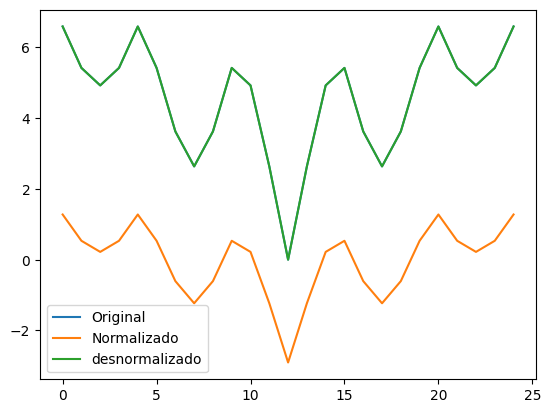

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [4]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 1.50 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [5]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [6]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-14 12:39:06.835821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 12:39:06.835876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 12:39:06.837244: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-14 12:39:06.878722: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-14 12:39:13.567205: W tensorflow/compiler/tf2

In [7]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [8]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [9]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36],
                            [4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 32ms/

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_0,0.495405,-0.038570,-1.588441,0.396999,0.498447,2.082010,1.908750,0.294846,2.394215e+14,0.706008,0.312892,0.717127,35.392516,72.357099
model_1_4_1,0.497271,-0.038995,-1.584214,0.397329,0.496604,2.082863,1.905633,0.294685,2.391186e+14,0.704701,0.315433,0.715799,35.399926,72.364509
model_1_4_2,0.499118,-0.039483,-1.580013,0.397670,0.494780,2.083841,1.902535,0.294518,2.388094e+14,0.703406,0.317948,0.714484,35.407286,72.371869


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_5] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_0,0.503426,-0.040090,-1.564033,0.595249,0.490524,2.085058,1.890751,0.302230,2.383828e+14,0.700374,0.323814,0.711405,35.424561,72.389145
model_1_5_1,0.504845,-0.040380,-1.559524,0.595036,0.489123,2.085639,1.887426,0.302389,2.382135e+14,0.699373,0.325746,0.710387,35.430284,72.394868
model_1_5_2,0.506263,-0.040724,-1.555399,0.594852,0.487722,2.086328,1.884384,0.302527,2.380318e+14,0.698371,0.327677,0.709370,35.436019,72.400602
model_1_5_3,0.507679,-0.041115,-1.551599,0.594694,0.486323,2.087113,1.881582,0.302644,2.378400e+14,0.697369,0.329605,0.708352,35.441764,72.406347
model_1_5_4,0.509088,-0.041543,-1.548044,0.594555,0.484931,2.087971,1.878961,0.302748,2.376415e+14,0.696370,0.331525,0.707337,35.447498,72.412082
model_1_5_5,0.510486,-0.041997,-1.544654,0.594427,0.483550,2.088881,1.876461,0.302844,2.374395e+14,0.695378,0.333428,0.706329,35.453201,72.417785
model_1_5_6,0.511869,-0.042469,-1.541382,0.594306,0.482184,2.089827,1.874048,0.302934,2.372358e+14,0.694395,0.335311,0.705331,35.458858,72.423442
model_1_5_7,0.513234,-0.042955,-1.538190,0.594189,0.480836,2.090801,1.871694,0.303022,2.370318e+14,0.693423,0.337169,0.704344,35.464459,72.429042
model_1_5_8,0.514579,-0.043452,-1.535052,0.594073,0.479507,2.091798,1.869380,0.303108,2.368284e+14,0.692464,0.339001,0.703370,35.469994,72.434577
model_1_5_9,0.515904,-0.043960,-1.531951,0.593959,0.478198,2.092815,1.867094,0.303193,2.366262e+14,0.691519,0.340805,0.702410,35.475460,72.440043


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 32ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 26ms/step
+++++++++++ [1_6] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_9,0.507753,-0.032570,-1.399559,0.296995,0.486250,2.069981,1.769466,1.467208,2.444445e+14,0.697316,0.329706,0.708298,35.442065,72.406649
model_1_6_8,0.509712,-0.035532,-1.418361,0.302952,0.484314,2.075920,1.783330,1.454775,2.435151e+14,0.695927,0.332374,0.706887,35.450042,72.414625
model_1_6_7,0.511309,-0.037867,-1.435337,0.308500,0.482737,2.080602,1.795849,1.443195,2.426293e+14,0.694793,0.334548,0.705735,35.456566,72.421150
model_1_6_6,0.512574,-0.039647,-1.450624,0.313645,0.481488,2.084169,1.807122,1.432457,2.417884e+14,0.693893,0.336270,0.704822,35.461748,72.426331
model_1_6_5,0.513565,-0.040980,-1.464537,0.318451,0.480509,2.086842,1.817381,1.422428,2.409851e+14,0.693187,0.337620,0.704104,35.465819,72.430403
model_1_6_4,0.514503,-0.042317,-1.478674,0.323331,0.479583,2.089523,1.827806,1.412243,2.401568e+14,0.692519,0.338897,0.703425,35.469679,72.434262
model_1_6_3,0.515154,-0.043191,-1.491258,0.327782,0.478939,2.091275,1.837086,1.402954,2.393815e+14,0.692054,0.339784,0.702953,35.472363,72.436947
model_1_6_2,0.515587,-0.043723,-1.502688,0.331905,0.478511,2.092341,1.845515,1.394348,2.386461e+14,0.691745,0.340374,0.702640,35.474150,72.438734
model_1_6_1,0.515834,-0.043987,-1.513147,0.335740,0.478267,2.092870,1.853228,1.386345,2.379462e+14,0.691568,0.340711,0.702460,35.475173,72.439756
model_1_6_0,0.515933,-0.044051,-1.522859,0.339342,0.478170,2.092999,1.860389,1.378826,2.372742e+14,0.691498,0.340844,0.702389,35.475578,72.440162


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_7] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_0,0.509208,-0.036365,-1.398326,0.441954,0.484813,2.077591,1.768556,1.126284,2.445434e+14,0.696285,0.331687,0.707251,35.447984,72.412567
model_1_7_1,0.510498,-0.039895,-1.396425,0.441384,0.483538,2.084667,1.767155,1.127434,2.446226e+14,0.695369,0.333444,0.706321,35.453249,72.417833
model_1_7_9,0.512242,-0.041005,-1.320922,0.431667,0.481815,2.086892,1.711478,1.147046,2.461771e+14,0.694129,0.335819,0.705061,35.460388,72.424972
model_1_7_2,0.511544,-0.042872,-1.393089,0.440672,0.482505,2.090634,1.764695,1.128871,2.447101e+14,0.694626,0.334869,0.705565,35.457529,72.422112
model_1_7_8,0.512517,-0.043129,-1.334123,0.433036,0.481544,2.091151,1.721213,1.144283,2.459124e+14,0.693934,0.336193,0.704863,35.461514,72.426098
model_1_7_7,0.512582,-0.044544,-1.345919,0.434273,0.481480,2.093987,1.729911,1.141785,2.456907e+14,0.693887,0.336282,0.704815,35.461782,72.426366
model_1_7_3,0.512228,-0.044983,-1.387426,0.439680,0.481829,2.094866,1.760519,1.130874,2.448413e+14,0.694139,0.335800,0.705071,35.460331,72.424915
model_1_7_6,0.512752,-0.045834,-1.358387,0.435724,0.481312,2.096573,1.739105,1.138857,2.454401e+14,0.693766,0.336513,0.704692,35.462480,72.427064
model_1_7_4,0.512672,-0.046245,-1.379838,0.438532,0.481391,2.097397,1.754923,1.133191,2.449998e+14,0.693823,0.336404,0.704750,35.462152,72.426736
model_1_7_5,0.512844,-0.046538,-1.370137,0.437208,0.481220,2.097983,1.747770,1.135863,2.451979e+14,0.693701,0.336639,0.704626,35.462860,72.427443


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_8] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_7,0.544448,-0.023083,-1.186725,0.289868,0.450001,2.050963,1.612519,1.246238,2.442401e+14,0.670822,0.379674,0.681386,35.597009,72.561592
model_1_8_8,0.548302,-0.023145,-1.182193,0.292657,0.446195,2.051088,1.609177,1.241342,2.437215e+14,0.667978,0.384922,0.678498,35.614000,72.578583
model_1_8_9,0.552213,-0.024527,-1.182796,0.296448,0.442331,2.053858,1.609622,1.234689,2.430280e+14,0.665080,0.390248,0.675554,35.631391,72.595975
model_1_8_0,0.510041,-0.025952,-1.247315,0.271400,0.483990,2.056716,1.657199,1.278647,2.478718e+14,0.695694,0.332822,0.706650,35.451384,72.415967
model_1_8_6,0.542765,-0.030159,-1.214657,0.291539,0.451664,2.065149,1.633117,1.243304,2.440966e+14,0.672060,0.377383,0.682644,35.589633,72.554217
model_1_8_5,0.538805,-0.030179,-1.222270,0.289554,0.455576,2.065190,1.638730,1.246788,2.445431e+14,0.674964,0.371990,0.685594,35.572386,72.536969
model_1_8_1,0.519265,-0.032007,-1.258121,0.279041,0.474878,2.068853,1.665168,1.265238,2.467529e+14,0.689114,0.345382,0.699967,35.489393,72.453976
model_1_8_2,0.527184,-0.037077,-1.266285,0.285807,0.467056,2.079018,1.671188,1.253364,2.456652e+14,0.683415,0.356166,0.694178,35.522614,72.487198
model_1_8_3,0.533920,-0.041021,-1.271971,0.291727,0.460401,2.086925,1.675381,1.242975,2.446307e+14,0.678529,0.365338,0.689215,35.551313,72.515897
model_1_8_4,0.539707,-0.044006,-1.275580,0.296986,0.454685,2.092907,1.678042,1.233745,2.436421e+14,0.674303,0.373219,0.684923,35.576302,72.540885


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_9] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_5,0.570150,0.036571,-0.945268,0.422512,0.424613,1.931376,1.434466,0.097010,2.327690e+14,0.651624,0.414672,0.661886,35.713153,72.677737
model_1_9_4,0.565996,0.035474,-0.956812,0.442275,0.428717,1.933576,1.442979,0.093690,2.350443e+14,0.654765,0.409015,0.665077,35.693917,72.658501
model_1_9_6,0.574328,0.035375,-0.940811,0.401724,0.420486,1.933773,1.431179,0.100502,2.304874e+14,0.648449,0.420362,0.658661,35.732690,72.697273
model_1_9_7,0.578297,0.032773,-0.940693,0.380058,0.416566,1.938990,1.431092,0.104142,2.282633e+14,0.645419,0.425766,0.655584,35.751422,72.716006
model_1_9_3,0.561949,0.031628,-0.976902,0.460679,0.432715,1.941285,1.457793,0.090599,2.372843e+14,0.657810,0.403504,0.668170,35.675354,72.639938
model_1_9_8,0.582058,0.028901,-0.944481,0.357399,0.412851,1.946753,1.433886,0.107948,2.260885e+14,0.642534,0.430887,0.652654,35.769339,72.733923
model_1_9_9,0.585442,0.024500,-0.949950,0.334170,0.409507,1.955576,1.437918,0.111850,2.240136e+14,0.639927,0.435496,0.650006,35.785602,72.750185
model_1_9_2,0.558586,0.022796,-1.012644,0.477375,0.436036,1.958992,1.484149,0.087794,2.393439e+14,0.660331,0.398925,0.670730,35.660059,72.624643
model_1_9_1,0.556610,0.005428,-1.075346,0.490860,0.437988,1.993808,1.530387,0.085529,2.409839e+14,0.661806,0.396235,0.672229,35.651128,72.615712
model_1_9_0,0.556722,-0.027662,-1.188101,0.494433,0.437878,2.060144,1.613534,0.084928,2.417250e+14,0.661723,0.396387,0.672145,35.651632,72.616215


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_10] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_0,0.584367,0.025286,-0.948466,0.632751,0.410569,1.953999,1.436824,0.399426,2.218576e+14,0.640757,0.434032,0.650848,35.780421,72.745005
model_1_10_2,0.581804,0.021790,-0.969768,0.593551,0.413101,1.961007,1.452532,0.442060,2.196031e+14,0.642729,0.430542,0.652852,35.768127,72.732710
model_1_10_1,0.584263,0.020357,-0.967190,0.614682,0.410672,1.963880,1.450631,0.419078,2.205122e+14,0.640837,0.433890,0.650929,35.779922,72.744506
model_1_10_3,0.586853,-0.013698,-1.085582,0.571420,0.408114,2.032149,1.537935,0.466130,2.164476e+14,0.638838,0.437416,0.648899,35.792418,72.757002
model_1_10_4,0.586279,-0.022014,-1.116297,0.555316,0.408681,2.048822,1.560585,0.483645,2.151362e+14,0.639281,0.436635,0.649350,35.789642,72.754225
model_1_10_5,0.585429,-0.027360,-1.137254,0.542046,0.409520,2.059538,1.576039,0.498078,2.141148e+14,0.639937,0.435478,0.650016,35.785540,72.750123
model_1_10_6,0.584535,-0.034976,-1.165007,0.527584,0.410403,2.074806,1.596504,0.513807,2.129483e+14,0.640627,0.434261,0.650716,35.781232,72.745815
model_1_10_7,0.583631,-0.042179,-1.192029,0.514531,0.411296,2.089245,1.616431,0.528004,2.119290e+14,0.641323,0.433030,0.651424,35.776885,72.741469
model_1_10_8,0.582126,-0.048396,-1.216803,0.498945,0.412783,2.101709,1.634700,0.544955,2.108288e+14,0.642482,0.430980,0.652601,35.769665,72.734249
model_1_10_9,0.581946,-0.049302,-1.220203,0.497049,0.412961,2.103525,1.637206,0.547018,2.106809e+14,0.642620,0.430735,0.652741,35.768806,72.733389


DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_11] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_3,0.586531,-0.003636,-1.041479,0.135149,0.408432,2.011979,1.505413,0.190497,2.110530e+14,0.639087,0.436978,0.649152,35.790862,72.755445
model_1_11_4,0.591651,-0.016194,-1.063894,0.140413,0.403374,2.037153,1.521942,0.189338,2.097128e+14,0.635117,0.443950,0.645120,35.815782,72.780366
model_1_11_1,0.583314,-0.016228,-1.099392,0.143629,0.411609,2.037221,1.548119,0.188629,2.110810e+14,0.641568,0.432598,0.651672,35.775361,72.739944
model_1_11_2,0.585324,-0.017709,-1.096018,0.143846,0.409624,2.040190,1.545631,0.188581,2.107259e+14,0.640019,0.435335,0.650098,35.785031,72.749615
model_1_11_5,0.594682,-0.026153,-1.083233,0.138058,0.400380,2.057117,1.536203,0.189856,2.087395e+14,0.632756,0.448077,0.642721,35.830681,72.795265
model_1_11_6,0.597394,-0.038707,-1.111135,0.128767,0.397701,2.082284,1.556779,0.191903,2.076038e+14,0.630636,0.451770,0.640568,35.844108,72.808692
model_1_11_9,0.599316,-0.041363,-1.105649,0.106316,0.395802,2.087609,1.552733,0.196848,2.067105e+14,0.629128,0.454388,0.639036,35.853680,72.818264
model_1_11_7,0.598403,-0.042090,-1.114139,0.120049,0.396705,2.089067,1.558993,0.193823,2.070775e+14,0.629845,0.453144,0.639764,35.849126,72.813710
model_1_11_8,0.598780,-0.042974,-1.115598,0.116926,0.396332,2.090840,1.560069,0.194511,2.069465e+14,0.629549,0.453657,0.639464,35.851005,72.815589
model_1_11_0,0.582585,-0.045925,-1.204144,0.152843,0.412329,2.096755,1.625364,0.186600,2.099389e+14,0.642129,0.431605,0.652242,35.771865,72.736449


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_12] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_12] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_4,0.586081,0.046350,-0.862010,0.457328,0.408876,1.911772,1.373070,0.910022,2.150357e+14,0.639434,0.436365,0.649505,35.788685,72.753269
model_1_12_6,0.586039,0.038177,-0.890231,0.438961,0.408918,1.928157,1.393881,0.940821,2.173465e+14,0.639467,0.436308,0.649538,35.788481,72.753065
model_1_12_3,0.589510,0.033070,-0.898497,0.468022,0.405489,1.938395,1.399976,0.892088,2.136907e+14,0.636780,0.441035,0.646809,35.805325,72.769909
model_1_12_7,0.587539,0.031085,-0.913768,0.438846,0.407436,1.942374,1.411238,0.941015,2.187030e+14,0.638307,0.438351,0.648359,35.795745,72.760329
model_1_12_8,0.589939,0.016872,-0.957383,0.440805,0.405065,1.970867,1.443400,0.937729,2.192955e+14,0.636447,0.441619,0.646471,35.807414,72.771997
model_1_12_5,0.591653,0.016856,-0.950278,0.455755,0.403372,1.970898,1.438160,0.912659,2.155775e+14,0.635116,0.443952,0.645118,35.815790,72.780374
model_1_12_2,0.592713,0.016828,-0.942934,0.481800,0.402325,1.970954,1.432745,0.868984,2.117801e+14,0.634291,0.445397,0.644280,35.820992,72.785576
model_1_12_1,0.593518,0.012139,-0.955308,0.486396,0.401530,1.980354,1.441869,0.861276,2.110313e+14,0.633664,0.446493,0.643643,35.824948,72.789531
model_1_12_9,0.590397,0.004678,-0.995289,0.437698,0.404613,1.995312,1.471352,0.942939,2.198780e+14,0.636092,0.442242,0.646110,35.809648,72.774231
model_1_12_0,0.598830,-0.035493,-1.089850,0.512646,0.396282,2.075843,1.541082,0.817258,2.074562e+14,0.629509,0.453726,0.639424,35.851258,72.815841


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  41
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_13] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_13] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_13]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_0,0.593027,-0.004530,-1.019172,0.389251,0.402015,2.013771,1.488964,0.215256,2.193959e+14,0.634046,0.445824,0.644032,35.822532,72.787116
model_1_13_1,0.605956,-0.035092,-1.066541,0.301080,0.389243,2.075039,1.523894,0.246332,2.083902e+14,0.623894,0.463430,0.633719,35.887102,72.851685
model_1_13_2,0.606335,-0.037720,-1.072987,0.297913,0.388869,2.080307,1.528647,0.247448,2.080222e+14,0.623593,0.463946,0.633414,35.889028,72.853612
model_1_13_4,0.607924,-0.043647,-1.073516,0.253427,0.387300,2.092189,1.529038,0.263127,2.031481e+14,0.622334,0.466109,0.632135,35.897113,72.861697
model_1_13_5,0.608103,-0.045097,-1.076062,0.248301,0.387122,2.095096,1.530915,0.264933,2.026089e+14,0.622191,0.466353,0.631990,35.898030,72.862613
model_1_13_7,0.608152,-0.045432,-1.071703,0.232344,0.387074,2.095767,1.527700,0.270557,2.009328e+14,0.622153,0.466420,0.631951,35.898279,72.862862
model_1_13_6,0.608146,-0.045514,-1.072266,0.233458,0.387080,2.095930,1.528116,0.270165,2.010390e+14,0.622157,0.466412,0.631956,35.898248,72.862832
model_1_13_3,0.608010,-0.047445,-1.091564,0.274045,0.387215,2.099801,1.542347,0.255860,2.052557e+14,0.622266,0.466226,0.632066,35.897553,72.862136
model_1_13_8,0.608577,-0.049471,-1.080768,0.221610,0.386654,2.103864,1.534385,0.274340,1.998760e+14,0.621815,0.466998,0.631608,35.900449,72.865032
model_1_13_9,0.608827,-0.052358,-1.086018,0.211913,0.386407,2.109651,1.538257,0.277758,1.989645e+14,0.621617,0.467339,0.631406,35.901727,72.866311


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  64
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_14] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_14] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_1,0.604837,-0.070966,-1.109505,0.468953,0.390349,2.146954,1.555576,0.311441,1.977565e+14,0.624779,0.461905,0.634619,35.881428,72.846012
model_1_14_0,0.605392,-0.071038,-1.110542,0.476990,0.389801,2.147099,1.556341,0.306728,1.977393e+14,0.624340,0.462661,0.634173,35.884240,72.848823
model_1_14_2,0.604302,-0.071403,-1.110005,0.461207,0.390877,2.147831,1.555945,0.315984,1.977428e+14,0.625202,0.461177,0.635048,35.878724,72.843308
model_1_14_3,0.603760,-0.075656,-1.121663,0.449406,0.391413,2.156355,1.564542,0.322905,1.975125e+14,0.625630,0.460439,0.635483,35.875985,72.840569
model_1_14_4,0.603098,-0.080078,-1.133125,0.436981,0.392067,2.165222,1.572994,0.330192,1.972513e+14,0.626152,0.459537,0.636014,35.872646,72.837230
model_1_14_5,0.602931,-0.080461,-1.133963,0.434977,0.392231,2.165988,1.573612,0.331367,1.972373e+14,0.626283,0.459311,0.636147,35.871809,72.836392
model_1_14_6,0.602707,-0.084310,-1.144009,0.428816,0.392452,2.173704,1.581020,0.334980,1.969914e+14,0.626460,0.459006,0.636326,35.870681,72.835265
model_1_14_7,0.602470,-0.087645,-1.152459,0.423217,0.392687,2.180391,1.587251,0.338264,1.967950e+14,0.626648,0.458682,0.636517,35.869484,72.834068
model_1_14_8,0.601291,-0.096643,-1.176652,0.404772,0.393851,2.198430,1.605092,0.349081,1.963220e+14,0.627575,0.457078,0.637459,35.863565,72.828149
model_1_14_9,0.601121,-0.100038,-1.185326,0.400454,0.394019,2.205236,1.611488,0.351614,1.961129e+14,0.627709,0.456846,0.637595,35.862712,72.827295


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_15] | 2 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_15] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_15] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_15] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_15] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_6,0.585999,0.027750,-0.934303,0.465972,0.408957,1.949060,1.426380,1.033691,2.167925e+14,0.639497,0.436254,0.649569,35.788291,72.752875
model_1_15_8,0.585906,0.027352,-0.936900,0.465056,0.409049,1.949858,1.428296,1.035466,2.169033e+14,0.639569,0.436127,0.649642,35.787841,72.752424
model_1_15_7,0.586131,0.026958,-0.937384,0.465668,0.408827,1.950647,1.428652,1.034280,2.168319e+14,0.639396,0.436434,0.649465,35.788927,72.753511
model_1_15_9,0.586039,0.026431,-0.941286,0.464343,0.408918,1.951704,1.431530,1.036845,2.170209e+14,0.639467,0.436308,0.649538,35.788482,72.753066
model_1_15_5,0.588063,0.022672,-0.941972,0.471315,0.406918,1.959239,1.432035,1.023349,2.158121e+14,0.637901,0.439065,0.647948,35.798287,72.762870
model_1_15_4,0.590261,0.014740,-0.955304,0.477680,0.404747,1.975141,1.441866,1.011029,2.143096e+14,0.636197,0.442058,0.646217,35.808987,72.773571
model_1_15_3,0.590364,0.014472,-0.954985,0.478312,0.404645,1.975678,1.441631,1.009807,2.141870e+14,0.636117,0.442198,0.646136,35.809488,72.774072
model_1_15_2,0.593004,0.005303,-0.968703,0.487348,0.402037,1.994060,1.451747,0.992316,2.123380e+14,0.634064,0.445793,0.644050,35.822420,72.787004
model_1_15_1,0.596714,-0.009899,-0.990473,0.503865,0.398373,2.024534,1.467801,0.960345,2.092189e+14,0.631168,0.450844,0.641108,35.840734,72.805318
model_1_15_0,0.602309,-0.056750,-1.084847,0.540248,0.392846,2.118456,1.537393,0.889919,2.016469e+14,0.626774,0.458463,0.636645,35.868677,72.833260


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_16] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 27ms/step
+++++++++++ [1_16] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_16] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_4,0.584067,0.048285,-0.866608,0.440914,0.410865,1.907894,1.376461,0.416451,2.129437e+14,0.640988,0.433624,0.651083,35.778980,72.743564
model_1_16_3,0.584452,0.047150,-0.869597,0.443672,0.410485,1.910169,1.378665,0.414396,2.129937e+14,0.640691,0.434147,0.650782,35.780830,72.745413
model_1_16_5,0.584485,0.046998,-0.869677,0.439203,0.410453,1.910473,1.378724,0.417726,2.126462e+14,0.640666,0.434192,0.650756,35.780988,72.745571
model_1_16_6,0.584809,0.045790,-0.872582,0.435085,0.410132,1.912896,1.380867,0.420793,2.122284e+14,0.640416,0.434634,0.650502,35.782551,72.747134
model_1_16_1,0.586486,0.037320,-0.901843,0.460657,0.408476,1.929874,1.402443,0.401745,2.140708e+14,0.639121,0.436918,0.649187,35.790645,72.755229
model_1_16_2,0.586697,0.037014,-0.902053,0.458785,0.408268,1.930487,1.402598,0.403139,2.138159e+14,0.638959,0.437204,0.649022,35.791663,72.756246
model_1_16_0,0.586253,0.035109,-0.912201,0.470703,0.408706,1.934306,1.410082,0.394262,2.152410e+14,0.639301,0.436600,0.649370,35.789517,72.754100
model_1_16_7,0.588347,0.033080,-0.902444,0.425129,0.406638,1.938375,1.402887,0.428209,2.097107e+14,0.637681,0.439452,0.647724,35.799666,72.764250
model_1_16_8,0.588650,0.031841,-0.905540,0.423397,0.406338,1.940858,1.405170,0.429499,2.094689e+14,0.637447,0.439864,0.647486,35.801138,72.765721
model_1_16_9,0.588964,0.030546,-0.908803,0.421706,0.406028,1.943455,1.407576,0.430759,2.092278e+14,0.637204,0.440291,0.647239,35.802665,72.767248


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_17] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_17] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_17] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_0,0.592703,0.017501,-0.939330,0.541197,0.402335,1.969605,1.430087,0.119911,2.073203e+14,0.634299,0.445383,0.644288,35.820941,72.785525
model_1_17_3,0.601535,0.000417,-0.964234,0.491112,0.393610,2.003853,1.448451,0.133001,2.067204e+14,0.627384,0.457410,0.637264,35.864789,72.829373
model_1_17_1,0.600058,-0.001239,-0.979340,0.527586,0.395069,2.007174,1.459591,0.123468,2.063832e+14,0.628546,0.455398,0.638444,35.857387,72.821971
model_1_17_2,0.600587,-0.002807,-0.982795,0.526612,0.394546,2.010318,1.462139,0.123723,2.063286e+14,0.628129,0.456119,0.638022,35.860037,72.824620
model_1_17_4,0.603882,-0.008707,-0.981511,0.477626,0.391292,2.022144,1.461192,0.136526,2.060006e+14,0.625533,0.460605,0.635385,35.876602,72.841185
model_1_17_5,0.604362,-0.010969,-0.986926,0.476933,0.390818,2.026679,1.465185,0.136707,2.059111e+14,0.625154,0.461259,0.635000,35.879028,72.843612
model_1_17_6,0.604582,-0.011723,-0.988306,0.475680,0.390601,2.028190,1.466203,0.137034,2.058582e+14,0.624981,0.461558,0.634823,35.880139,72.844723
model_1_17_7,0.604810,-0.012477,-0.989784,0.474568,0.390375,2.029703,1.467293,0.137325,2.058209e+14,0.624800,0.461869,0.634640,35.881295,72.845878
model_1_17_8,0.605147,-0.013769,-0.992902,0.474123,0.390042,2.032292,1.469592,0.137441,2.057605e+14,0.624534,0.462328,0.634370,35.882999,72.847583
model_1_17_9,0.606304,-0.020125,-1.010695,0.475980,0.388900,2.045034,1.482713,0.136956,2.056389e+14,0.623618,0.463903,0.633440,35.888867,72.853451


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_18] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_18] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_18] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_18] | 8 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_18] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_0,0.602731,-0.086162,-1.229012,0.630731,0.392429,2.177418,1.643703,0.214821,2.017961e+14,0.626441,0.459038,0.636307,35.870800,72.835384
model_1_18_3,0.601913,-0.091928,-1.245048,0.592678,0.393237,2.188977,1.655528,0.236959,2.018091e+14,0.627086,0.457924,0.636962,35.866684,72.831268
model_1_18_1,0.602343,-0.093805,-1.250868,0.613754,0.392812,2.192739,1.659819,0.224697,2.014636e+14,0.626747,0.458509,0.636618,35.868846,72.833430
model_1_18_4,0.601862,-0.095469,-1.251843,0.586726,0.393287,2.196075,1.660538,0.240421,2.017631e+14,0.627126,0.457855,0.637003,35.866430,72.831014
model_1_18_2,0.602200,-0.098211,-1.255490,0.595610,0.392953,2.201572,1.663227,0.235253,2.017212e+14,0.626860,0.458315,0.636732,35.868129,72.832713
model_1_18_5,0.601114,-0.110177,-1.292785,0.538264,0.394026,2.225560,1.690730,0.268614,2.011803e+14,0.627715,0.456836,0.637601,35.862675,72.827258
model_1_18_6,0.602979,-0.112881,-1.297452,0.550010,0.392184,2.230982,1.694171,0.261781,2.010999e+14,0.626246,0.459376,0.636108,35.872051,72.836634
model_1_18_8,0.595910,-0.115908,-1.343680,0.441652,0.399166,2.237050,1.728260,0.324817,2.004155e+14,0.631796,0.449750,0.641746,35.836754,72.801337
model_1_18_9,0.595412,-0.120145,-1.350359,0.431704,0.399659,2.245543,1.733185,0.330605,2.002720e+14,0.632186,0.449072,0.642142,35.834288,72.798872
model_1_18_7,0.591664,-0.142455,-1.619311,0.414523,0.403361,2.290267,1.931514,0.340599,2.006672e+14,0.635107,0.443969,0.645109,35.815848,72.780432


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_19] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_19] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_19] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_9,0.596741,-0.118169,-1.581826,0.587506,0.398346,2.241581,1.903872,0.412584,1.987950e+14,0.631147,0.450881,0.641087,35.840867,72.805450
model_1_19_8,0.596835,-0.118518,-1.582524,0.589238,0.398253,2.242281,1.904387,0.410851,1.988457e+14,0.631073,0.451009,0.641012,35.841334,72.805918
model_1_19_7,0.597905,-0.130388,-1.606240,0.630576,0.397196,2.266078,1.921875,0.369504,2.000285e+14,0.630235,0.452467,0.640160,35.846652,72.811236
model_1_19_6,0.597735,-0.134310,-1.615486,0.640727,0.397364,2.273939,1.928693,0.359351,2.002810e+14,0.630368,0.452235,0.640296,35.845805,72.810389
model_1_19_5,0.597705,-0.134850,-1.616682,0.642811,0.397394,2.275022,1.929575,0.357266,2.003474e+14,0.630392,0.452194,0.640320,35.845656,72.810240
model_1_19_4,0.597666,-0.135391,-1.617938,0.644903,0.397433,2.276107,1.930501,0.355174,2.004140e+14,0.630423,0.452140,0.640351,35.845460,72.810043
model_1_19_3,0.597609,-0.136072,-1.619575,0.646976,0.397488,2.277473,1.931708,0.353100,2.004738e+14,0.630467,0.452064,0.640396,35.845180,72.809764
model_1_19_1,0.597485,-0.136392,-1.607900,0.651234,0.397611,2.278113,1.923100,0.348842,2.005988e+14,0.630564,0.451895,0.640494,35.844564,72.809148
model_1_19_2,0.597557,-0.136401,-1.619986,0.649113,0.397540,2.278132,1.932012,0.350964,2.005399e+14,0.630508,0.451992,0.640438,35.844919,72.809502
model_1_19_0,0.597034,-0.139141,-1.579504,0.657136,0.398057,2.283625,1.902160,0.342939,2.004910e+14,0.630917,0.451280,0.640854,35.842321,72.806905


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_20] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_20] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_20] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_20] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_20] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_20] | 8 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_20] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_9,0.598686,-0.032742,-1.019457,-0.148857,0.396424,2.070328,1.489173,0.450595,1.898811e+14,0.629622,0.453530,0.639538,35.850540,72.815124
model_1_20_8,0.599454,-0.032988,-1.020030,-0.136318,0.395666,2.070820,1.489596,0.445677,1.899987e+14,0.629020,0.454576,0.638926,35.854369,72.818953
model_1_20_7,0.597851,-0.059880,-1.071132,-0.094475,0.397249,2.124730,1.527280,0.429266,1.920707e+14,0.630277,0.452393,0.640203,35.846383,72.810967
model_1_20_5,0.597898,-0.061333,-1.108228,-0.025722,0.397203,2.127644,1.554634,0.402300,1.950479e+14,0.630241,0.452456,0.640166,35.846613,72.811197
model_1_20_4,0.603546,-0.064023,-1.336086,0.072361,0.391624,2.133035,1.722660,0.363831,1.953589e+14,0.625798,0.460148,0.635654,35.874908,72.839491
model_1_20_6,0.597514,-0.064306,-1.105671,-0.035211,0.397583,2.133603,1.552749,0.406022,1.948613e+14,0.630541,0.451934,0.640472,35.844705,72.809289
model_1_20_3,0.602665,-0.074413,-1.444150,0.101841,0.392494,2.153864,1.802348,0.352268,1.962148e+14,0.626493,0.458948,0.636360,35.870468,72.835052
model_1_20_2,0.600892,-0.084753,-1.478450,0.143988,0.394245,2.174593,1.827641,0.335738,1.972751e+14,0.627890,0.456534,0.637778,35.861564,72.826147
model_1_20_1,0.593825,-0.086660,-1.484459,0.067899,0.401227,2.178415,1.832073,0.365581,1.975039e+14,0.633425,0.446910,0.643400,35.826457,72.791040
model_1_20_0,0.589418,-0.105294,-1.541967,0.090037,0.405580,2.215772,1.874479,0.356898,1.981846e+14,0.636851,0.440910,0.646881,35.804877,72.769460


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_21] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_21] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_21] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_21] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_21] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_21] | 7 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_21

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_0,0.584629,-0.030080,-1.023852,-0.089170,0.410310,2.064991,1.492415,0.460621,1.863586e+14,0.640555,0.434388,0.650643,35.781682,72.746266
model_1_21_1,0.585093,-0.046963,-1.038991,-0.185579,0.409852,2.098836,1.503578,0.501393,1.815980e+14,0.640197,0.435021,0.650279,35.783919,72.748503
model_1_21_2,0.584954,-0.050062,-1.042185,-0.202959,0.409990,2.105049,1.505934,0.508743,1.807942e+14,0.640304,0.434830,0.650389,35.783246,72.747830
model_1_21_3,0.584021,-0.059443,-1.049938,-0.261028,0.410911,2.123855,1.511651,0.533302,1.782449e+14,0.641023,0.433561,0.651119,35.778759,72.743342
model_1_21_4,0.583506,-0.063847,-1.054486,-0.285556,0.411420,2.132683,1.515004,0.543675,1.772043e+14,0.641420,0.432859,0.651522,35.776282,72.740866
model_1_21_5,0.580997,-0.077952,-1.068067,-0.366349,0.413898,2.160958,1.525020,0.577843,1.739842e+14,0.643349,0.429443,0.653481,35.764270,72.728854
model_1_21_6,0.576348,-0.096526,-1.088400,-0.470675,0.418491,2.198195,1.540013,0.621963,1.700304e+14,0.646908,0.423112,0.657097,35.742202,72.706785
model_1_21_7,0.576070,-0.097577,-1.089730,-0.476341,0.418765,2.200302,1.540994,0.624360,1.698158e+14,0.647121,0.422733,0.657312,35.740889,72.705473
model_1_21_8,0.575234,-0.100836,-1.094138,-0.493234,0.419591,2.206834,1.544245,0.631504,1.691672e+14,0.647759,0.421595,0.657960,35.736948,72.701532
model_1_21_9,0.574955,-0.101900,-1.095604,-0.498778,0.419866,2.208967,1.545325,0.633848,1.689536e+14,0.647971,0.421216,0.658176,35.735639,72.700222


DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_22] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_22] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_22] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_9,0.594435,-0.040507,-1.012181,0.451821,0.400624,2.085894,1.483808,0.988816,1.926082e+14,0.632949,0.447741,0.642917,35.829462,72.794046
model_1_22_8,0.593271,-0.044436,-1.013466,0.455938,0.401774,2.093770,1.484756,0.981388,1.899703e+14,0.633856,0.446156,0.643839,35.823732,72.788316
model_1_22_5,0.590941,-0.052928,-1.020768,0.463374,0.404075,2.110793,1.490140,0.967975,1.853186e+14,0.635669,0.442984,0.645680,35.812308,72.776892
model_1_22_6,0.591391,-0.053221,-1.023472,0.462814,0.403631,2.111382,1.492134,0.968986,1.857375e+14,0.635320,0.443596,0.645325,35.814507,72.779091
model_1_22_7,0.591828,-0.053556,-1.026249,0.462268,0.403199,2.112053,1.494182,0.969971,1.861471e+14,0.634980,0.444191,0.644980,35.816649,72.781232
model_1_22_4,0.588042,-0.059099,-1.023663,0.468510,0.406939,2.123164,1.492275,0.958712,1.815450e+14,0.637917,0.439036,0.647964,35.798186,72.762769
model_1_22_3,0.587613,-0.060500,-1.025398,0.469152,0.407362,2.125973,1.493555,0.957554,1.809813e+14,0.638249,0.438452,0.648301,35.796104,72.760688
model_1_22_2,0.578335,-0.094934,-1.082791,0.477741,0.416527,2.195002,1.535877,0.942060,1.712043e+14,0.645389,0.425818,0.655554,35.751606,72.716190
model_1_22_1,0.574572,-0.104922,-1.098635,0.479024,0.420245,2.215026,1.547560,0.939746,1.685565e+14,0.648263,0.420694,0.658473,35.733835,72.698418
model_1_22_0,0.573574,-0.105630,-1.097568,0.479309,0.421231,2.216446,1.546774,0.939232,1.680208e+14,0.649023,0.419335,0.659244,35.729150,72.693733


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_23] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_23] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_23] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_23] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_23] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_9,0.593537,-0.033180,-0.978691,0.130553,0.401510,2.071205,1.459113,0.454006,2.008865e+14,0.633649,0.446519,0.643628,35.825043,72.789627
model_1_23_8,0.594122,-0.036175,-0.974266,0.141816,0.400933,2.077210,1.455850,0.448125,2.003867e+14,0.633193,0.447315,0.643165,35.827921,72.792504
model_1_23_5,0.594204,-0.039237,-1.021559,0.246089,0.400852,2.083348,1.490724,0.393676,1.956064e+14,0.633129,0.447427,0.643100,35.828325,72.792909
model_1_23_3,0.594918,-0.039488,-1.017173,0.273187,0.400147,2.083851,1.487490,0.379526,1.943800e+14,0.632572,0.448399,0.642534,35.831846,72.796430
model_1_23_1,0.594758,-0.039582,-1.013955,0.287080,0.400305,2.084039,1.485116,0.372271,1.935340e+14,0.632697,0.448181,0.642661,35.831057,72.795641
model_1_23_4,0.594894,-0.040042,-1.019890,0.269069,0.400170,2.084961,1.489493,0.381676,1.945495e+14,0.632590,0.448367,0.642553,35.831730,72.796314
model_1_23_2,0.594881,-0.040119,-1.016434,0.283782,0.400183,2.085116,1.486944,0.373993,1.937281e+14,0.632600,0.448349,0.642563,35.831665,72.796248
model_1_23_0,0.594646,-0.041095,-1.015013,0.297534,0.400416,2.087072,1.485897,0.366812,1.928043e+14,0.632784,0.448028,0.642750,35.830504,72.795087
model_1_23_6,0.593644,-0.041212,-1.028615,0.233031,0.401406,2.087306,1.495927,0.400495,1.959132e+14,0.633566,0.446664,0.643544,35.825566,72.790149
model_1_23_7,0.593238,-0.042278,-1.032532,0.225927,0.401807,2.089445,1.498815,0.404204,1.960275e+14,0.633882,0.446111,0.643865,35.823568,72.788152


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++
Stopped at epoch:  50
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_24] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_24] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_24] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_24] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_24] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_0,0.598260,-0.039180,-1.021703,0.301574,0.396845,2.083234,1.490830,0.473721,1.880118e+14,0.629957,0.452950,0.639878,35.848417,72.813000
model_1_24_1,0.596857,-0.041587,-1.025725,0.259187,0.398231,2.088058,1.493796,0.502471,1.856703e+14,0.631056,0.451040,0.640994,35.841445,72.806029
model_1_24_2,0.595120,-0.050863,-1.048310,0.209173,0.399947,2.106654,1.510451,0.536393,1.827533e+14,0.632413,0.448675,0.642373,35.832848,72.797431
model_1_24_3,0.591922,-0.059871,-1.072181,0.145309,0.403106,2.124713,1.528053,0.579711,1.793139e+14,0.634907,0.444319,0.644906,35.817110,72.781694
model_1_24_4,0.591637,-0.060908,-1.074865,0.139992,0.403387,2.126790,1.530033,0.583317,1.790188e+14,0.635128,0.443932,0.645131,35.815715,72.780299
model_1_24_5,0.590754,-0.063902,-1.082693,0.124180,0.404260,2.132793,1.535805,0.594042,1.781538e+14,0.635815,0.442728,0.645828,35.811392,72.775976
model_1_24_8,0.589729,-0.063949,-1.083447,0.109846,0.405273,2.132887,1.536361,0.603764,1.774701e+14,0.636610,0.441333,0.646636,35.806390,72.770974
model_1_24_6,0.590450,-0.064938,-1.085396,0.118914,0.404560,2.134871,1.537798,0.597614,1.778618e+14,0.636050,0.442316,0.646067,35.809911,72.774494
model_1_24_9,0.589417,-0.064998,-1.086198,0.104605,0.405581,2.134990,1.538389,0.607319,1.771814e+14,0.636852,0.440908,0.646882,35.804870,72.769454
model_1_24_7,0.590135,-0.065796,-1.087669,0.113723,0.404872,2.136590,1.539475,0.601134,1.775810e+14,0.636295,0.441886,0.646316,35.808370,72.772954


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_25] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_25] | 5 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_25] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_25] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_4,0.585346,-0.051018,-1.052495,0.141701,0.409602,2.106965,1.513536,0.322936,1.808638e+14,0.640002,0.435364,0.650081,35.785137,72.749720
model_1_25_6,0.586866,-0.051550,-1.050783,0.151150,0.408101,2.108030,1.512274,0.319381,1.811781e+14,0.638828,0.437434,0.648889,35.792481,72.757064
model_1_25_5,0.589764,-0.052788,-1.052016,0.194177,0.405238,2.110513,1.513183,0.303192,1.810217e+14,0.636583,0.441381,0.646609,35.806561,72.771145
model_1_25_8,0.592897,-0.054489,-1.047827,0.207882,0.402143,2.113922,1.510094,0.298036,1.824384e+14,0.634148,0.445647,0.644135,35.821894,72.786478
model_1_25_7,0.593949,-0.054884,-1.048870,0.226382,0.401104,2.114714,1.510863,0.291075,1.822952e+14,0.633327,0.447080,0.643302,35.827071,72.791655
model_1_25_9,0.593823,-0.058858,-1.047883,0.215606,0.401228,2.122682,1.510135,0.295129,1.826144e+14,0.633426,0.446909,0.643401,35.826451,72.791034
model_1_25_3,0.591052,-0.060184,-1.075099,0.301320,0.403966,2.125339,1.530205,0.262879,1.781095e+14,0.635583,0.443134,0.645593,35.812850,72.777434
model_1_25_1,0.590497,-0.060913,-1.078312,0.307607,0.404514,2.126801,1.532574,0.260514,1.777548e+14,0.636014,0.442379,0.646031,35.810138,72.774721
model_1_25_2,0.591094,-0.061304,-1.077258,0.308561,0.403924,2.127584,1.531797,0.260155,1.779253e+14,0.635550,0.443192,0.645560,35.813056,72.777640
model_1_25_0,0.590121,-0.062884,-1.082722,0.316686,0.404886,2.130752,1.535826,0.257098,1.773826e+14,0.636306,0.441867,0.646327,35.808302,72.772885


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_26] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_26] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 6 ++++++++++++++++++
Stopped at epoch:  56
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_26] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_26

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_2,0.599326,-0.061347,-1.036739,0.329830,0.395793,2.127671,1.501918,0.505137,1.804901e+14,0.629121,0.454401,0.639029,35.853729,72.818313
model_1_26_3,0.599323,-0.061592,-1.037165,0.328485,0.395795,2.128162,1.502232,0.506150,1.804425e+14,0.629123,0.454398,0.639031,35.853717,72.818301
model_1_26_4,0.599317,-0.061830,-1.037579,0.327153,0.395802,2.128639,1.502537,0.507154,1.803972e+14,0.629128,0.454389,0.639036,35.853684,72.818268
model_1_26_1,0.599317,-0.062828,-1.041724,0.343893,0.395801,2.130640,1.505594,0.494536,1.806949e+14,0.629127,0.454390,0.639035,35.853687,72.818271
model_1_26_0,0.598992,-0.064216,-1.047002,0.355678,0.396122,2.133424,1.509486,0.485654,1.809009e+14,0.629383,0.453947,0.639295,35.852064,72.816647
model_1_26_5,0.596491,-0.069919,-1.053109,0.269011,0.398593,2.144855,1.513989,0.550978,1.787237e+14,0.631342,0.450541,0.641285,35.839629,72.804213
model_1_26_6,0.596414,-0.070096,-1.053486,0.268065,0.398669,2.145210,1.514267,0.551692,1.786948e+14,0.631402,0.450436,0.641346,35.839248,72.803831
model_1_26_7,0.596259,-0.070468,-1.054293,0.266207,0.398822,2.145957,1.514862,0.553092,1.786390e+14,0.631523,0.450226,0.641469,35.838481,72.803065
model_1_26_8,0.596183,-0.070653,-1.054695,0.265292,0.398897,2.146328,1.515158,0.553782,1.786121e+14,0.631583,0.450121,0.641530,35.838102,72.802686
model_1_26_9,0.594611,-0.073942,-1.061935,0.248289,0.400450,2.152921,1.520497,0.566597,1.781138e+14,0.632811,0.447981,0.642778,35.830331,72.794915


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_27] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_27] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_27] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_27] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_9,0.593781,-0.060690,-1.026348,0.262613,0.401270,2.126354,1.494256,0.568566,1.793105e+14,0.633459,0.446851,0.643435,35.826243,72.790826
model_1_27_8,0.594439,-0.061829,-1.028466,0.273110,0.400620,2.128637,1.495817,0.560472,1.791822e+14,0.632945,0.447747,0.642914,35.829485,72.794068
model_1_27_7,0.594578,-0.062101,-1.029006,0.275636,0.400483,2.129184,1.496215,0.558525,1.791506e+14,0.632837,0.447936,0.642804,35.830170,72.794753
model_1_27_6,0.595426,-0.066707,-1.039506,0.294423,0.399645,2.138417,1.503958,0.544039,1.787597e+14,0.632175,0.449091,0.642131,35.834357,72.798941
model_1_27_5,0.595481,-0.067021,-1.040321,0.296668,0.399591,2.139046,1.504559,0.542308,1.787268e+14,0.632132,0.449165,0.642088,35.834627,72.799211
model_1_27_4,0.595527,-0.067338,-1.041167,0.298879,0.399545,2.139681,1.505183,0.540603,1.786939e+14,0.632096,0.449228,0.642051,35.834855,72.799439
model_1_27_3,0.595614,-0.069032,-1.045915,0.309543,0.399459,2.143078,1.508684,0.532381,1.785285e+14,0.632028,0.449347,0.641981,35.835288,72.799872
model_1_27_2,0.595602,-0.069372,-1.046905,0.311588,0.399471,2.143760,1.509414,0.530804,1.784965e+14,0.632037,0.449331,0.641991,35.835229,72.799813
model_1_27_1,0.594887,-0.073141,-1.059138,0.330574,0.400177,2.151315,1.518435,0.516165,1.781774e+14,0.632595,0.448357,0.642558,35.831696,72.796280
model_1_27_0,0.594755,-0.073515,-1.060442,0.332298,0.400308,2.152064,1.519397,0.514835,1.781469e+14,0.632699,0.448177,0.642663,35.831041,72.795625


DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_28] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_28] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_4,0.579222,-0.046495,-1.051209,-1.815259,0.415651,2.097897,1.512588,0.410154,1.803270e+14,0.644710,0.427026,0.654864,35.755817,72.720400
model_1_28_5,0.579337,-0.046892,-1.052415,-1.817721,0.415538,2.098693,1.513477,0.410513,1.803578e+14,0.644623,0.427182,0.654775,35.756362,72.720945
model_1_28_6,0.579450,-0.047304,-1.053636,-1.820204,0.415426,2.099520,1.514378,0.410875,1.803861e+14,0.644536,0.427336,0.654687,35.756900,72.721483
model_1_28_7,0.579560,-0.047695,-1.054793,-1.822640,0.415318,2.100304,1.515231,0.411230,1.804155e+14,0.644452,0.427485,0.654601,35.757421,72.722005
model_1_28_8,0.579671,-0.048094,-1.056001,-1.824950,0.415208,2.101104,1.516121,0.411566,1.804458e+14,0.644367,0.427637,0.654515,35.757949,72.722533
model_1_28_9,0.579867,-0.048797,-1.058101,-1.829957,0.415015,2.102513,1.517671,0.412296,1.805099e+14,0.644216,0.427904,0.654362,35.758883,72.723466
model_1_28_3,0.585702,-0.055499,-1.033463,-1.483326,0.409250,2.115948,1.499502,0.361795,1.798009e+14,0.639727,0.435850,0.649802,35.786856,72.751439
model_1_28_2,0.587326,-0.056314,-1.032325,-1.417824,0.407647,2.117582,1.498663,0.352252,1.797540e+14,0.638472,0.438060,0.648527,35.794709,72.759293
model_1_28_1,0.588734,-0.057221,-1.031746,-1.359692,0.406256,2.119400,1.498236,0.343783,1.796944e+14,0.637382,0.439978,0.647420,35.801545,72.766128
model_1_28_0,0.589904,-0.057806,-1.030643,-1.309062,0.405100,2.120573,1.497422,0.336407,1.796441e+14,0.636475,0.441571,0.646499,35.807243,72.771826


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_29] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_29] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_29] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_8,0.586873,-0.047612,-1.042444,0.612574,0.408094,2.100137,1.506125,0.254676,1.834349e+14,0.638822,0.437444,0.648883,35.792516,72.757100
model_1_29_9,0.588203,-0.047762,-1.040737,0.605275,0.406780,2.100438,1.504866,0.259474,1.841818e+14,0.637793,0.439255,0.647838,35.798966,72.763549
model_1_29_4,0.585247,-0.047865,-1.045815,0.619266,0.409700,2.100644,1.508611,0.250277,1.826143e+14,0.640078,0.435230,0.650159,35.784659,72.749243
model_1_29_3,0.583265,-0.047896,-1.049514,0.625539,0.411658,2.100707,1.511338,0.246153,1.817898e+14,0.641606,0.432531,0.651711,35.775124,72.739707
model_1_29_5,0.585608,-0.047958,-1.045462,0.617971,0.409343,2.100830,1.508350,0.251128,1.827681e+14,0.639800,0.435721,0.649876,35.786402,72.750985
model_1_29_6,0.585951,-0.047973,-1.044855,0.616615,0.409005,2.100860,1.507902,0.252019,1.829293e+14,0.639535,0.436189,0.649607,35.788058,72.752642
model_1_29_7,0.586279,-0.048003,-1.044328,0.615234,0.408680,2.100921,1.507514,0.252927,1.830853e+14,0.639281,0.436635,0.649349,35.789644,72.754227
model_1_29_0,0.580411,-0.048716,-1.056852,0.631860,0.414477,2.102350,1.516750,0.241998,1.806918e+14,0.643799,0.428645,0.653938,35.761478,72.726061
model_1_29_1,0.582435,-0.048718,-1.053138,0.627723,0.412478,2.102354,1.514010,0.244717,1.813878e+14,0.642244,0.431401,0.652359,35.771146,72.735730
model_1_29_2,0.582899,-0.048734,-1.052296,0.626587,0.412019,2.102386,1.513390,0.245464,1.815576e+14,0.641887,0.432033,0.651996,35.773372,72.737956


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_30] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_30] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_30] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_30] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_30] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_0,0.591203,-0.052200,-1.058950,0.749672,0.403817,2.109335,1.518296,0.254768,1.856966e+14,0.635466,0.443340,0.645474,35.813588,72.778171
model_1_30_1,0.592711,-0.052685,-1.065742,0.739828,0.402327,2.110307,1.523305,0.264786,1.869298e+14,0.634292,0.445394,0.644282,35.820982,72.785565
model_1_30_2,0.592969,-0.053270,-1.068342,0.738136,0.402072,2.111480,1.525222,0.266509,1.870892e+14,0.634092,0.445745,0.644078,35.822248,72.786832
model_1_30_3,0.593408,-0.054390,-1.073133,0.734557,0.401638,2.113724,1.528755,0.270151,1.874213e+14,0.633749,0.446343,0.643730,35.824406,72.788990
model_1_30_4,0.593801,-0.055392,-1.077712,0.731115,0.401250,2.115732,1.532132,0.273654,1.877491e+14,0.633443,0.446878,0.643419,35.826341,72.790925
model_1_30_5,0.593968,-0.056063,-1.080247,0.729252,0.401085,2.117080,1.534001,0.275550,1.879104e+14,0.633313,0.447106,0.643287,35.827164,72.791747
model_1_30_6,0.594127,-0.056744,-1.082836,0.727401,0.400928,2.118444,1.535910,0.277434,1.880676e+14,0.633189,0.447322,0.643161,35.827947,72.792530
model_1_30_7,0.595455,-0.061390,-1.105951,0.712963,0.399617,2.127759,1.552955,0.292128,1.894247e+14,0.632152,0.449130,0.642108,35.834499,72.799082
model_1_30_8,0.596353,-0.069712,-1.142828,0.692143,0.398729,2.144441,1.580149,0.313318,1.912006e+14,0.631450,0.450353,0.641395,35.838946,72.803529
model_1_30_9,0.596341,-0.070185,-1.144844,0.690525,0.398741,2.145388,1.581635,0.314964,1.913331e+14,0.631460,0.450336,0.641405,35.838885,72.803468


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_31] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 11ms/step
+++++++++++ [1_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_31] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_31] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_31] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_2,0.598732,-0.028326,-1.053512,0.548119,0.396379,2.061475,1.514286,0.826578,2.050697e+14,0.629586,0.453593,0.639502,35.850770,72.815353
model_1_31_3,0.598892,-0.029349,-1.057433,0.547149,0.396221,2.063526,1.517178,0.828353,2.053821e+14,0.629461,0.453810,0.639374,35.851565,72.816149
model_1_31_4,0.599082,-0.030723,-1.062467,0.546146,0.396034,2.066281,1.520890,0.830187,2.056859e+14,0.629312,0.454069,0.639223,35.852513,72.817096
model_1_31_6,0.599622,-0.046340,-1.120431,0.527388,0.395500,2.097587,1.563634,0.864500,2.119224e+14,0.628888,0.454804,0.638792,35.855208,72.819792
model_1_31_5,0.599920,-0.046574,-1.118665,0.531455,0.395206,2.098055,1.562331,0.857060,2.102702e+14,0.628654,0.455210,0.638554,35.856698,72.821282
model_1_31_0,0.599252,-0.058101,-1.122400,0.562094,0.395865,2.121163,1.565085,0.801015,1.967795e+14,0.629178,0.454301,0.639087,35.853363,72.817946
model_1_31_1,0.600600,-0.059570,-1.128346,0.555237,0.394534,2.124109,1.569470,0.813559,1.999044e+14,0.628119,0.456137,0.638011,35.860101,72.824685
model_1_31_7,0.599645,-0.060185,-1.165557,0.519809,0.395477,2.125342,1.596910,0.878363,2.134664e+14,0.628870,0.454836,0.638774,35.855324,72.819908
model_1_31_8,0.599657,-0.061468,-1.170175,0.518867,0.395466,2.127914,1.600315,0.880087,2.137170e+14,0.628861,0.454852,0.638765,35.855383,72.819966
model_1_31_9,0.599614,-0.065741,-1.172911,0.517097,0.395508,2.136481,1.602333,0.883323,2.144207e+14,0.628894,0.454794,0.638799,35.855170,72.819753


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_32] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_32] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_32] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_32] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_7,0.602893,-0.055831,-1.127819,0.474689,0.392269,2.116614,1.569082,0.429832,2.076965e+14,0.626314,0.459259,0.636177,35.871617,72.836200
model_1_32_8,0.602698,-0.056055,-1.127354,0.464854,0.392462,2.117063,1.568738,0.437879,2.070865e+14,0.626468,0.458992,0.636334,35.870631,72.835214
model_1_32_9,0.602582,-0.056187,-1.127119,0.459957,0.392576,2.117327,1.568565,0.441886,2.067915e+14,0.626559,0.458835,0.636427,35.870049,72.834632
model_1_32_0,0.600904,-0.061489,-1.157380,0.613106,0.394234,2.127955,1.590880,0.316573,2.136033e+14,0.627881,0.456550,0.637769,35.861621,72.826205
model_1_32_6,0.604369,-0.072883,-1.175596,0.484978,0.390811,2.150797,1.604313,0.421413,2.067917e+14,0.625148,0.461269,0.634994,35.879064,72.843648
model_1_32_5,0.604730,-0.074525,-1.183752,0.505290,0.390454,2.154089,1.610327,0.404793,2.078469e+14,0.624863,0.461760,0.634704,35.880890,72.845474
model_1_32_4,0.604781,-0.074845,-1.185418,0.510381,0.390404,2.154730,1.611556,0.400628,2.081265e+14,0.624823,0.461829,0.634664,35.881145,72.845729
model_1_32_3,0.605631,-0.144554,-1.383044,0.571229,0.389565,2.294476,1.757288,0.350839,2.056104e+14,0.624151,0.462987,0.633981,35.885452,72.850035
model_1_32_2,0.605555,-0.148811,-1.395942,0.578367,0.389640,2.303009,1.766799,0.344998,2.053835e+14,0.624211,0.462883,0.634042,35.885065,72.849649
model_1_32_1,0.605067,-0.156410,-1.418357,0.585125,0.390122,2.318243,1.783328,0.339469,2.051042e+14,0.624597,0.462218,0.634434,35.882592,72.847176


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_33] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_33] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_33] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_7,0.591025,-0.026579,-1.102224,0.588454,0.403993,2.057971,1.550207,1.061228,2.178205e+14,0.635604,0.443097,0.645614,35.812717,72.777300
model_1_33_8,0.589537,-0.028670,-1.117009,0.580546,0.405463,2.062165,1.561110,1.081620,2.190967e+14,0.636759,0.441071,0.646788,35.805454,72.770037
model_1_33_9,0.589218,-0.029032,-1.119773,0.578987,0.405777,2.062889,1.563148,1.085640,2.193489e+14,0.637006,0.440638,0.647039,35.803902,72.768486
model_1_33_6,0.596824,-0.049501,-1.152794,0.603292,0.398264,2.103923,1.587498,1.022965,2.140049e+14,0.631081,0.450995,0.641020,35.841282,72.805866
model_1_33_5,0.599788,-0.049960,-1.133749,0.620277,0.395336,2.104844,1.573454,0.979168,2.108643e+14,0.628757,0.455031,0.638660,35.856040,72.820624
model_1_33_4,0.600775,-0.052211,-1.133135,0.626196,0.394361,2.109356,1.573001,0.963905,2.096566e+14,0.627982,0.456374,0.637872,35.860975,72.825558
model_1_33_3,0.601227,-0.054415,-1.136956,0.628298,0.393915,2.113776,1.575819,0.958483,2.091526e+14,0.627626,0.456990,0.637511,35.863241,72.827825
model_1_33_2,0.601446,-0.054441,-1.134668,0.630240,0.393698,2.113826,1.574132,0.953476,2.087861e+14,0.627454,0.457288,0.637336,35.864340,72.828924
model_1_33_1,0.601726,-0.055155,-1.134234,0.632265,0.393422,2.115258,1.573812,0.948254,2.083716e+14,0.627234,0.457669,0.637112,35.865745,72.830329
model_1_33_0,0.602055,-0.056531,-1.135728,0.634333,0.393097,2.118017,1.574914,0.942921,2.079091e+14,0.626974,0.458118,0.636848,35.867400,72.831984


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_34] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_34] | 5 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_34] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_0,0.591594,-0.032276,-1.123037,0.613734,0.403431,2.069393,1.565555,0.288603,2.181195e+14,0.635162,0.443872,0.645165,35.815501,72.780085
model_1_34_1,0.592343,-0.033433,-1.124430,0.610174,0.402690,2.071713,1.566583,0.291263,2.177106e+14,0.634579,0.444893,0.644573,35.819175,72.783759
model_1_34_2,0.593079,-0.034688,-1.126159,0.606555,0.401963,2.074228,1.567857,0.293967,2.172978e+14,0.634006,0.445895,0.643990,35.822790,72.787374
model_1_34_3,0.597021,-0.037046,-1.120235,0.580697,0.398070,2.078956,1.563489,0.313288,2.146760e+14,0.630928,0.451262,0.640864,35.842256,72.806839
model_1_34_4,0.604166,-0.062495,-1.170575,0.512754,0.391012,2.129973,1.600610,0.364051,2.079526e+14,0.625309,0.460991,0.635157,35.878035,72.842618
model_1_34_5,0.604388,-0.063765,-1.173200,0.509051,0.390792,2.132519,1.602546,0.366819,2.076136e+14,0.625134,0.461294,0.634979,35.879159,72.843743
model_1_34_6,0.604600,-0.065112,-1.176055,0.505292,0.390583,2.135218,1.604651,0.369627,2.072720e+14,0.624966,0.461583,0.634809,35.880230,72.844814
model_1_34_7,0.604796,-0.066426,-1.178854,0.501565,0.390389,2.137854,1.606715,0.372412,2.069352e+14,0.624811,0.461850,0.634652,35.881221,72.845805
model_1_34_8,0.604971,-0.067560,-1.181111,0.497998,0.390216,2.140127,1.608380,0.375077,2.066139e+14,0.624673,0.462088,0.634511,35.882109,72.846693
model_1_34_9,0.605289,-0.069981,-1.186204,0.490726,0.389902,2.144980,1.612136,0.380510,2.059680e+14,0.624421,0.462521,0.634255,35.883719,72.848303


DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_35] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_35] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_35] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_35] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 24ms/step
+++++++++++ [1_35] | 8 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_35] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_6,0.606375,-0.052366,-1.130655,0.409245,0.388829,2.109667,1.571173,0.340516,2.028996e+14,0.623562,0.464000,0.633382,35.889230,72.853814
model_1_35_3,0.606067,-0.053131,-1.133002,0.430447,0.389134,2.111201,1.572903,0.328295,2.041662e+14,0.623806,0.463580,0.633630,35.887663,72.852247
model_1_35_4,0.606233,-0.053288,-1.133075,0.424546,0.388969,2.111516,1.572957,0.331696,2.037745e+14,0.623674,0.463807,0.633496,35.888509,72.853092
model_1_35_5,0.606311,-0.053442,-1.133299,0.421651,0.388893,2.111824,1.573123,0.333365,2.035778e+14,0.623613,0.463913,0.633434,35.888904,72.853488
model_1_35_7,0.604839,-0.055091,-1.152351,0.317473,0.390346,2.115130,1.587172,0.393414,1.977945e+14,0.624777,0.461909,0.634617,35.881441,72.846025
model_1_35_8,0.603204,-0.056916,-1.166317,0.279768,0.391962,2.118789,1.597470,0.415147,1.959790e+14,0.626069,0.459682,0.635928,35.873182,72.837765
model_1_35_9,0.603061,-0.057242,-1.168056,0.276670,0.392103,2.119443,1.598753,0.416934,1.958203e+14,0.626181,0.459488,0.636043,35.872462,72.837046
model_1_35_2,0.606594,-0.067511,-1.174164,0.456056,0.388613,2.140028,1.603257,0.313534,2.044678e+14,0.623388,0.464299,0.633206,35.890344,72.854928
model_1_35_1,0.606328,-0.067981,-1.176494,0.462062,0.388876,2.140970,1.604975,0.310072,2.048424e+14,0.623599,0.463936,0.633420,35.888992,72.853576
model_1_35_0,0.606041,-0.068930,-1.180204,0.468227,0.389160,2.142874,1.607711,0.306518,2.051963e+14,0.623827,0.463545,0.633651,35.887531,72.852115


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 25ms/step
+++++++++++ [1_36] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_36] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_36] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_36] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_36] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_0,0.605433,-0.074132,-1.183980,0.481345,0.389760,2.153300,1.610495,0.273377,1.952332e+14,0.624308,0.462717,0.634140,35.884447,72.849031
model_1_36_1,0.605710,-0.077134,-1.187751,0.476947,0.389486,2.159320,1.613276,0.275695,1.950997e+14,0.624088,0.463095,0.633917,35.885854,72.850438
model_1_36_2,0.605813,-0.077794,-1.187280,0.475473,0.389385,2.160642,1.612928,0.276472,1.950894e+14,0.624007,0.463235,0.633834,35.886375,72.850959
model_1_36_3,0.605939,-0.079325,-1.189232,0.473226,0.389260,2.163712,1.614368,0.277657,1.950206e+14,0.623907,0.463406,0.633733,35.887013,72.851597
model_1_36_4,0.606828,-0.096266,-1.213138,0.447659,0.388382,2.197674,1.631997,0.291132,1.942102e+14,0.623203,0.464617,0.633018,35.891534,72.856117
model_1_36_5,0.606910,-0.101155,-1.220868,0.439932,0.388301,2.207474,1.637697,0.295205,1.939582e+14,0.623138,0.464728,0.632952,35.891949,72.856533
model_1_36_6,0.606920,-0.101638,-1.220472,0.438142,0.388291,2.208443,1.637405,0.296149,1.939495e+14,0.623130,0.464742,0.632943,35.892002,72.856585
model_1_36_7,0.606445,-0.122565,-1.257588,0.404625,0.388760,2.250394,1.664775,0.313815,1.927984e+14,0.623506,0.464096,0.633326,35.889586,72.854170
model_1_36_8,0.606356,-0.124269,-1.261032,0.401574,0.388848,2.253809,1.667314,0.315423,1.926959e+14,0.623577,0.463974,0.633398,35.889132,72.853715
model_1_36_9,0.605976,-0.130565,-1.274059,0.391674,0.389223,2.266431,1.676921,0.320641,1.923106e+14,0.623878,0.463457,0.633703,35.887204,72.851788


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_37] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_37] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_37] | 5 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_37] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_37] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 22ms/step
+++++++++++ [1_37] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_0,0.605792,-0.134473,-1.285170,0.463557,0.389406,2.274266,1.685114,0.257303,1.920504e+14,0.624024,0.463206,0.633852,35.886267,72.850851
model_1_37_1,0.605502,-0.139714,-1.299557,0.451991,0.389692,2.284773,1.695723,0.262850,1.916689e+14,0.624253,0.462811,0.634084,35.884799,72.849383
model_1_37_2,0.605073,-0.145958,-1.317570,0.432932,0.390116,2.297290,1.709006,0.271992,1.911433e+14,0.624592,0.462227,0.634429,35.882625,72.847208
model_1_37_8,0.601680,-0.146266,-1.344584,0.261367,0.393467,2.297908,1.728927,0.354282,1.877240e+14,0.627270,0.457607,0.637149,35.865514,72.830098
model_1_37_9,0.601105,-0.146552,-1.348414,0.244876,0.394035,2.298480,1.731751,0.362192,1.873399e+14,0.627722,0.456824,0.637608,35.862631,72.827214
model_1_37_3,0.604486,-0.151722,-1.334406,0.413566,0.390696,2.308845,1.721421,0.281281,1.906125e+14,0.625057,0.461427,0.634901,35.879652,72.844235
model_1_37_4,0.601620,-0.159570,-1.371328,0.294349,0.393526,2.324577,1.748648,0.338463,1.880130e+14,0.627317,0.457525,0.637196,35.865215,72.829799
model_1_37_5,0.601435,-0.159704,-1.372719,0.288317,0.393709,2.324847,1.749673,0.341356,1.878797e+14,0.627463,0.457273,0.637345,35.864284,72.828868
model_1_37_7,0.600684,-0.159918,-1.377517,0.264670,0.394451,2.325276,1.753212,0.352698,1.873658e+14,0.628054,0.456250,0.637945,35.860520,72.825103
model_1_37_6,0.601023,-0.160032,-1.375746,0.275927,0.394116,2.325503,1.751906,0.347299,1.876084e+14,0.627787,0.456713,0.637674,35.862221,72.826804


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_38] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_38] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_38] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_38] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_38] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_38] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_38] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_1,0.601488,-0.146311,-1.344856,0.479802,0.393657,2.297998,1.729127,0.364804,1.871593e+14,0.627421,0.457345,0.637302,35.864552,72.829135
model_1_38_9,0.602105,-0.146333,-1.321526,0.413388,0.393047,2.298042,1.711923,0.411379,1.855295e+14,0.626935,0.458186,0.636808,35.867651,72.832234
model_1_38_2,0.602155,-0.146398,-1.336966,0.459478,0.392998,2.298171,1.723309,0.379057,1.866241e+14,0.626896,0.458253,0.636769,35.867900,72.832483
model_1_38_3,0.602236,-0.146453,-1.335458,0.455062,0.392918,2.298282,1.722197,0.382154,1.865111e+14,0.626832,0.458364,0.636704,35.868308,72.832892
model_1_38_0,0.601228,-0.146552,-1.347445,0.484370,0.393913,2.298482,1.731036,0.361601,1.872736e+14,0.627625,0.456992,0.637510,35.863249,72.827832
model_1_38_4,0.602309,-0.146620,-1.333440,0.448520,0.392846,2.298617,1.720709,0.386742,1.863448e+14,0.626774,0.458463,0.636645,35.868674,72.833258
model_1_38_5,0.602292,-0.146775,-1.326889,0.427337,0.392862,2.298928,1.715878,0.401597,1.858284e+14,0.626787,0.458440,0.636659,35.868592,72.833175
model_1_38_6,0.602151,-0.147024,-1.325150,0.419090,0.393002,2.299428,1.714596,0.407380,1.856212e+14,0.626899,0.458248,0.636772,35.867880,72.832463
model_1_38_7,0.602114,-0.147046,-1.324635,0.417056,0.393038,2.299471,1.714216,0.408807,1.855730e+14,0.626927,0.458198,0.636801,35.867698,72.832282
model_1_38_8,0.602073,-0.147069,-1.324150,0.415029,0.393079,2.299517,1.713858,0.410228,1.855252e+14,0.626960,0.458142,0.636834,35.867491,72.832074


DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_39] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_39] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 28ms/step
+++++++++++ [1_39] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_39] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_9,0.588496,-0.127604,-1.249747,0.604714,0.406490,2.260496,1.658993,0.375271,1.898338e+14,0.637566,0.439655,0.647607,35.800391,72.764974
model_1_39_8,0.588482,-0.128210,-1.249187,0.606223,0.406505,2.261710,1.658580,0.373839,1.897721e+14,0.637577,0.439634,0.647619,35.800319,72.764902
model_1_39_4,0.587551,-0.128959,-1.246482,0.625979,0.407424,2.263213,1.656585,0.355083,1.888742e+14,0.638298,0.438367,0.648351,35.795800,72.760384
model_1_39_3,0.587420,-0.129661,-1.246371,0.627495,0.407554,2.264619,1.656503,0.353644,1.888026e+14,0.638399,0.438189,0.648453,35.795166,72.759750
model_1_39_7,0.587999,-0.130065,-1.246414,0.619880,0.406982,2.265430,1.656535,0.360873,1.891743e+14,0.637951,0.438977,0.647998,35.797974,72.762558
model_1_39_5,0.587682,-0.130341,-1.246021,0.624442,0.407295,2.265983,1.656245,0.356542,1.889617e+14,0.638197,0.438545,0.648248,35.796435,72.761018
model_1_39_6,0.587904,-0.130569,-1.246185,0.621403,0.407075,2.266439,1.656366,0.359428,1.891057e+14,0.638024,0.438848,0.648073,35.797515,72.762099
model_1_39_2,0.585187,-0.134629,-1.255675,0.642233,0.409759,2.274580,1.663364,0.339652,1.878373e+14,0.640125,0.435148,0.650206,35.784370,72.748954
model_1_39_1,0.584771,-0.134944,-1.261026,0.643625,0.410170,2.275211,1.667310,0.338330,1.876286e+14,0.640445,0.434582,0.650532,35.782367,72.746950
model_1_39_0,0.589661,-0.141279,-1.306249,0.692181,0.405340,2.287910,1.700658,0.292233,1.861690e+14,0.636663,0.441240,0.646690,35.806057,72.770641


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_40] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_40] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_40] | 8 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_40] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_9,0.593241,-0.084748,-1.167759,0.547816,0.401803,2.174584,1.598533,0.269045,1.943322e+14,0.633879,0.446116,0.643862,35.823586,72.788169
model_1_40_8,0.593348,-0.087658,-1.167656,0.573674,0.401697,2.180418,1.598458,0.253659,1.938453e+14,0.633796,0.446261,0.643778,35.824112,72.788696
model_1_40_7,0.593335,-0.088032,-1.167888,0.576179,0.401710,2.181166,1.598629,0.252169,1.937888e+14,0.633806,0.446243,0.643788,35.824047,72.788631
model_1_40_6,0.591604,-0.100596,-1.187691,0.623796,0.403421,2.206353,1.613232,0.223837,1.922507e+14,0.635154,0.443886,0.645157,35.815551,72.780135
model_1_40_5,0.591448,-0.100676,-1.187154,0.626282,0.403574,2.206515,1.612835,0.222359,1.921972e+14,0.635275,0.443674,0.645280,35.814790,72.779374
model_1_40_4,0.590188,-0.124929,-1.248876,0.635645,0.404820,2.255133,1.658350,0.216787,1.904906e+14,0.636254,0.441958,0.646275,35.808627,72.773211
model_1_40_3,0.589392,-0.126966,-1.251057,0.646271,0.405605,2.259217,1.659958,0.210465,1.901312e+14,0.636871,0.440874,0.646902,35.804750,72.769333
model_1_40_2,0.589179,-0.127449,-1.251583,0.648765,0.405816,2.260186,1.660347,0.208981,1.900397e+14,0.637037,0.440584,0.647070,35.803710,72.768293
model_1_40_1,0.588963,-0.127615,-1.251281,0.651268,0.406029,2.260518,1.660124,0.207492,1.899660e+14,0.637204,0.440290,0.647239,35.802661,72.767245
model_1_40_0,0.588734,-0.127653,-1.250627,0.653846,0.406256,2.260595,1.659642,0.205958,1.898983e+14,0.637382,0.439978,0.647420,35.801545,72.766128


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_41] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_41] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_41] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_41] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_41] | 8 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_41] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_2,0.603340,-0.039887,-1.050054,0.769937,0.391827,2.084651,1.511736,0.119781,1.988152e+14,0.625961,0.459867,0.635819,35.873868,72.838451
model_1_41_3,0.605428,-0.048009,-1.066482,0.761102,0.389765,2.100933,1.523850,0.124381,1.992020e+14,0.624311,0.462711,0.634144,35.884425,72.849008
model_1_41_4,0.606787,-0.051898,-1.076243,0.754022,0.388423,2.108729,1.531049,0.128067,1.996461e+14,0.623236,0.464561,0.633051,35.891322,72.855906
model_1_41_5,0.607013,-0.052881,-1.078539,0.752838,0.388199,2.110700,1.532742,0.128683,1.996991e+14,0.623056,0.464869,0.632868,35.892476,72.857059
model_1_41_9,0.609766,-0.056327,-1.079993,0.726246,0.385479,2.117608,1.533813,0.142528,2.024057e+14,0.620870,0.468618,0.630648,35.906535,72.871119
model_1_41_8,0.609813,-0.057761,-1.084009,0.727098,0.385433,2.120482,1.536775,0.142084,2.022310e+14,0.620833,0.468682,0.630610,35.906775,72.871359
model_1_41_7,0.609808,-0.057827,-1.084568,0.727725,0.385438,2.120615,1.537187,0.141758,2.021153e+14,0.620837,0.468675,0.630614,35.906749,72.871332
model_1_41_6,0.571563,-0.058792,-1.092912,0.388240,0.423217,2.122549,1.543341,0.318509,2.003579e+14,0.650551,0.416597,0.660797,35.719741,72.684325
model_1_41_1,0.594676,-0.081862,-1.156374,0.769680,0.400386,2.168797,1.590139,0.119914,1.952771e+14,0.632760,0.448070,0.642726,35.830654,72.795238
model_1_41_0,0.593625,-0.083970,-1.163485,0.773346,0.401424,2.173024,1.595382,0.118006,1.946041e+14,0.633580,0.446639,0.643558,35.825475,72.790059


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 2 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_42] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_42] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_42] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_42] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_0,0.612030,-0.078412,-1.126276,0.556187,0.383243,2.161881,1.567944,0.305854,1.990213e+14,0.619066,0.471701,0.628816,35.918172,72.882756
model_1_42_1,0.611803,-0.080213,-1.130262,0.536114,0.383468,2.165493,1.570883,0.319687,1.967128e+14,0.619248,0.471391,0.629000,35.916999,72.881583
model_1_42_4,0.611388,-0.085015,-1.142454,0.514583,0.383878,2.175118,1.579873,0.334525,1.944396e+14,0.619579,0.470826,0.629336,35.914863,72.879446
model_1_42_3,0.611411,-0.086106,-1.141830,0.515785,0.383855,2.177305,1.579413,0.333697,1.945575e+14,0.619560,0.470858,0.629318,35.914983,72.879566
model_1_42_2,0.611403,-0.086135,-1.139030,0.517598,0.383863,2.177364,1.577348,0.332447,1.947293e+14,0.619567,0.470846,0.629324,35.914940,72.879524
model_1_42_6,0.611391,-0.090109,-1.152465,0.507788,0.383874,2.185330,1.587256,0.339208,1.938020e+14,0.619576,0.470831,0.629333,35.914881,72.879465
model_1_42_5,0.611390,-0.090209,-1.149704,0.509547,0.383875,2.185530,1.585220,0.337996,1.939661e+14,0.619577,0.470829,0.629334,35.914876,72.879459
model_1_42_7,0.611210,-0.099520,-1.179006,0.489827,0.384053,2.204196,1.606827,0.351586,1.921374e+14,0.619720,0.470584,0.629480,35.913949,72.878533
model_1_42_8,0.610849,-0.107821,-1.199696,0.475139,0.384410,2.220837,1.622084,0.361708,1.908117e+14,0.620008,0.470092,0.629772,35.912092,72.876675
model_1_42_9,0.610713,-0.109402,-1.205133,0.471064,0.384544,2.224007,1.626094,0.364516,1.904464e+14,0.620116,0.469907,0.629883,35.911393,72.875976


DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_43] | 2 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_43] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_43] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_43] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_43] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_9,0.612273,-0.091134,-1.180587,0.551239,0.383003,2.187385,1.607993,0.207396,1.973665e+14,0.618873,0.472031,0.628619,35.919422,72.884006
model_1_43_4,0.612493,-0.092760,-1.177121,0.582055,0.382785,2.190645,1.605437,0.193154,1.949728e+14,0.618697,0.472332,0.628440,35.920561,72.885145
model_1_43_5,0.612519,-0.093125,-1.178500,0.580717,0.382760,2.191377,1.606454,0.193772,1.950401e+14,0.618676,0.472367,0.628419,35.920695,72.885278
model_1_43_6,0.612558,-0.093618,-1.181096,0.575061,0.382722,2.192365,1.608369,0.196386,1.953962e+14,0.618645,0.472419,0.628388,35.920894,72.885477
model_1_43_7,0.612577,-0.094008,-1.182464,0.573783,0.382703,2.193147,1.609377,0.196977,1.954660e+14,0.618630,0.472445,0.628373,35.920992,72.885576
model_1_43_8,0.612813,-0.096377,-1.191698,0.567035,0.382470,2.197895,1.616187,0.200096,1.961675e+14,0.618441,0.472767,0.628181,35.922212,72.886796
model_1_43_2,0.612310,-0.099458,-1.189820,0.600094,0.382967,2.204073,1.614802,0.184817,1.933127e+14,0.618843,0.472081,0.628589,35.919613,72.884197
model_1_43_3,0.612910,-0.103598,-1.204500,0.590650,0.382374,2.212371,1.625627,0.189182,1.940304e+14,0.618364,0.472899,0.628102,35.922713,72.887297
model_1_43_1,0.612429,-0.105220,-1.204670,0.603749,0.382849,2.215623,1.625752,0.183128,1.928257e+14,0.618748,0.472244,0.628492,35.920230,72.884814
model_1_43_0,0.610827,-0.107487,-1.200762,0.635169,0.384432,2.220168,1.622871,0.168607,1.906808e+14,0.620026,0.470062,0.629790,35.911979,72.876562


DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_44] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_44] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_44] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_44] | 7 ++++++++++++++++++
Stopped at epoch:  39
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_44] | 8 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_44] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_4,0.607304,-0.076205,-1.133596,0.611462,0.387912,2.157457,1.573341,0.276836,1.971966e+14,0.622826,0.465265,0.632635,35.893954,72.858537
model_1_44_3,0.607449,-0.076277,-1.134033,0.613732,0.387768,2.157602,1.573664,0.275219,1.972510e+14,0.622710,0.465463,0.632517,35.894696,72.859280
model_1_44_5,0.606352,-0.077359,-1.135309,0.595819,0.388853,2.159771,1.574605,0.287981,1.966908e+14,0.623580,0.463968,0.633401,35.889110,72.853694
model_1_44_6,0.601315,-0.080762,-1.137025,0.530114,0.393828,2.166593,1.575870,0.334797,1.945092e+14,0.627557,0.457109,0.637441,35.863681,72.828265
model_1_44_7,0.598961,-0.082764,-1.138800,0.503978,0.396153,2.170605,1.577179,0.353419,1.935553e+14,0.629407,0.453905,0.639319,35.851911,72.816495
model_1_44_8,0.598818,-0.082871,-1.138866,0.502445,0.396294,2.170820,1.577227,0.354511,1.934986e+14,0.629519,0.453710,0.639433,35.851196,72.815780
model_1_44_9,0.597824,-0.083849,-1.139895,0.491994,0.397277,2.172781,1.577986,0.361957,1.931006e+14,0.630299,0.452356,0.640225,35.846245,72.810829
model_1_44_2,0.610681,-0.093853,-1.182755,0.652148,0.384576,2.192835,1.609592,0.247847,1.967239e+14,0.620142,0.469863,0.629909,35.911228,72.875811
model_1_44_1,0.610817,-0.094138,-1.183915,0.654737,0.384441,2.193407,1.610447,0.246002,1.967559e+14,0.620033,0.470049,0.629798,35.911928,72.876512
model_1_44_0,0.612045,-0.104743,-1.214376,0.673950,0.383229,2.214667,1.632909,0.232312,1.964045e+14,0.619055,0.471721,0.628804,35.918248,72.882831


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_45] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_45] | 5 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_45] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_0,0.600306,-0.087967,-1.153651,0.637781,0.394824,2.181037,1.588130,0.381284,1.923725e+14,0.628350,0.455736,0.638246,35.858630,72.823213
model_1_45_1,0.601178,-0.090740,-1.164982,0.632454,0.393963,2.186596,1.596486,0.386892,1.919378e+14,0.627665,0.456923,0.637550,35.862996,72.827580
model_1_45_2,0.601305,-0.091247,-1.167037,0.631560,0.393838,2.187611,1.598001,0.387833,1.918624e+14,0.627565,0.457096,0.637449,35.863631,72.828215
model_1_45_3,0.601430,-0.092921,-1.169145,0.630683,0.393714,2.190967,1.599555,0.388756,1.917865e+14,0.627466,0.457267,0.637348,35.864262,72.828846
model_1_45_4,0.602601,-0.098562,-1.198516,0.618713,0.392557,2.202276,1.621214,0.401355,1.907963e+14,0.626544,0.458861,0.636411,35.870147,72.834730
model_1_45_5,0.602650,-0.099099,-1.200612,0.617879,0.392509,2.203352,1.622760,0.402234,1.907293e+14,0.626505,0.458928,0.636372,35.870394,72.834977
model_1_45_6,0.602699,-0.099642,-1.202711,0.617053,0.392461,2.204440,1.624308,0.403103,1.906617e+14,0.626467,0.458994,0.636333,35.870636,72.835220
model_1_45_7,0.602738,-0.100135,-1.204720,0.616232,0.392422,2.205430,1.625789,0.403967,1.905980e+14,0.626436,0.459047,0.636302,35.870833,72.835416
model_1_45_8,0.602777,-0.100671,-1.206795,0.615415,0.392384,2.206503,1.627319,0.404827,1.905326e+14,0.626406,0.459100,0.636271,35.871029,72.835612
model_1_45_9,0.602869,-0.103456,-1.212663,0.613011,0.392292,2.212086,1.631646,0.407358,1.903463e+14,0.626332,0.459226,0.636197,35.871496,72.836079


DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_46] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_46] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 30ms/step
+++++++++++ [1_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_46] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_0,0.604255,-0.099839,-1.224382,0.521769,0.390923,2.204836,1.640288,1.058439,1.923222e+14,0.625238,0.461114,0.635085,35.878489,72.843072
model_1_46_1,0.604368,-0.099850,-1.225811,0.521005,0.390812,2.204858,1.641342,1.060129,1.925300e+14,0.625150,0.461267,0.634995,35.879058,72.843641
model_1_46_2,0.604670,-0.100468,-1.229681,0.518760,0.390513,2.206097,1.644196,1.065098,1.931569e+14,0.624911,0.461679,0.634752,35.880587,72.845171
model_1_46_4,0.604843,-0.100590,-1.232577,0.517259,0.390343,2.206341,1.646331,1.068420,1.935646e+14,0.624774,0.461914,0.634614,35.881459,72.846043
model_1_46_5,0.604983,-0.101294,-1.235600,0.515774,0.390204,2.207753,1.648560,1.071707,1.939565e+14,0.624663,0.462105,0.634501,35.882169,72.846753
model_1_46_8,0.605170,-0.101531,-1.239825,0.513546,0.390020,2.208227,1.651676,1.076638,1.945701e+14,0.624515,0.462359,0.634351,35.883117,72.847701
model_1_46_3,0.604761,-0.102826,-1.231106,0.518013,0.390424,2.210824,1.645246,1.066751,1.933615e+14,0.624839,0.461802,0.634679,35.881046,72.845630
model_1_46_6,0.605054,-0.103327,-1.237286,0.515009,0.390134,2.211829,1.649804,1.073400,1.941589e+14,0.624607,0.462202,0.634444,35.882530,72.847114
model_1_46_7,0.605113,-0.103840,-1.238798,0.514278,0.390076,2.212857,1.650919,1.075018,1.943550e+14,0.624561,0.462282,0.634397,35.882827,72.847411
model_1_46_9,0.605197,-0.110161,-1.279484,0.499518,0.389993,2.225528,1.680921,1.107685,1.980616e+14,0.624494,0.462396,0.634329,35.883254,72.847838


DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_47] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_47] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_47] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 24ms/step
+++++++++++ [1_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_47] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_47] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_0,0.595761,-0.111540,-1.288484,0.561808,0.399314,2.228292,1.687558,0.316511,1.974891e+14,0.631913,0.449547,0.641865,35.836016,72.800599
model_1_47_1,0.597202,-0.116415,-1.293696,0.555769,0.397890,2.238065,1.691401,0.320873,1.969366e+14,0.630786,0.451509,0.640720,35.843157,72.807741
model_1_47_2,0.597257,-0.116930,-1.294001,0.554397,0.397837,2.239099,1.691626,0.321864,1.967758e+14,0.630743,0.451583,0.640677,35.843427,72.808011
model_1_47_3,0.597288,-0.117177,-1.294049,0.553782,0.397806,2.239594,1.691661,0.322308,1.967026e+14,0.630719,0.451626,0.640652,35.843581,72.808165
model_1_47_9,0.597829,-0.118401,-1.285401,0.543185,0.397271,2.242047,1.685284,0.329962,1.955102e+14,0.630294,0.452363,0.640221,35.846273,72.810857
model_1_47_4,0.597724,-0.118535,-1.288670,0.545706,0.397375,2.242315,1.687695,0.328141,1.957848e+14,0.630377,0.452220,0.640305,35.845750,72.810333
model_1_47_8,0.597808,-0.118718,-1.286643,0.543541,0.397292,2.242683,1.686200,0.329705,1.955444e+14,0.630311,0.452335,0.640238,35.846168,72.810752
model_1_47_5,0.597733,-0.118795,-1.288824,0.545169,0.397366,2.242836,1.687808,0.328529,1.957204e+14,0.630370,0.452233,0.640297,35.845796,72.810380
model_1_47_6,0.597743,-0.119051,-1.288969,0.544648,0.397356,2.243351,1.687915,0.328906,1.956567e+14,0.630362,0.452246,0.640290,35.845843,72.810427
model_1_47_7,0.597758,-0.119544,-1.289212,0.543617,0.397341,2.244339,1.688094,0.329650,1.955327e+14,0.630350,0.452267,0.640277,35.845921,72.810504


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_48] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_48] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_48] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_48] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_3,0.598437,-0.066281,-1.152966,0.510765,0.396671,2.137563,1.587625,0.852491,2.008578e+14,0.629818,0.453190,0.639737,35.849297,72.813880
model_1_48_4,0.599443,-0.068109,-1.159125,0.503686,0.395677,2.141227,1.592167,0.864827,2.024336e+14,0.629028,0.454561,0.638935,35.854315,72.818899
model_1_48_5,0.599628,-0.068415,-1.159885,0.502271,0.395494,2.141841,1.592727,0.867291,2.027444e+14,0.628884,0.454812,0.638788,35.855237,72.819820
model_1_48_6,0.600402,-0.074595,-1.173901,0.501654,0.394729,2.154229,1.603063,0.868367,2.032914e+14,0.628275,0.455867,0.638169,35.859111,72.823694
model_1_48_7,0.601144,-0.078750,-1.187274,0.493062,0.393997,2.162559,1.612924,0.883339,2.057874e+14,0.627692,0.456877,0.637577,35.862826,72.827409
model_1_48_9,0.601393,-0.082777,-1.198581,0.491638,0.393751,2.170632,1.621262,0.885819,2.061743e+14,0.627496,0.457216,0.637378,35.864075,72.828658
model_1_48_8,0.601324,-0.082945,-1.198432,0.493043,0.393819,2.170968,1.621153,0.883371,2.059144e+14,0.627550,0.457122,0.637433,35.863727,72.828311
model_1_48_2,0.598637,-0.116638,-1.283102,0.532432,0.396474,2.238512,1.683589,0.814736,1.965670e+14,0.629661,0.453462,0.639578,35.850292,72.814875
model_1_48_1,0.598373,-0.116922,-1.283530,0.534092,0.396733,2.239081,1.683905,0.811844,1.962081e+14,0.629868,0.453104,0.639788,35.848981,72.813565
model_1_48_0,0.598117,-0.118007,-1.284759,0.535673,0.396987,2.241257,1.684811,0.809089,1.958781e+14,0.630069,0.452755,0.639992,35.847704,72.812288


DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 1s 24ms/step
+++++++++++ [1_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_49] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 27ms/step
+++++++++++ [1_49] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_49] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_49] | 8 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_49] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_4,0.602025,-0.148653,-1.339409,0.344344,0.393126,2.302692,1.725111,0.219592,1.997821e+14,0.626998,0.458077,0.636872,35.867248,72.831832
model_1_49_9,0.602960,-0.148780,-1.324262,0.324262,0.392202,2.302947,1.713941,0.226318,1.981356e+14,0.626261,0.459350,0.636124,35.871955,72.836539
model_1_49_5,0.601977,-0.150508,-1.342706,0.339269,0.393173,2.306411,1.727542,0.221292,1.995005e+14,0.627035,0.458012,0.636911,35.867009,72.831593
model_1_49_6,0.601786,-0.151658,-1.343847,0.335744,0.393363,2.308716,1.728383,0.222473,1.994083e+14,0.627186,0.457751,0.637064,35.866047,72.830631
model_1_49_8,0.602477,-0.153204,-1.336398,0.317693,0.392680,2.311817,1.722890,0.228518,1.979744e+14,0.626642,0.458692,0.636511,35.869520,72.834104
model_1_49_1,0.599787,-0.158980,-1.379910,0.344804,0.395337,2.323395,1.754976,0.219438,2.004356e+14,0.628758,0.455029,0.638661,35.856033,72.820617
model_1_49_0,0.599620,-0.159352,-1.382148,0.345407,0.395502,2.324142,1.756627,0.219236,2.005379e+14,0.628890,0.454801,0.638794,35.855197,72.819780
model_1_49_7,0.601630,-0.160721,-1.356830,0.305816,0.393517,2.326885,1.737957,0.232496,1.975635e+14,0.627309,0.457538,0.637189,35.865262,72.829846
model_1_49_2,0.599995,-0.164225,-1.383592,0.322697,0.395132,2.333910,1.757691,0.226842,1.991886e+14,0.628595,0.455312,0.638495,35.857073,72.821657
model_1_49_3,0.600074,-0.164254,-1.382684,0.321427,0.395053,2.333967,1.757022,0.227268,1.990823e+14,0.628533,0.455420,0.638431,35.857470,72.822053


DataFrame salvo em ../results/metrics_1_49
Testando combinacao2: Hidden Size=[8], regularizer=0.02, learning_rate=0.01
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_2,0.562378,0.014594,-1.450221,-0.803542,0.432290,1.975433,1.806825,0.304472,1.842975e+14,0.657488,0.096522,0.667843,67.677315,139.432095
model_2_1_0,0.517964,0.012534,-1.482176,-0.575930,0.476163,1.979562,1.830389,0.266047,2.036169e+14,0.690046,0.004829,0.700913,67.483989,139.238769
model_2_1_3,0.567721,0.012044,-1.442915,-0.814931,0.427013,1.980546,1.801437,0.306395,1.819408e+14,0.653462,0.107552,0.663753,67.701883,139.456663
model_2_1_1,0.535634,0.009163,-1.427263,-0.682884,0.458708,1.986321,1.789895,0.284103,1.951715e+14,0.677280,0.041309,0.687947,67.558681,139.313461
model_2_1_4,0.578069,0.008351,-1.447466,-0.880179,0.416790,1.987949,1.804793,0.317410,1.772137e+14,0.645593,0.128918,0.655760,67.750345,139.505125


DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_2] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 26ms/step
+++++++++++ [2_2] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_0,0.578848,0.019476,-1.411196,0.350912,0.416021,1.965646,1.778048,0.594820,1.712728e+14,0.644997,0.130525,0.655155,67.754038,139.508818
model_2_2_5,0.567065,-0.007017,-1.411510,0.202923,0.427660,2.018756,1.778279,0.730436,1.678673e+14,0.653957,0.106199,0.664256,67.698853,139.453633
model_2_2_1,0.581480,-0.011668,-1.449955,0.329618,0.413421,2.028080,1.806628,0.614334,1.698355e+14,0.642979,0.135958,0.653105,67.766575,139.521355
model_2_2_3,0.578914,-0.012578,-1.452276,0.298859,0.415956,2.029904,1.808340,0.642521,1.689954e+14,0.644946,0.130662,0.655103,67.754354,139.509134
model_2_2_2,0.581325,-0.012867,-1.452126,0.320251,0.413574,2.030483,1.808230,0.622917,1.693914e+14,0.643097,0.135639,0.653225,67.765837,139.520617
model_2_2_4,0.581585,-0.015285,-1.454644,0.309499,0.413317,2.035330,1.810086,0.632771,1.686797e+14,0.642897,0.136176,0.653022,67.767080,139.521860
model_2_2_6,0.569542,-0.015659,-1.386743,0.190438,0.425213,2.036082,1.760015,0.741877,1.665473e+14,0.652084,0.111313,0.662354,67.710328,139.465108
model_2_2_7,0.574754,-0.036121,-1.370490,0.186155,0.420065,2.077101,1.748030,0.745802,1.643863e+14,0.648124,0.122073,0.658332,67.734691,139.489471
model_2_2_8,0.580319,-0.086455,-1.378448,0.156811,0.414568,2.178006,1.753899,0.772693,1.599820e+14,0.643870,0.133562,0.654010,67.761036,139.515816
model_2_2_9,0.582655,-0.131390,-1.383943,0.132903,0.412260,2.268086,1.757950,0.794601,1.570603e+14,0.642075,0.138385,0.652187,67.772201,139.526980


DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  117
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  73
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_3] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_4,0.735369,-0.041654,-1.839791,0.478864,0.261407,2.088194,2.094099,0.291868,1.047301e+14,0.511280,0.453665,0.519332,68.683355,140.438135
model_2_3_1,0.731633,-0.043622,-1.856467,0.476332,0.265098,2.092137,2.106396,0.293286,1.032204e+14,0.514877,0.445951,0.522985,68.655313,140.410092
model_2_3_3,0.734615,-0.043964,-1.850879,0.478217,0.262152,2.092824,2.102275,0.292231,1.034547e+14,0.512008,0.452108,0.520071,68.677662,140.432442
model_2_3_2,0.733231,-0.044007,-1.854478,0.477422,0.263518,2.092910,2.104929,0.292676,1.032047e+14,0.513341,0.449252,0.521425,68.667263,140.422043
model_2_3_5,0.740379,-0.048590,-1.830232,0.473327,0.256458,2.102098,2.087050,0.294969,1.071632e+14,0.506417,0.464008,0.514392,68.721581,140.476361
model_2_3_0,0.659627,-0.052951,-1.746951,0.428365,0.336226,2.110839,2.025638,0.320150,1.323271e+14,0.579850,0.297295,0.588982,68.179944,139.934723
model_2_3_6,0.749594,-0.079037,-1.899204,0.466108,0.247355,2.163133,2.137911,0.299012,1.020110e+14,0.497348,0.483034,0.505181,68.793863,140.548642
model_2_3_7,0.749534,-0.079722,-1.897347,0.464871,0.247414,2.164507,2.136541,0.299705,1.029496e+14,0.497408,0.482909,0.505241,68.793382,140.548161
model_2_3_8,0.750956,-0.085801,-1.913477,0.464001,0.246010,2.176695,2.148436,0.300192,1.023438e+14,0.495994,0.485845,0.503805,68.804767,140.559547
model_2_3_9,0.752675,-0.094927,-1.939286,0.464002,0.244312,2.194990,2.167468,0.300192,1.020548e+14,0.494279,0.489393,0.502064,68.818618,140.573398


DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_4] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_6,0.736108,-0.151306,-2.077724,0.759634,0.260677,2.308011,2.269553,0.565868,1.179328e+14,0.510565,0.455192,0.518606,68.688950,140.443730
model_2_4_7,0.735973,-0.152079,-2.079093,0.757774,0.260811,2.309560,2.270563,0.570246,1.179687e+14,0.510696,0.454911,0.518739,68.687921,140.442701
model_2_4_8,0.735867,-0.152125,-2.078727,0.756001,0.260915,2.309653,2.270293,0.574421,1.182241e+14,0.510798,0.454694,0.518843,68.687123,140.441903
model_2_4_3,0.744685,-0.152445,-2.098437,0.791867,0.252205,2.310294,2.284827,0.489985,1.127852e+14,0.502200,0.472898,0.510109,68.755029,140.509809
model_2_4_9,0.735867,-0.153248,-2.081577,0.754357,0.260915,2.311905,2.272395,0.578291,1.181091e+14,0.510798,0.454694,0.518843,68.687123,140.441903
model_2_4_5,0.740851,-0.153665,-2.096871,0.779308,0.255992,2.312741,2.283673,0.519551,1.143466e+14,0.505956,0.464983,0.513924,68.725222,140.480002
model_2_4_4,0.743154,-0.154628,-2.103357,0.786887,0.253717,2.314671,2.288456,0.501709,1.128963e+14,0.503703,0.469737,0.511636,68.743072,140.497852
model_2_4_2,0.740973,-0.159642,-2.121750,0.797536,0.255871,2.324722,2.302019,0.476640,1.115018e+14,0.505837,0.465234,0.513804,68.726161,140.480941
model_2_4_1,0.741883,-0.161229,-2.127893,0.800907,0.254972,2.327904,2.306549,0.468704,1.105645e+14,0.504948,0.467114,0.512900,68.733203,140.487983
model_2_4_0,0.756482,-0.168221,-2.166406,0.844109,0.240551,2.341920,2.334949,0.366997,9.982533e+13,0.490460,0.497254,0.498184,68.849647,140.604426


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 28ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_5] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_0,0.737939,-0.155103,-2.073469,0.616458,0.258868,2.315622,2.266416,0.188723,1.171363e+14,0.508791,0.458971,0.516804,68.702872,140.457651
model_2_5_1,0.739891,-0.157049,-2.066347,0.612742,0.256940,2.319525,2.261164,0.190551,1.160831e+14,0.506892,0.463001,0.514876,68.717826,140.472606
model_2_5_2,0.741635,-0.159039,-2.059176,0.607649,0.255217,2.323514,2.255876,0.193058,1.150406e+14,0.505190,0.466601,0.513147,68.731281,140.486060
model_2_5_3,0.743142,-0.160940,-2.052237,0.601105,0.253729,2.327325,2.250759,0.196277,1.140302e+14,0.503715,0.469712,0.511648,68.742976,140.497756
model_2_5_4,0.744360,-0.162696,-2.045277,0.593464,0.252526,2.330845,2.245627,0.200037,1.131234e+14,0.502519,0.472227,0.510433,68.752485,140.507265
model_2_5_5,0.745458,-0.164586,-2.039097,0.584375,0.251441,2.334633,2.241069,0.204510,1.121410e+14,0.501439,0.474493,0.509336,68.761092,140.515872
model_2_5_6,0.746153,-0.166049,-2.032166,0.574918,0.250754,2.337566,2.235958,0.209163,1.114375e+14,0.500754,0.475928,0.508640,68.766562,140.521342
model_2_5_7,0.747072,-0.168189,-2.028149,0.565143,0.249846,2.341856,2.232996,0.213973,1.104320e+14,0.499846,0.477827,0.507718,68.773820,140.528600
model_2_5_8,0.747932,-0.170566,-2.025095,0.555253,0.248997,2.346622,2.230744,0.218839,1.094248e+14,0.498996,0.479601,0.506855,68.780626,140.535406
model_2_5_9,0.748637,-0.173069,-2.022574,0.545028,0.248301,2.351639,2.228885,0.223870,1.084849e+14,0.498298,0.481057,0.506145,68.786230,140.541010


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_6] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_0,0.751856,-0.184708,-2.101645,0.476716,0.245121,2.374973,2.287193,0.114533,1.050124e+14,0.495097,0.487703,0.502894,68.812010,140.566790
model_2_6_1,0.752707,-0.190035,-2.123145,0.465973,0.244280,2.385651,2.303048,0.116885,1.040017e+14,0.494247,0.489459,0.502031,68.818877,140.573657
model_2_6_2,0.753319,-0.196551,-2.148574,0.453248,0.243675,2.398714,2.321800,0.119670,1.029599e+14,0.493635,0.490724,0.501409,68.823838,140.578618
model_2_6_3,0.752374,-0.213525,-2.210938,0.415785,0.244610,2.432741,2.367787,0.127870,1.018636e+14,0.494580,0.488771,0.502369,68.816184,140.570964
model_2_6_4,0.752158,-0.223896,-2.248571,0.397590,0.244822,2.453532,2.395538,0.131852,1.005522e+14,0.494795,0.488326,0.502588,68.814445,140.569225
model_2_6_5,0.751466,-0.235983,-2.291608,0.376431,0.245507,2.477763,2.427274,0.136483,9.917696e+13,0.495486,0.486897,0.503290,68.808864,140.563643
model_2_6_6,0.753707,-0.271380,-2.417046,0.319068,0.243292,2.548722,2.519774,0.149039,9.178441e+13,0.493247,0.491524,0.501015,68.826984,140.581764
model_2_6_8,0.762401,-0.298649,-2.474480,0.257250,0.234704,2.603388,2.562127,0.162569,8.101640e+13,0.484463,0.509473,0.492093,68.898857,140.653637
model_2_6_7,0.755682,-0.299164,-2.493425,0.272087,0.241342,2.604420,2.576097,0.159322,8.539824e+13,0.491265,0.495601,0.499002,68.843084,140.597864
model_2_6_9,0.766893,-0.314870,-2.536814,0.212483,0.230267,2.635907,2.608092,0.172367,7.613429e+13,0.479861,0.518747,0.487419,68.937032,140.691812


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_7] | 9 +++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_0,0.767244,-0.365598,-2.821814,0.712451,0.229921,2.737601,2.818256,0.382306,6.998451e+13,0.479500,0.519471,0.487052,68.940042,140.694822
model_2_7_1,0.766581,-0.370013,-2.845036,0.706490,0.230575,2.746451,2.835379,0.390232,6.950352e+13,0.480182,0.518104,0.487744,68.934360,140.689140
model_2_7_2,0.765888,-0.374784,-2.870755,0.699917,0.231260,2.756015,2.854345,0.398971,6.885988e+13,0.480895,0.516671,0.488469,68.928424,140.683204
model_2_7_3,0.761370,-0.397409,-2.976640,0.674179,0.235723,2.801372,2.932426,0.433191,6.653941e+13,0.485513,0.507344,0.493160,68.890195,140.644975
model_2_7_4,0.751660,-0.422787,-3.130088,0.618625,0.245314,2.852246,3.045580,0.507051,6.541000e+13,0.495292,0.487298,0.503093,68.810430,140.565210
model_2_7_5,0.750640,-0.426523,-3.152093,0.611571,0.246322,2.859736,3.061807,0.516430,6.494486e+13,0.496309,0.485191,0.504125,68.802228,140.557008
model_2_7_6,0.725106,-0.480446,-3.469870,0.489285,0.271545,2.967834,3.296140,0.679014,6.262825e+13,0.521100,0.432477,0.529307,68.607255,140.362035
model_2_7_7,0.721495,-0.488427,-3.507137,0.473047,0.275112,2.983835,3.323621,0.700604,6.201501e+13,0.524512,0.425021,0.532772,68.581151,140.335931
model_2_7_8,0.697888,-0.537100,-3.765786,0.366573,0.298431,3.081409,3.514353,0.842164,5.809800e+13,0.546289,0.376285,0.554892,68.418431,140.173211
model_2_7_9,0.691905,-0.550795,-3.837126,0.339915,0.304341,3.108863,3.566959,0.877607,5.702639e+13,0.551671,0.363933,0.560360,68.379211,140.133991


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_8] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_7,0.746402,-0.368759,-3.113179,0.630738,0.250508,2.743938,3.033111,0.422218,7.935867e+13,0.500508,0.476443,0.508391,68.768525,140.523305
model_2_8_6,0.739132,-0.370252,-3.104884,0.640495,0.257690,2.746930,3.026994,0.411061,8.434600e+13,0.507631,0.461434,0.515626,68.711999,140.466779
model_2_8_5,0.730384,-0.372592,-3.101883,0.652105,0.266331,2.751620,3.024782,0.397786,8.967388e+13,0.516073,0.443374,0.524200,68.646032,140.400812
model_2_8_4,0.730076,-0.373022,-3.105445,0.654127,0.266635,2.752482,3.027408,0.395474,8.982113e+13,0.516367,0.442738,0.524500,68.643747,140.398527
model_2_8_8,0.750164,-0.378619,-3.159701,0.620800,0.246793,2.763704,3.067417,0.433580,7.424203e+13,0.496782,0.484209,0.504606,68.798414,140.553194
model_2_8_9,0.753349,-0.383956,-3.191695,0.609719,0.243646,2.774403,3.091010,0.446250,6.969247e+13,0.493605,0.490785,0.501379,68.824076,140.578856
model_2_8_3,0.724511,-0.402064,-3.192840,0.669083,0.272133,2.810703,3.091854,0.378374,8.651579e+13,0.521663,0.431248,0.529879,68.602930,140.357710
model_2_8_1,0.710681,-0.497861,-3.619218,0.704660,0.285794,3.002745,3.406271,0.337694,6.201658e+13,0.534597,0.402697,0.543016,68.504968,140.259748
model_2_8_2,0.719437,-0.522122,-3.722107,0.677869,0.277145,3.051381,3.482143,0.368327,5.759599e+13,0.526446,0.420773,0.534737,68.566428,140.321208
model_2_8_0,0.701790,-0.523296,-3.724730,0.710718,0.294577,3.053735,3.484077,0.330767,5.952826e+13,0.542749,0.384341,0.551297,68.444431,140.199211


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 26ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_9] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_3,0.770919,-0.243477,-2.605805,0.509392,0.226291,2.492786,2.658967,0.143806,8.037516e+13,0.475700,0.527058,0.483192,68.971871,140.726651
model_2_9_4,0.771865,-0.248438,-2.615662,0.504271,0.225356,2.502730,2.666236,0.145308,7.975067e+13,0.474717,0.529011,0.482193,68.980148,140.734928
model_2_9_6,0.778269,-0.253231,-2.576223,0.473829,0.219029,2.512338,2.637153,0.154231,7.731546e+13,0.468006,0.542233,0.475376,69.037098,140.791878
model_2_9_7,0.779934,-0.261640,-2.579652,0.419303,0.217385,2.529197,2.639682,0.170213,7.515099e+13,0.466246,0.545669,0.473589,69.052167,140.806947
model_2_9_5,0.777925,-0.264712,-2.618163,0.479040,0.219369,2.535355,2.668080,0.152703,7.700556e+13,0.468369,0.541523,0.475745,69.033999,140.788779
model_2_9_9,0.781159,-0.268972,-2.591395,0.393743,0.216175,2.543895,2.648342,0.177705,7.394222e+13,0.464946,0.548199,0.472268,69.063336,140.818116
model_2_9_2,0.758700,-0.269657,-2.760489,0.515839,0.238360,2.545269,2.773034,0.141917,8.296053e+13,0.488221,0.501832,0.495910,68.867945,140.622725
model_2_9_1,0.757130,-0.270145,-2.765067,0.515012,0.239911,2.546246,2.776409,0.142159,8.361697e+13,0.489807,0.498591,0.497521,68.854976,140.609756
model_2_9_8,0.780158,-0.275317,-2.618113,0.393887,0.217163,2.556614,2.668043,0.177663,7.389901e+13,0.466008,0.546133,0.473347,69.054212,140.808992
model_2_9_0,0.755768,-0.318149,-2.964576,0.559334,0.241257,2.642480,2.923530,0.129168,7.645638e+13,0.491179,0.495778,0.498915,68.843786,140.598566


DataFrame salvo em ../results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_10] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_10_5,0.776536,-0.140744,-2.150575,0.815104,0.220741,2.286837,2.323275,0.308512,8.070911e+13,0.469831,0.538655,0.477231,69.021526,140.776306
model_2_10_4,0.776911,-0.142887,-2.159989,0.822918,0.220371,2.291134,2.330217,0.295474,8.156153e+13,0.469437,0.539428,0.476830,69.024882,140.779662
model_2_10_6,0.775188,-0.145702,-2.171251,0.806384,0.222073,2.296776,2.338522,0.323063,7.964675e+13,0.471246,0.535872,0.478668,69.009499,140.764279
model_2_10_7,0.774994,-0.159125,-2.221917,0.798774,0.222265,2.323686,2.375883,0.335761,7.808333e+13,0.471449,0.535472,0.478874,69.007773,140.762553
model_2_10_8,0.776992,-0.166252,-2.260921,0.796712,0.220291,2.337974,2.404645,0.339201,7.544442e+13,0.469351,0.539597,0.476743,69.025614,140.780394
model_2_10_9,0.777806,-0.167404,-2.273226,0.792465,0.219487,2.340283,2.413720,0.346288,7.340699e+13,0.468494,0.541277,0.475873,69.032926,140.787706
model_2_10_2,0.780943,-0.172183,-2.262495,0.846890,0.216388,2.349863,2.405806,0.255475,7.980451e+13,0.465175,0.547753,0.472501,69.061363,140.816143
model_2_10_3,0.781534,-0.178439,-2.273567,0.837514,0.215804,2.362404,2.413970,0.271119,8.003371e+13,0.464548,0.548973,0.471864,69.066765,140.821545
model_2_10_1,0.777814,-0.190238,-2.324617,0.852984,0.219479,2.386058,2.451616,0.245307,7.946339e+13,0.468485,0.541294,0.475864,69.033001,140.787781
model_2_10_0,0.779998,-0.228274,-2.453761,0.861362,0.217321,2.462309,2.546848,0.231328,7.692070e+13,0.466177,0.545803,0.473519,69.052757,140.807537


DataFrame salvo em ../results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_11] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_11] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_11] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_11_8,0.775120,-0.074179,-1.743301,0.767960,0.222140,2.153396,2.022946,0.414895,8.374225e+13,0.471317,0.535732,0.478740,69.008896,140.763676
model_2_11_7,0.776696,-0.082426,-1.779488,0.773047,0.220584,2.169928,2.049631,0.405799,8.308038e+13,0.469663,0.538985,0.477060,69.022957,140.777737
model_2_11_6,0.774760,-0.082547,-1.792718,0.775356,0.222495,2.170171,2.059387,0.401672,8.286503e+13,0.471694,0.534989,0.479123,69.005698,140.760478
model_2_11_5,0.774099,-0.086991,-1.820223,0.779001,0.223149,2.179079,2.079669,0.395154,8.228024e+13,0.472386,0.533624,0.479826,68.999832,140.754612
model_2_11_4,0.774380,-0.099372,-1.883800,0.786642,0.222871,2.203900,2.126552,0.381492,8.087405e+13,0.472092,0.534204,0.479527,69.002322,140.757102
model_2_11_3,0.776563,-0.118940,-1.973409,0.796272,0.220715,2.243128,2.192630,0.364272,7.882433e+13,0.469803,0.538711,0.477202,69.021768,140.776548
model_2_11_2,0.777649,-0.141273,-2.091337,0.807130,0.219642,2.287897,2.279592,0.344858,7.598759e+13,0.468660,0.540953,0.476041,69.031513,140.786292
model_2_11_1,0.777382,-0.158675,-2.211873,0.815859,0.219906,2.322783,2.368477,0.329250,7.353466e+13,0.468941,0.540401,0.476327,69.029109,140.783889
model_2_11_0,0.777731,-0.166585,-2.267139,0.819300,0.219561,2.338641,2.409231,0.323098,7.255769e+13,0.468573,0.541122,0.475953,69.032251,140.787030
model_2_11_9,0.797834,-0.185959,-2.032699,0.785289,0.199703,2.377479,2.236351,0.383912,7.901572e+13,0.446881,0.582625,0.453919,69.221849,140.976628


DataFrame salvo em ../results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_12] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_12] | 8 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_12] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_12_0,0.799405,-0.275939,-2.316460,0.621174,0.198151,2.557863,2.445601,0.319284,7.461012e+13,0.445142,0.585868,0.452152,69.237448,140.992228
model_2_12_3,0.772000,-0.311343,-3.001853,0.407822,0.225223,2.628835,2.951018,0.499103,6.494694e+13,0.474576,0.529290,0.482050,68.981332,140.736112
model_2_12_4,0.770886,-0.317606,-3.075501,0.386819,0.226323,2.641391,3.005327,0.516804,6.174760e+13,0.475734,0.526991,0.483226,68.971588,140.726368
model_2_12_6,0.770794,-0.318302,-3.111623,0.378431,0.226414,2.642786,3.031964,0.523874,6.016814e+13,0.475829,0.526800,0.483323,68.970783,140.725563
model_2_12_5,0.771037,-0.319106,-3.087643,0.384431,0.226174,2.644398,3.014281,0.518817,6.124882e+13,0.475577,0.527301,0.483067,68.972902,140.727682
model_2_12_7,0.769448,-0.319961,-3.088644,0.337156,0.227744,2.646112,3.015019,0.558661,5.361306e+13,0.477225,0.524021,0.484741,68.959070,140.713850
model_2_12_8,0.769508,-0.346051,-3.287833,0.336192,0.227684,2.698414,3.161904,0.559474,5.332025e+13,0.477162,0.524145,0.484677,68.959594,140.714374
model_2_12_1,0.779132,-0.359213,-2.647281,0.481463,0.218177,2.724800,2.689552,0.437036,6.684297e+13,0.467094,0.544015,0.474450,69.044898,140.799678
model_2_12_9,0.766623,-0.368403,-3.509266,0.287735,0.230534,2.743224,3.325191,0.600315,4.604459e+13,0.480139,0.518189,0.487701,68.934716,140.689496
model_2_12_2,0.771003,-0.370868,-2.768218,0.419474,0.226207,2.748165,2.778733,0.489282,6.250173e+13,0.475612,0.527232,0.483103,68.972608,140.727388


DataFrame salvo em ../results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_13] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_13_5,0.769869,-0.291405,-3.155420,0.616414,0.227328,2.588867,3.064261,0.535461,4.653400e+13,0.476789,0.524890,0.484298,68.962725,140.717505
model_2_13_4,0.770677,-0.294552,-3.176876,0.619765,0.226529,2.595174,3.080082,0.530783,4.644278e+13,0.475951,0.526559,0.483447,68.969763,140.724543
model_2_13_3,0.771332,-0.300301,-3.168623,0.624488,0.225882,2.606700,3.073997,0.524191,4.656255e+13,0.475270,0.527912,0.482755,68.975486,140.730266
model_2_13_6,0.770056,-0.303033,-3.165737,0.614775,0.227142,2.612176,3.071869,0.537750,4.615101e+13,0.476595,0.525277,0.484101,68.964356,140.719135
model_2_13_1,0.771306,-0.305410,-3.029782,0.632135,0.225908,2.616941,2.971613,0.513516,4.762489e+13,0.475298,0.527857,0.482783,68.975255,140.730035
model_2_13_2,0.771205,-0.305436,-3.193019,0.630134,0.226008,2.616995,3.091987,0.516310,4.743391e+13,0.475403,0.527649,0.482890,68.974372,140.729152
model_2_13_7,0.770204,-0.306579,-3.171268,0.613664,0.226997,2.619285,3.075947,0.539300,4.585090e+13,0.476442,0.525582,0.483945,68.965640,140.720420
model_2_13_8,0.771612,-0.310473,-3.246854,0.584717,0.225605,2.627092,3.131685,0.579709,3.822286e+13,0.474979,0.528490,0.482460,68.977936,140.732716
model_2_13_9,0.770822,-0.310641,-3.232769,0.581404,0.226386,2.627428,3.121299,0.584333,3.828368e+13,0.475800,0.526858,0.483294,68.971027,140.725807
model_2_13_0,0.770680,-0.317597,-3.036623,0.642255,0.226526,2.641373,2.976658,0.499389,4.875597e+13,0.475948,0.526565,0.483443,68.969790,140.724570


DataFrame salvo em ../results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_14] | 7 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_14] | 8 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_14] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_14_1,0.781031,-0.232568,-2.418746,0.380226,0.216301,2.470917,2.521027,0.382961,3.586763e+13,0.465082,0.547935,0.472406,69.062167,140.816947
model_2_14_2,0.777800,-0.234083,-2.405310,0.342622,0.219493,2.473953,2.511120,0.406197,3.510891e+13,0.468501,0.541264,0.475879,69.032869,140.787649
model_2_14_3,0.772325,-0.236189,-2.385522,0.285856,0.224902,2.478176,2.496528,0.441273,3.387976e+13,0.474238,0.529960,0.481707,68.984184,140.738964
model_2_14_4,0.772350,-0.238480,-2.390531,0.281318,0.224876,2.482768,2.500221,0.444077,3.356090e+13,0.474211,0.530014,0.481679,68.984412,140.739192
model_2_14_5,0.771928,-0.240883,-2.394642,0.273801,0.225294,2.487584,2.503253,0.448721,3.326538e+13,0.474651,0.529141,0.482126,68.980701,140.735481
model_2_14_0,0.774452,-0.292635,-3.076747,0.508738,0.222800,2.591333,3.006246,0.303553,3.542799e+13,0.472017,0.534353,0.479451,69.002961,140.757741
model_2_14_6,0.778487,-0.330254,-2.592860,0.193171,0.218814,2.666746,2.649422,0.498543,2.503754e+13,0.467776,0.542683,0.475143,69.039065,140.793845
model_2_14_7,0.777920,-0.347186,-2.612990,0.146380,0.219374,2.700690,2.664266,0.527456,2.087228e+13,0.468374,0.541513,0.475750,69.033956,140.788736
model_2_14_8,0.778813,-0.368973,-2.744790,0.121886,0.218492,2.744366,2.761456,0.542591,1.761379e+13,0.467431,0.543356,0.474793,69.042012,140.796792
model_2_14_9,0.775108,-0.387818,-2.739335,0.070873,0.222152,2.782144,2.757434,0.574112,1.482434e+13,0.471330,0.535706,0.478753,69.008783,140.763563


DataFrame salvo em ../results/metrics_2_14
+++++++++++ [2_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_15] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_15] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_15] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_15] | 5 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_15] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_15] | 7 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_15] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_15] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_15_0,0.774034,-0.404645,-2.701431,0.797270,0.223213,2.815878,2.729483,0.120029,1.383217e+13,0.472454,0.533490,0.479895,68.999259,140.754038
model_2_15_1,0.776503,-0.417616,-2.823059,0.778710,0.220775,2.841880,2.819173,0.131017,1.336359e+13,0.469867,0.538586,0.477266,69.021226,140.776006
model_2_15_2,0.777987,-0.430765,-2.929168,0.762476,0.219308,2.868240,2.897419,0.140629,1.302244e+13,0.468303,0.541651,0.475679,69.034556,140.789336
model_2_15_3,0.756800,-0.459408,-3.203371,0.508926,0.240237,2.925659,3.099620,0.290747,1.245097e+13,0.490139,0.497910,0.497859,68.852261,140.607041
model_2_15_5,0.725384,-0.493975,-3.840522,0.100738,0.271270,2.994955,3.569463,0.532419,1.499637e+13,0.520836,0.433052,0.529038,68.609282,140.364062
model_2_15_6,0.712597,-0.498600,-3.914917,-0.056705,0.283901,3.004228,3.624324,0.625635,1.544830e+13,0.532824,0.406653,0.541215,68.518259,140.273039
model_2_15_4,0.736468,-0.499779,-3.812618,0.214669,0.260321,3.006592,3.548887,0.464965,1.367263e+13,0.510217,0.455934,0.518252,68.691676,140.446456
model_2_15_8,0.705135,-0.500295,-3.942779,-0.142786,0.291272,3.007625,3.644869,0.676601,1.582857e+13,0.539697,0.391247,0.548196,68.466992,140.221772
model_2_15_9,0.703108,-0.500529,-3.948086,-0.166430,0.293275,3.008094,3.648783,0.690600,1.599145e+13,0.541548,0.387062,0.550077,68.453291,140.208071
model_2_15_7,0.705910,-0.500648,-3.940623,-0.134006,0.290507,3.008334,3.643280,0.671403,1.578608e+13,0.538987,0.392846,0.547476,68.472253,140.227033


DataFrame salvo em ../results/metrics_2_15
+++++++++++ [2_16] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_16] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_16] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_16] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_16] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_16] | 7 ++++++++++++++++++
Stopped at epoch:  54
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_16] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_16_5,0.725236,-0.033067,-1.876571,0.791926,0.271416,2.070979,2.121221,0.365302,1.185250e+14,0.520976,0.432746,0.529181,68.608203,140.362983
model_2_16_6,0.753250,-0.132974,-2.068668,0.771324,0.243744,2.271261,2.262875,0.401473,1.288585e+14,0.493704,0.490581,0.501479,68.823277,140.578057
model_2_16_7,0.753611,-0.133020,-2.067603,0.771084,0.243387,2.271353,2.262090,0.401893,1.289049e+14,0.493343,0.491326,0.501112,68.826205,140.580985
model_2_16_8,0.753591,-0.139284,-2.086496,0.770266,0.243407,2.283912,2.276023,0.403330,1.290869e+14,0.493363,0.491284,0.501133,68.826038,140.580818
model_2_16_9,0.753993,-0.142683,-2.096687,0.770412,0.243010,2.290725,2.283537,0.403073,1.289530e+14,0.492961,0.492114,0.500724,68.829305,140.584085
model_2_16_4,0.742091,-0.236199,-2.754229,0.906975,0.254767,2.478196,2.768417,0.163317,5.629258e+13,0.504744,0.467543,0.512693,68.734815,140.489595
model_2_16_3,0.743489,-0.306023,-3.041205,0.920399,0.253386,2.618170,2.980037,0.139751,4.555789e+13,0.503374,0.470430,0.511302,68.745686,140.500466
model_2_16_2,0.733940,-0.321354,-3.135360,0.924900,0.262818,2.648906,3.049468,0.131849,4.057269e+13,0.512658,0.450716,0.520732,68.672586,140.427366
model_2_16_1,0.726205,-0.434664,-3.640018,0.952213,0.270460,2.876057,3.421609,0.083897,2.607134e+13,0.520057,0.434745,0.528248,68.615264,140.370044
model_2_16_0,0.720261,-0.459382,-3.738505,0.955498,0.276331,2.925607,3.494235,0.078130,2.364885e+13,0.525672,0.422474,0.533951,68.572312,140.327092


DataFrame salvo em ../results/metrics_2_16
+++++++++++ [2_17] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_17] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_17] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_17] | 6 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_17] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_17] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_17] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_17_9,0.733261,-0.132956,-1.957385,0.703554,0.263490,2.271225,2.180814,0.644401,1.592732e+14,0.513312,0.449312,0.521397,68.667482,140.422262
model_2_17_4,0.736504,-0.133005,-1.980102,0.723157,0.260286,2.271323,2.197566,0.601789,1.532293e+14,0.510182,0.456009,0.518217,68.691952,140.446732
model_2_17_6,0.732253,-0.143329,-1.944997,0.702608,0.264485,2.292020,2.171679,0.646458,1.596751e+14,0.514281,0.447233,0.522380,68.659945,140.414725
model_2_17_8,0.733478,-0.146887,-1.961289,0.704426,0.263275,2.299153,2.183693,0.642505,1.587987e+14,0.513103,0.449762,0.521184,68.669116,140.423896
model_2_17_5,0.732657,-0.146943,-1.959865,0.703885,0.264086,2.299265,2.182643,0.643683,1.592133e+14,0.513893,0.448065,0.521987,68.662958,140.417738
model_2_17_7,0.733506,-0.146974,-1.960806,0.704891,0.263248,2.299326,2.183337,0.641494,1.586896e+14,0.513077,0.449818,0.521157,68.669320,140.424100
model_2_17_0,0.746701,-0.152189,-2.125677,0.768670,0.250213,2.309781,2.304915,0.502854,1.353860e+14,0.500213,0.477060,0.508091,68.770883,140.525663
model_2_17_2,0.744560,-0.161151,-2.137156,0.758449,0.252328,2.327747,2.313379,0.525074,1.392051e+14,0.502323,0.472639,0.510234,68.754049,140.508829
model_2_17_1,0.744712,-0.161496,-2.140097,0.759572,0.252178,2.328438,2.315548,0.522631,1.387132e+14,0.502173,0.472953,0.510082,68.755240,140.510019
model_2_17_3,0.740449,-0.162447,-2.110069,0.742679,0.256389,2.330345,2.293406,0.559353,1.454586e+14,0.506349,0.464152,0.514323,68.722119,140.476899


DataFrame salvo em ../results/metrics_2_17
+++++++++++ [2_18] | 1 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_18] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_18] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_18] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_18] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_18] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_18] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_18_2,0.761022,-0.174069,-1.949601,0.581321,0.236066,2.353643,2.175074,0.557874,1.269359e+14,0.485867,0.506626,0.493519,68.887284,140.642064
model_2_18_3,0.771578,-0.202142,-2.063965,0.550111,0.225639,2.409922,2.259407,0.599460,1.092426e+14,0.475014,0.528420,0.482495,68.977640,140.732420
model_2_18_0,0.750221,-0.229290,-2.131843,0.612062,0.246736,2.464345,2.309462,0.516913,1.374949e+14,0.496725,0.484327,0.504548,68.798873,140.553653
model_2_18_1,0.752601,-0.248308,-2.193214,0.603823,0.244384,2.502471,2.354717,0.527891,1.332047e+14,0.494353,0.489242,0.502138,68.818025,140.572805
model_2_18_5,0.773016,-0.321462,-2.522262,0.522666,0.224219,2.649121,2.597361,0.636029,9.058514e+13,0.473518,0.531387,0.480975,68.990265,140.745045
model_2_18_4,0.769929,-0.333045,-2.540634,0.532838,0.227268,2.672341,2.610909,0.622476,9.428930e+13,0.476726,0.525015,0.484234,68.963251,140.718031
model_2_18_7,0.774412,-0.347181,-2.629104,0.512674,0.222839,2.700680,2.676148,0.649344,8.342381e+13,0.472059,0.534270,0.479493,69.002607,140.757387
model_2_18_6,0.774273,-0.347268,-2.633017,0.515002,0.222977,2.700854,2.679034,0.646242,8.433704e+13,0.472204,0.533983,0.479641,69.001373,140.756153
model_2_18_9,0.777668,-0.360642,-2.701997,0.492267,0.219624,2.727665,2.729901,0.676535,7.463178e+13,0.468640,0.540991,0.476021,69.031680,140.786460
model_2_18_8,0.775237,-0.381627,-2.736211,0.498935,0.222024,2.769733,2.755131,0.667650,7.653115e+13,0.471194,0.535974,0.478615,69.009937,140.764717


DataFrame salvo em ../results/metrics_2_18
+++++++++++ [2_19] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_19] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_19] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 37ms/step
+++++++++++ [2_19] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_19] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_19] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_19] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_19_6,0.726842,-0.020436,-1.602933,0.690925,0.269830,2.045658,1.919437,0.581024,1.497642e+14,0.519452,0.436061,0.527632,68.619927,140.374707
model_2_19_7,0.717286,-0.041674,-1.527965,0.661191,0.279269,2.088234,1.864154,0.636919,1.566642e+14,0.528459,0.416333,0.536782,68.551159,140.305939
model_2_19_8,0.717642,-0.045573,-1.539273,0.659295,0.278918,2.096049,1.872493,0.640483,1.575189e+14,0.528127,0.417067,0.536445,68.553672,140.308452
model_2_19_9,0.717400,-0.045852,-1.539345,0.655766,0.279157,2.096609,1.872546,0.647118,1.586049e+14,0.528353,0.416568,0.536674,68.551964,140.306744
model_2_19_5,0.747467,-0.101157,-1.870071,0.758224,0.249456,2.207478,2.116427,0.454509,1.325074e+14,0.499456,0.478642,0.507322,68.776944,140.531724
model_2_19_4,0.763304,-0.149305,-1.968677,0.802734,0.233813,2.303999,2.189141,0.370835,1.160886e+14,0.483542,0.511336,0.491157,68.906469,140.661249
model_2_19_3,0.776698,-0.202665,-2.229904,0.843213,0.220581,2.410970,2.381773,0.294740,1.014650e+14,0.469661,0.538990,0.477058,69.022977,140.777757
model_2_19_2,0.778172,-0.228771,-2.290084,0.854052,0.219126,2.463305,2.426151,0.274363,9.661996e+13,0.468109,0.542032,0.475481,69.036218,140.790998
model_2_19_1,0.778999,-0.251750,-2.367228,0.865394,0.218309,2.509371,2.483038,0.253043,9.113223e+13,0.467235,0.543739,0.474594,69.043688,140.798468
model_2_19_0,0.780028,-0.273881,-2.424979,0.870223,0.217292,2.553736,2.525624,0.243965,8.889008e+13,0.466146,0.545864,0.473487,69.053025,140.807805


DataFrame salvo em ../results/metrics_2_19
+++++++++++ [2_20] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_20] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_20] | 4 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_20] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_20] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_20] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_20] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_20_0,0.720142,-0.042836,-1.556874,0.700250,0.276448,2.090562,1.885472,0.118129,1.561163e+14,0.525783,0.422230,0.534064,68.571465,140.326245
model_2_20_1,0.748843,-0.091833,-1.844327,0.636370,0.248097,2.188786,2.097443,0.143304,1.344815e+14,0.498094,0.481482,0.505938,68.787869,140.542649
model_2_20_2,0.746565,-0.093207,-1.822140,0.587856,0.250347,2.191540,2.081083,0.162423,1.331922e+14,0.500347,0.476780,0.508227,68.769813,140.524593
model_2_20_3,0.704038,-0.204053,-2.047586,-0.363668,0.292356,2.413753,2.247329,0.537411,1.060674e+14,0.540700,0.388982,0.549215,68.459565,140.214345
model_2_20_5,0.692544,-0.223203,-2.163253,-0.683946,0.303711,2.452142,2.332624,0.663630,8.977770e+13,0.551099,0.365251,0.559779,68.383361,140.138141
model_2_20_6,0.684300,-0.234919,-2.193234,-0.826433,0.311854,2.475629,2.354732,0.719783,8.561348e+13,0.558439,0.348232,0.567234,68.330442,140.085221
model_2_20_4,0.705755,-0.245159,-2.210692,-0.456199,0.290660,2.496157,2.367606,0.573877,9.757444e+13,0.539129,0.392527,0.547620,68.471202,140.225982
model_2_20_7,0.665294,-0.371735,-2.566886,-1.201793,0.330629,2.749903,2.630268,0.867710,7.265433e+13,0.575003,0.308993,0.584059,68.213519,139.968299
model_2_20_9,0.663700,-0.375996,-2.559976,-1.230286,0.332203,2.758445,2.625172,0.878939,7.174713e+13,0.576371,0.305702,0.585448,68.204017,139.958797
model_2_20_8,0.663914,-0.378961,-2.550749,-1.220293,0.331992,2.764389,2.618369,0.875000,7.248563e+13,0.576187,0.306145,0.585261,68.205292,139.960072


DataFrame salvo em ../results/metrics_2_20
+++++++++++ [2_21] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_21] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_21] | 3 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 1s 26ms/step
+++++++++++ [2_21] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_21] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_21] | 7 ++++++++++++++++++
Stopped at epoch:  41
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_21] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_21

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_21_5,0.781997,-0.308147,-2.389671,0.479282,0.215347,2.622429,2.499587,0.277651,6.227294e+13,0.464055,0.549930,0.471363,69.071012,140.825792
model_2_21_3,0.771470,-0.319312,-2.344605,0.544513,0.225746,2.644811,2.466355,0.242870,6.625702e+13,0.475128,0.528195,0.482610,68.976688,140.731468
model_2_21_4,0.781977,-0.335279,-2.400140,0.508996,0.215367,2.676820,2.507307,0.261807,6.118686e+13,0.464077,0.549887,0.471385,69.070821,140.825601
model_2_21_7,0.792783,-0.358167,-2.403907,0.321684,0.204692,2.722702,2.510085,0.361684,4.555893e+13,0.452429,0.572198,0.459554,69.172497,140.927277
model_2_21_9,0.792803,-0.360442,-2.400416,0.267156,0.204673,2.727264,2.507511,0.390759,4.129786e+13,0.452408,0.572238,0.459533,69.172686,140.927466
model_2_21_2,0.761122,-0.361693,-2.548460,0.578643,0.235968,2.729772,2.616680,0.224671,6.611431e+13,0.485765,0.506833,0.493415,68.888121,140.642901
model_2_21_8,0.791666,-0.370832,-2.435915,0.265434,0.205796,2.748092,2.533688,0.391677,4.098651e+13,0.453647,0.569891,0.460792,69.161740,140.916520
model_2_21_6,0.790412,-0.379979,-2.511125,0.349760,0.207034,2.766430,2.589149,0.346713,4.713130e+13,0.455010,0.567303,0.462176,69.149741,140.904521
model_2_21_0,0.698665,-0.386669,-2.618603,0.679380,0.297663,2.779841,2.668405,0.170957,6.578665e+13,0.545585,0.377890,0.554178,68.423583,140.178363
model_2_21_1,0.718926,-0.503210,-2.897845,0.603968,0.277650,3.013469,2.874321,0.211167,5.871494e+13,0.526925,0.419718,0.535223,68.562791,140.317571


DataFrame salvo em ../results/metrics_2_21
+++++++++++ [2_22] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 29ms/step
+++++++++++ [2_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_22] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_22] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_22] | 7 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_22] | 8 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_22] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_22_2,0.791301,-0.235354,-1.994275,0.863166,0.206157,2.476501,2.208017,0.262147,5.510173e+13,0.454045,0.569137,0.461196,69.158237,140.913017
model_2_22_1,0.789171,-0.236113,-1.993049,0.863887,0.208260,2.478023,2.207113,0.260765,5.382737e+13,0.456355,0.564740,0.463543,69.137934,140.892713
model_2_22_9,0.798889,-0.257321,-2.058711,0.783049,0.198660,2.520539,2.255533,0.415635,9.410082e+13,0.445713,0.584804,0.452733,69.232316,140.987096
model_2_22_6,0.798592,-0.287293,-2.198198,0.809703,0.198954,2.580623,2.358393,0.364571,7.799461e+13,0.446043,0.584189,0.453068,69.229359,140.984139
model_2_22_7,0.801226,-0.290881,-2.175487,0.802112,0.196352,2.587816,2.341646,0.379114,8.248267e+13,0.443116,0.589629,0.450095,69.255693,141.010473
model_2_22_8,0.801755,-0.291289,-2.171757,0.801151,0.195829,2.588634,2.338894,0.380956,8.282464e+13,0.442526,0.590721,0.449495,69.261024,141.015804
model_2_22_4,0.795832,-0.330295,-2.321290,0.845780,0.201681,2.666830,2.449162,0.295454,6.336122e+13,0.449089,0.578491,0.456162,69.202136,140.956915
model_2_22_5,0.795616,-0.337459,-2.339320,0.836746,0.201894,2.681191,2.462458,0.312763,6.669697e+13,0.449326,0.578046,0.456403,69.200025,140.954805
model_2_22_3,0.793642,-0.347186,-2.369004,0.856533,0.203844,2.700691,2.484347,0.274854,5.679699e+13,0.451491,0.573970,0.458601,69.180800,140.935580
model_2_22_0,0.795437,-0.358364,-2.387175,0.883984,0.202071,2.723099,2.497747,0.222264,4.278735e+13,0.449523,0.577675,0.456603,69.198270,140.953050


DataFrame salvo em ../results/metrics_2_22
+++++++++++ [2_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_23] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_23] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_23] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_23] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_23_0,0.794437,-0.212241,-1.915767,0.655926,0.203059,2.430166,2.150124,0.227821,1.021618e+14,0.450620,0.575612,0.457717,69.188522,140.943302
model_2_23_1,0.796114,-0.219959,-1.934793,0.645673,0.201402,2.445638,2.164154,0.234610,9.985887e+13,0.448778,0.579075,0.455846,69.204908,140.959688
model_2_23_4,0.798338,-0.237540,-1.963250,0.612202,0.199205,2.480884,2.185139,0.256772,9.600435e+13,0.446324,0.583665,0.453353,69.226840,140.981619
model_2_23_3,0.798490,-0.237706,-1.967174,0.614043,0.199055,2.481215,2.188032,0.255553,9.521378e+13,0.446156,0.583980,0.453182,69.228351,140.983131
model_2_23_2,0.797879,-0.239582,-1.975497,0.620579,0.199659,2.484977,2.194170,0.251226,9.620510e+13,0.446832,0.582717,0.453869,69.222290,140.977070
model_2_23_9,0.793378,-0.243773,-1.940173,0.496886,0.204105,2.493378,2.168122,0.333126,8.603771e+13,0.451779,0.573426,0.458894,69.178245,140.933025
model_2_23_5,0.797785,-0.243778,-1.966663,0.585400,0.199751,2.493389,2.187656,0.274519,9.425702e+13,0.446936,0.582524,0.453974,69.221364,140.976143
model_2_23_6,0.797761,-0.244338,-1.965816,0.581548,0.199775,2.494511,2.187031,0.277069,9.400043e+13,0.446962,0.582474,0.454002,69.221123,140.975903
model_2_23_8,0.795295,-0.245167,-1.949279,0.533007,0.202211,2.496174,2.174837,0.309209,8.961150e+13,0.449679,0.577383,0.456761,69.196888,140.951668
model_2_23_7,0.797497,-0.251062,-1.981952,0.565516,0.200036,2.507991,2.198930,0.287684,9.219564e+13,0.447254,0.581929,0.454298,69.218515,140.973295


DataFrame salvo em ../results/metrics_2_23
+++++++++++ [2_24] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_24] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_24] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_24] | 4 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_24] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_24] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_24] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_24_0,0.785396,-0.290692,-2.069887,0.547554,0.211990,2.587438,2.263774,0.236576,7.518472e+13,0.460423,0.556946,0.467675,69.102435,140.857215
model_2_24_2,0.761792,-0.326014,-2.145159,0.256813,0.235306,2.658246,2.319281,0.388600,6.817043e+13,0.485084,0.508215,0.492723,68.893736,140.648516
model_2_24_1,0.776516,-0.340756,-2.231188,0.423100,0.220761,2.687800,2.382720,0.301652,6.966825e+13,0.469852,0.538614,0.477252,69.021348,140.776128
model_2_24_3,0.717329,-0.407423,-2.387435,-0.280312,0.279227,2.821446,2.497938,0.669454,5.464168e+13,0.528419,0.416421,0.536742,68.551460,140.306239
model_2_24_4,0.705543,-0.430601,-2.454898,-0.400170,0.290869,2.867912,2.547686,0.732126,5.238827e+13,0.539323,0.392089,0.547817,68.469762,140.224542
model_2_24_5,0.700098,-0.435389,-2.462130,-0.454733,0.296248,2.877510,2.553020,0.760656,5.182763e+13,0.544287,0.380848,0.552859,68.433118,140.187898
model_2_24_7,0.662316,-0.475893,-2.556745,-0.862189,0.333570,2.958706,2.622790,0.973708,4.380701e+13,0.577555,0.302845,0.586651,68.195803,139.950583
model_2_24_6,0.664877,-0.482346,-2.572984,-0.820405,0.331040,2.971643,2.634764,0.951860,4.521903e+13,0.575361,0.308134,0.584422,68.211033,139.965813
model_2_24_9,0.626955,-0.495163,-2.593552,-1.216711,0.368500,2.997339,2.649932,1.159081,4.083010e+13,0.607042,0.229842,0.616603,67.996627,139.751407
model_2_24_8,0.621495,-0.499705,-2.599496,-1.260747,0.373894,3.006442,2.654315,1.182107,4.147197e+13,0.611469,0.218570,0.621099,67.967566,139.722346


DataFrame salvo em ../results/metrics_2_24
+++++++++++ [2_25] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_25] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_25] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_25] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_25] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_25] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_25] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_25_1,0.683168,-0.286665,-2.000386,0.653185,0.312972,2.579365,2.212524,0.541694,8.498681e+13,0.559439,0.345894,0.568250,68.323281,140.078061
model_2_25_2,0.702811,-0.309132,-2.064563,0.659812,0.293568,2.624403,2.259849,0.531343,7.939789e+13,0.541820,0.386448,0.550353,68.451289,140.206069
model_2_25_5,0.711717,-0.310846,-2.077382,0.661307,0.284771,2.627840,2.269302,0.529008,7.655801e+13,0.533639,0.404835,0.542043,68.512143,140.266922
model_2_25_4,0.710634,-0.316082,-2.089306,0.660923,0.285841,2.638337,2.278094,0.529607,7.679251e+13,0.534641,0.402599,0.543061,68.504642,140.259422
model_2_25_3,0.707479,-0.316815,-2.091180,0.660441,0.288957,2.639804,2.279476,0.530360,7.738064e+13,0.537547,0.396085,0.546013,68.482953,140.237733
model_2_25_6,0.715938,-0.344533,-2.185391,0.651883,0.280601,2.695370,2.348949,0.543727,7.176714e+13,0.529718,0.413550,0.538060,68.541643,140.296423
model_2_25_8,0.716046,-0.354155,-2.235374,0.637759,0.280495,2.714660,2.385807,0.565787,6.683339e+13,0.529618,0.413772,0.537959,68.542400,140.297180
model_2_25_9,0.716979,-0.358807,-2.256353,0.636183,0.279573,2.723986,2.401277,0.568250,6.575167e+13,0.528747,0.415698,0.537074,68.548983,140.303763
model_2_25_7,0.715785,-0.373332,-2.272428,0.644647,0.280752,2.753104,2.413131,0.555030,6.943834e+13,0.529861,0.413233,0.538206,68.540564,140.295344
model_2_25_0,0.671924,-0.475869,-2.560589,0.639642,0.324079,2.958659,2.625624,0.562846,4.446492e+13,0.569279,0.322682,0.578245,68.253537,140.008316


DataFrame salvo em ../results/metrics_2_25
+++++++++++ [2_26] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_26] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_26] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_26] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_26] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_26] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_26_1,0.736990,-0.385156,-2.442775,0.125797,0.259805,2.776809,2.538747,0.322154,5.873362e+13,0.509711,0.457012,0.517738,68.695646,140.450426
model_2_26_2,0.737254,-0.395750,-2.466015,0.122163,0.259545,2.798047,2.555884,0.323493,5.789308e+13,0.509456,0.457556,0.517479,68.697650,140.452430
model_2_26_0,0.735479,-0.396629,-2.480991,0.131609,0.261298,2.799808,2.566928,0.320012,5.850412e+13,0.511173,0.453893,0.519224,68.684188,140.438968
model_2_26_3,0.743220,-0.413892,-2.491770,0.013459,0.253651,2.834415,2.574877,0.363552,5.175724e+13,0.503638,0.469875,0.511570,68.743591,140.498371
model_2_26_4,0.749255,-0.431988,-2.535273,0.005358,0.247690,2.870691,2.606956,0.366537,4.921185e+13,0.497685,0.482333,0.505523,68.791154,140.545934
model_2_26_5,0.751143,-0.434157,-2.537795,-0.006634,0.245825,2.875040,2.608816,0.370956,4.832340e+13,0.495808,0.486230,0.503616,68.806269,140.561049
model_2_26_9,0.761030,-0.464360,-2.580355,-0.222088,0.236059,2.935587,2.640200,0.450353,3.734358e+13,0.485859,0.506642,0.493511,68.887347,140.642127
model_2_26_6,0.749952,-0.466604,-2.620377,-0.083413,0.247002,2.940086,2.669713,0.399250,4.303144e+13,0.496993,0.483772,0.504820,68.796721,140.551501
model_2_26_8,0.756298,-0.475247,-2.622450,-0.186339,0.240733,2.957413,2.671242,0.437179,3.828993e+13,0.490646,0.496872,0.498373,68.848130,140.602910
model_2_26_7,0.753436,-0.485151,-2.657656,-0.166923,0.243560,2.977267,2.697203,0.430024,3.842509e+13,0.493518,0.490964,0.501291,68.824782,140.579562


DataFrame salvo em ../results/metrics_2_26
+++++++++++ [2_27] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_27] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_27] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_27] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_27] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_27] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_27] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_27] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_27_7,0.774377,-0.339592,-2.175938,0.824689,0.222874,2.685466,2.341978,0.412969,8.010494e+13,0.472095,0.534198,0.479530,69.002299,140.757079
model_2_27_5,0.775372,-0.340342,-2.163278,0.830756,0.221891,2.686970,2.332642,0.398677,7.734858e+13,0.471053,0.536252,0.478472,69.011138,140.765918
model_2_27_6,0.774719,-0.340516,-2.174076,0.828987,0.222536,2.687318,2.340605,0.402845,7.776177e+13,0.471737,0.534905,0.479167,69.005333,140.760113
model_2_27_8,0.773577,-0.342402,-2.187048,0.821858,0.223664,2.691099,2.350171,0.419638,8.100587e+13,0.472932,0.532546,0.480380,68.995218,140.749997
model_2_27_9,0.772898,-0.344908,-2.197685,0.818393,0.224335,2.696122,2.358014,0.427800,8.232730e+13,0.473640,0.531145,0.481099,68.989230,140.744010
model_2_27_4,0.769512,-0.382103,-2.276762,0.844149,0.227680,2.770687,2.416327,0.367129,6.678340e+13,0.477159,0.524153,0.484673,68.959626,140.714406
model_2_27_1,0.762554,-0.405505,-2.310480,0.877667,0.234553,2.817601,2.441191,0.288173,4.457779e+13,0.484307,0.509789,0.491934,68.900148,140.654928
model_2_27_3,0.764107,-0.417141,-2.368224,0.850776,0.233019,2.840929,2.483772,0.351517,6.022479e+13,0.482720,0.512996,0.490323,68.913272,140.668052
model_2_27_0,0.768378,-0.418925,-2.441517,0.896831,0.228800,2.844505,2.537820,0.243029,4.118602e+13,0.478330,0.521813,0.485863,68.949817,140.704597
model_2_27_2,0.761904,-0.419504,-2.373774,0.860007,0.235195,2.845664,2.487865,0.329771,5.405834e+13,0.484969,0.508447,0.492607,68.894679,140.649458


DataFrame salvo em ../results/metrics_2_27
+++++++++++ [2_28] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_28] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_28] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_28] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_28] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_28] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_28_0,0.774527,-0.337640,-2.192948,0.536382,0.222726,2.681553,2.354521,0.214767,8.435745e+13,0.471938,0.534508,0.479371,69.003629,140.758409
model_2_28_1,0.757626,-0.385326,-2.402082,0.281027,0.239422,2.777150,2.508740,0.333058,7.734774e+13,0.489307,0.499614,0.497013,68.859059,140.613838
model_2_28_2,0.753537,-0.396185,-2.442384,0.229524,0.243461,2.798918,2.538459,0.356916,7.632851e+13,0.493417,0.491172,0.501188,68.825599,140.580379
model_2_28_3,0.726267,-0.445827,-2.645601,-0.148933,0.270398,2.898435,2.688314,0.532233,7.119566e+13,0.519998,0.434874,0.528187,68.615722,140.370502
model_2_28_4,0.725471,-0.452036,-2.666953,-0.160265,0.271184,2.910881,2.704058,0.537482,7.044883e+13,0.520753,0.433231,0.528955,68.609916,140.364696
model_2_28_5,0.715657,-0.470543,-2.734108,-0.268341,0.280879,2.947983,2.753580,0.587547,6.921924e+13,0.529980,0.412969,0.538327,68.539663,140.294443
model_2_28_6,0.688744,-0.513738,-2.903474,-0.606225,0.307464,3.034575,2.878473,0.744069,6.514021e+13,0.554494,0.357407,0.563227,68.358796,140.113576
model_2_28_7,0.577485,-0.683704,-3.519522,-1.835836,0.417368,3.375304,3.332754,1.313675,5.372158e+13,0.646040,0.127710,0.656215,67.747575,139.502355
model_2_28_8,0.565390,-0.696529,-3.568426,-1.973408,0.429315,3.401015,3.368817,1.377404,5.261153e+13,0.655222,0.102740,0.665541,67.691127,139.445906
model_2_28_9,0.525681,-0.738898,-3.727661,-2.443485,0.468540,3.485951,3.486239,1.595163,4.833173e+13,0.684500,0.020762,0.695280,67.516268,139.271048


DataFrame salvo em ../results/metrics_2_28
+++++++++++ [2_29] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_29] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_29] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_29] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_29] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_29] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_29_9,0.740437,-0.312149,-2.198629,0.020609,0.256400,2.630452,2.358710,0.310274,1.092928e+14,0.506360,0.464129,0.514335,68.722030,140.476810
model_2_29_7,0.738627,-0.314444,-2.197762,0.030977,0.258189,2.635052,2.358072,0.306989,1.104124e+14,0.508123,0.460390,0.516125,68.708126,140.462906
model_2_29_8,0.739645,-0.314983,-2.199649,0.025500,0.257183,2.636134,2.359462,0.308725,1.097051e+14,0.507132,0.462494,0.515119,68.715938,140.470718
model_2_29_6,0.736316,-0.315696,-2.189395,0.040907,0.260471,2.637563,2.351902,0.303844,1.121435e+14,0.510364,0.455621,0.518402,68.690526,140.445306
model_2_29_5,0.685261,-0.550053,-2.921194,0.062464,0.310904,3.107375,2.891539,0.297014,9.283083e+13,0.557588,0.350217,0.566369,68.336542,140.091322
model_2_29_3,0.680844,-0.550620,-2.929437,0.065453,0.315268,3.108512,2.897617,0.296067,9.374052e+13,0.561487,0.341098,0.570330,68.308667,140.063447
model_2_29_4,0.682752,-0.550807,-2.931215,0.066200,0.313383,3.108888,2.898929,0.295831,9.304617e+13,0.559806,0.345036,0.568623,68.320657,140.075437
model_2_29_2,0.623511,-0.694202,-3.466318,0.129597,0.371903,3.396350,3.293521,0.275746,6.415470e+13,0.609838,0.222732,0.619442,67.978247,139.733027
model_2_29_1,0.613455,-0.713335,-3.540115,0.132687,0.381836,3.434705,3.347939,0.274767,6.055842e+13,0.617929,0.201971,0.627660,67.925529,139.680309
model_2_29_0,0.607417,-0.715310,-3.547118,0.157225,0.387800,3.438665,3.353104,0.266994,6.085625e+13,0.622736,0.189506,0.632543,67.894531,139.649310


DataFrame salvo em ../results/metrics_2_29
+++++++++++ [2_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_30] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_30] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_30] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_30] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_30] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_30_2,0.750493,-0.227229,-1.900021,0.515910,0.246467,2.460212,2.138513,0.234290,1.150512e+14,0.496454,0.484890,0.504273,68.801056,140.555836
model_2_30_6,0.780541,-0.231042,-1.897176,0.478849,0.216785,2.467858,2.136415,0.252227,1.004832e+14,0.465602,0.546924,0.472935,69.057698,140.812478
model_2_30_3,0.763282,-0.235031,-1.913548,0.512244,0.233834,2.475854,2.148488,0.236065,1.100350e+14,0.483563,0.511293,0.491179,68.906291,140.661071
model_2_30_1,0.748509,-0.237848,-1.933762,0.518276,0.248427,2.481502,2.163394,0.233145,1.148375e+14,0.498425,0.480792,0.506275,68.785210,140.539990
model_2_30_4,0.763991,-0.243786,-1.939851,0.512440,0.233134,2.493405,2.167884,0.235969,1.089104e+14,0.482839,0.512755,0.490444,68.912284,140.667064
model_2_30_0,0.746690,-0.245927,-1.991994,0.519550,0.250224,2.497698,2.206335,0.232528,1.098771e+14,0.500224,0.477037,0.508102,68.770795,140.525575
model_2_30_5,0.768276,-0.253771,-1.968172,0.508405,0.228900,2.513422,2.188769,0.237923,1.058048e+14,0.478435,0.521603,0.485970,68.948936,140.703716
model_2_30_9,0.794811,-0.264785,-1.999141,0.422954,0.202689,2.535501,2.211605,0.279279,8.610560e+13,0.450210,0.576385,0.457300,69.192167,140.946947
model_2_30_8,0.792859,-0.265627,-2.002884,0.436300,0.204617,2.537189,2.214365,0.272820,8.797122e+13,0.452346,0.572355,0.459470,69.173231,140.928011
model_2_30_7,0.785635,-0.265816,-1.994290,0.470340,0.211753,2.537568,2.208028,0.256345,9.519919e+13,0.460166,0.557441,0.467413,69.104669,140.859449


DataFrame salvo em ../results/metrics_2_30
+++++++++++ [2_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_31] | 2 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_31] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_31] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_31] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_31] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_31] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_31] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_31_0,0.796193,-0.235745,-1.913379,0.682553,0.201324,2.477286,2.148364,0.273479,8.509221e+13,0.448692,0.579236,0.455758,69.205676,140.960456
model_2_31_1,0.797046,-0.286023,-2.129006,0.626015,0.200482,2.578078,2.307370,0.322185,7.344490e+13,0.447752,0.580998,0.454803,69.214065,140.968845
model_2_31_2,0.796157,-0.314921,-2.240975,0.603247,0.201359,2.636009,2.389937,0.341800,6.812878e+13,0.448731,0.579163,0.455798,69.205327,140.960107
model_2_31_3,0.795827,-0.336614,-2.322790,0.588172,0.201685,2.679497,2.450269,0.354787,6.451500e+13,0.449094,0.578482,0.456166,69.202096,140.956875
model_2_31_6,0.796467,-0.353569,-2.421653,0.547711,0.201053,2.713485,2.523171,0.389644,5.534561e+13,0.448390,0.579803,0.455451,69.208370,140.963150
model_2_31_7,0.796256,-0.356850,-2.435580,0.543771,0.201262,2.720063,2.533442,0.393038,5.444508e+13,0.448622,0.579367,0.455688,69.206296,140.961076
model_2_31_8,0.796123,-0.362140,-2.453931,0.541640,0.201393,2.730667,2.546974,0.394874,5.389192e+13,0.448768,0.579093,0.455836,69.204994,140.959774
model_2_31_5,0.795098,-0.363764,-2.427912,0.565326,0.202406,2.733924,2.527787,0.374469,5.913515e+13,0.449895,0.576976,0.456981,69.194961,140.949740
model_2_31_4,0.795013,-0.367252,-2.437534,0.566486,0.202489,2.740915,2.534882,0.373469,5.890232e+13,0.449988,0.576802,0.457075,69.194137,140.948917
model_2_31_9,0.794223,-0.409201,-2.607719,0.530641,0.203270,2.825010,2.660379,0.404350,5.029565e+13,0.450854,0.575171,0.457955,69.186444,140.941224


DataFrame salvo em ../results/metrics_2_31
+++++++++++ [2_32] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_32] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_32] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_32] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_32] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_32] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_32_9,0.803701,-0.300199,-2.184162,0.865368,0.193907,2.606496,2.348042,0.263071,8.015387e+13,0.440349,0.594738,0.447284,69.280749,141.035529
model_2_32_7,0.803386,-0.300986,-2.193531,0.869219,0.194218,2.608073,2.354951,0.255546,7.808374e+13,0.440702,0.594087,0.447643,69.277543,141.032323
model_2_32_8,0.803556,-0.301768,-2.193026,0.867698,0.194050,2.609642,2.354579,0.258519,7.881516e+13,0.440511,0.594439,0.447449,69.279277,141.034057
model_2_32_6,0.803289,-0.302592,-2.199975,0.869989,0.194314,2.611292,2.359703,0.254041,7.754684e+13,0.440811,0.593887,0.447753,69.276555,141.031335
model_2_32_5,0.802466,-0.323223,-2.271345,0.873790,0.195127,2.652652,2.412332,0.246613,7.408635e+13,0.441732,0.592188,0.448689,69.268205,141.022985
model_2_32_4,0.802293,-0.325223,-2.279211,0.874539,0.195298,2.656660,2.418133,0.245150,7.351570e+13,0.441925,0.591831,0.448885,69.266456,141.021236
model_2_32_3,0.800677,-0.357764,-2.403757,0.884375,0.196895,2.721895,2.509975,0.225931,6.455415e+13,0.443728,0.588494,0.450717,69.250171,141.004950
model_2_32_2,0.800185,-0.363055,-2.424280,0.886058,0.197381,2.732501,2.525109,0.222643,6.299136e+13,0.444276,0.587478,0.451273,69.245238,141.000018
model_2_32_1,0.799848,-0.365912,-2.435292,0.886816,0.197714,2.738229,2.533229,0.221161,6.228617e+13,0.444650,0.586783,0.451653,69.241871,140.996651
model_2_32_0,0.799357,-0.368691,-2.448579,0.888356,0.198199,2.743801,2.543027,0.218152,6.100660e+13,0.445195,0.585769,0.452207,69.236970,140.991750


DataFrame salvo em ../results/metrics_2_32
+++++++++++ [2_33] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_33] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_33] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 28ms/step
+++++++++++ [2_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_33] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_33_0,0.805083,-0.299109,-2.168748,0.883482,0.192543,2.604310,2.336676,0.084235,7.973235e+13,0.438797,0.597590,0.445707,69.294876,141.049656
model_2_33_8,0.810451,-0.310753,-2.167759,0.820549,0.187239,2.627653,2.335946,0.129732,6.829663e+13,0.432712,0.608674,0.439527,69.350734,141.105514
model_2_33_9,0.810578,-0.315260,-2.178279,0.810563,0.187114,2.636687,2.343704,0.136951,6.639687e+13,0.432567,0.608935,0.439379,69.352073,141.106853
model_2_33_1,0.807857,-0.319378,-2.216750,0.867353,0.189803,2.644944,2.372073,0.095895,7.420131e+13,0.435663,0.603317,0.442525,69.323542,141.078322
model_2_33_2,0.808041,-0.322999,-2.226528,0.865610,0.189620,2.652203,2.379283,0.097156,7.346239e+13,0.435454,0.603698,0.442312,69.325465,141.080245
model_2_33_5,0.809507,-0.327942,-2.235067,0.852358,0.188172,2.662111,2.385581,0.106736,7.003106e+13,0.433788,0.606725,0.440619,69.340801,141.095581
model_2_33_3,0.808970,-0.328157,-2.238114,0.856857,0.188703,2.662543,2.387827,0.103483,7.107695e+13,0.434399,0.605615,0.441241,69.335164,141.089944
model_2_33_6,0.809599,-0.328708,-2.236352,0.849875,0.188081,2.663647,2.386528,0.108531,6.952455e+13,0.433683,0.606914,0.440513,69.341762,141.096542
model_2_33_4,0.809089,-0.330671,-2.244402,0.855263,0.188585,2.667582,2.392464,0.104636,7.040842e+13,0.434264,0.605861,0.441103,69.336412,141.091192
model_2_33_7,0.809743,-0.331122,-2.242659,0.847459,0.187939,2.668487,2.391179,0.110277,6.886811e+13,0.433520,0.607211,0.440347,69.343273,141.098053


DataFrame salvo em ../results/metrics_2_33
+++++++++++ [2_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_34] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_34] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_34] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_34] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_34_5,0.815433,-0.272213,-2.010940,0.716865,0.182318,2.550393,2.220307,0.260148,6.280933e+13,0.426987,0.618959,0.433712,69.404004,141.158784
model_2_34_6,0.815552,-0.273258,-2.013226,0.715290,0.182201,2.552486,2.221992,0.261595,6.247153e+13,0.426850,0.619204,0.433572,69.405291,141.160071
model_2_34_4,0.815451,-0.274716,-2.019367,0.718764,0.182301,2.555410,2.226520,0.258403,6.295678e+13,0.426967,0.618995,0.433691,69.404194,141.158974
model_2_34_3,0.815678,-0.276012,-2.025233,0.722442,0.182077,2.558008,2.230846,0.255023,6.268020e+13,0.426704,0.619464,0.433425,69.406656,141.161436
model_2_34_7,0.811427,-0.277381,-2.018458,0.680284,0.186276,2.560753,2.225850,0.293758,6.180424e+13,0.431597,0.610688,0.438394,69.361055,141.115835
model_2_34_2,0.815680,-0.291413,-2.076339,0.731037,0.182074,2.588883,2.268532,0.247127,6.289513e+13,0.426702,0.619469,0.433422,69.406682,141.161462
model_2_34_0,0.810988,-0.309159,-2.158188,0.776251,0.186709,2.624458,2.328888,0.205583,6.648516e+13,0.432099,0.609781,0.438904,69.356405,141.111185
model_2_34_9,0.811432,-0.314962,-2.128215,0.669983,0.186270,2.636091,2.306786,0.303223,5.781186e+13,0.431591,0.610699,0.438388,69.361112,141.115892
model_2_34_8,0.811327,-0.316498,-2.133314,0.671136,0.186374,2.639171,2.310547,0.302164,5.796930e+13,0.431711,0.610481,0.438510,69.359995,141.114775
model_2_34_1,0.814464,-0.326170,-2.185604,0.742133,0.183276,2.658559,2.349106,0.236931,6.205084e+13,0.428107,0.616957,0.434850,69.393524,141.148304


DataFrame salvo em ../results/metrics_2_34
+++++++++++ [2_35] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_35] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_35] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_35] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 29ms/step
+++++++++++ [2_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_35] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_35] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_35_0,0.811482,-0.336749,-2.221293,0.592604,0.186221,2.679767,2.375423,0.201703,5.513442e+13,0.431533,0.610802,0.438329,69.361644,141.116423
model_2_35_1,0.811086,-0.337300,-2.231407,0.582685,0.186613,2.680872,2.382881,0.206614,5.464835e+13,0.431987,0.609983,0.438790,69.357440,141.112220
model_2_35_2,0.809310,-0.367621,-2.330619,0.548873,0.188366,2.741656,2.456042,0.223355,5.280480e+13,0.434012,0.606318,0.440847,69.338732,141.093512
model_2_35_3,0.807854,-0.385199,-2.391679,0.525123,0.189805,2.776895,2.501068,0.235113,5.132905e+13,0.435666,0.603312,0.442527,69.323517,141.078297
model_2_35_4,0.808199,-0.388899,-2.425987,0.507874,0.189465,2.784312,2.526367,0.243653,5.024275e+13,0.435275,0.604023,0.442130,69.327106,141.081886
model_2_35_5,0.806717,-0.407156,-2.483679,0.490322,0.190928,2.820910,2.568910,0.252344,4.905523e+13,0.436953,0.600964,0.443835,69.311715,141.066495
model_2_35_6,0.805737,-0.413838,-2.506515,0.479571,0.191896,2.834306,2.585750,0.257666,4.860581e+13,0.438060,0.598940,0.444959,69.301598,141.056378
model_2_35_8,0.796389,-0.435766,-2.632816,0.340710,0.201130,2.878265,2.678885,0.326417,4.397655e+13,0.448475,0.579643,0.455538,69.207609,140.962389
model_2_35_7,0.797434,-0.439349,-2.622380,0.369281,0.200099,2.885448,2.671190,0.312271,4.550144e+13,0.447324,0.581798,0.454369,69.217890,140.972670
model_2_35_9,0.793123,-0.453516,-2.703043,0.296630,0.204356,2.913848,2.730672,0.348241,4.164816e+13,0.452058,0.572899,0.459177,69.175780,140.930560


DataFrame salvo em ../results/metrics_2_35
+++++++++++ [2_36] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 27ms/step
+++++++++++ [2_36] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_36] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_36] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_36] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_36] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_36] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_36

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_36_9,0.792472,-0.198488,-1.727625,0.756927,0.204999,2.402596,2.011386,0.359449,1.098034e+14,0.452769,0.571556,0.459899,69.169496,140.924276
model_2_36_8,0.792965,-0.286224,-2.001818,0.774824,0.204513,2.578481,2.213580,0.332983,9.956481e+13,0.452231,0.572572,0.459353,69.174248,140.929028
model_2_36_7,0.793701,-0.295376,-2.038771,0.782969,0.203786,2.596828,2.240829,0.320939,9.688779e+13,0.451427,0.574092,0.458536,69.181370,140.936150
model_2_36_6,0.794595,-0.301664,-2.065620,0.789031,0.202902,2.609432,2.260628,0.311973,9.456025e+13,0.450447,0.575939,0.457541,69.190062,140.944842
model_2_36_5,0.796678,-0.301674,-2.077701,0.799831,0.200845,2.609452,2.269537,0.296004,9.209774e+13,0.448158,0.580237,0.455216,69.210440,140.965220
model_2_36_4,0.797719,-0.305826,-2.096181,0.803570,0.199817,2.617775,2.283164,0.290473,9.005552e+13,0.447009,0.582387,0.454049,69.220710,140.975490
model_2_36_3,0.797593,-0.312831,-2.124942,0.809844,0.199941,2.631820,2.304373,0.281197,8.818823e+13,0.447147,0.582128,0.454190,69.219467,140.974247
model_2_36_2,0.801324,-0.332089,-2.212865,0.826601,0.196256,2.670426,2.369208,0.256417,7.878143e+13,0.443008,0.589829,0.449985,69.256672,141.011452
model_2_36_1,0.801052,-0.348685,-2.279261,0.836446,0.196525,2.703695,2.418169,0.241858,7.407094e+13,0.443311,0.589268,0.450293,69.253936,141.008716
model_2_36_0,0.797321,-0.424655,-2.591527,0.844376,0.200210,2.855991,2.648439,0.230132,4.861955e+13,0.447448,0.581566,0.454495,69.216782,140.971562


DataFrame salvo em ../results/metrics_2_36
+++++++++++ [2_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 29ms/step
+++++++++++ [2_37] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_37] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_37] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_37] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_37_2,0.786293,-0.134461,-1.539912,0.797791,0.211103,2.274243,1.872964,0.467179,1.219510e+14,0.459460,0.558798,0.466696,69.110814,140.865594
model_2_37_3,0.786329,-0.135416,-1.543723,0.797323,0.211068,2.276157,1.875774,0.468260,1.220143e+14,0.459421,0.558873,0.466656,69.111154,140.865934
model_2_37_9,0.783092,-0.172918,-1.690601,0.777030,0.214265,2.351336,1.984084,0.515145,1.232276e+14,0.462888,0.552190,0.470178,69.081082,140.835861
model_2_37_4,0.788999,-0.173724,-1.660145,0.801578,0.208431,2.352952,1.961626,0.458430,1.204627e+14,0.456542,0.564384,0.463732,69.136298,140.891078
model_2_37_5,0.789114,-0.184936,-1.694148,0.801676,0.208316,2.375430,1.986700,0.458204,1.198667e+14,0.456417,0.564623,0.463605,69.137394,140.892174
model_2_37_6,0.787226,-0.185843,-1.704210,0.793376,0.210182,2.377247,1.994119,0.477380,1.210225e+14,0.458456,0.560725,0.465676,69.119566,140.874346
model_2_37_7,0.784013,-0.193093,-1.735613,0.784290,0.213356,2.391782,2.017276,0.498371,1.213333e+14,0.461904,0.554091,0.469179,69.089590,140.844370
model_2_37_8,0.782871,-0.204810,-1.781494,0.779824,0.214484,2.415270,2.051110,0.508690,1.210059e+14,0.463124,0.551733,0.470418,69.079039,140.833819
model_2_37_0,0.789549,-0.208443,-1.744947,0.813953,0.207887,2.422553,2.024159,0.429838,1.136076e+14,0.455946,0.565521,0.463127,69.141521,140.896301
model_2_37_1,0.788850,-0.213759,-1.770299,0.808408,0.208578,2.433210,2.042855,0.442650,1.146010e+14,0.456703,0.564077,0.463895,69.134889,140.889669


DataFrame salvo em ../results/metrics_2_37
+++++++++++ [2_38] | 1 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 27ms/step
+++++++++++ [2_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_38] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_38] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_38] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_38] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_38] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_38] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_38_3,0.782465,-0.208380,-1.910605,0.110234,0.214884,2.422426,2.146318,0.400598,9.657873e+13,0.463556,0.550896,0.470857,69.075311,140.830091
model_2_38_0,0.789250,-0.210334,-1.878887,0.280316,0.208182,2.426343,2.122928,0.324022,1.046931e+14,0.456270,0.564904,0.463455,69.138686,140.893466
model_2_38_2,0.787391,-0.213164,-1.911681,0.182197,0.210019,2.432018,2.147111,0.368198,9.875217e+13,0.458278,0.561065,0.465496,69.121115,140.875895
model_2_38_1,0.787996,-0.214763,-1.913218,0.197378,0.209421,2.435222,2.148245,0.361363,9.935779e+13,0.457626,0.562314,0.464833,69.126815,140.881595
model_2_38_4,0.778041,-0.246417,-2.053544,0.006649,0.219255,2.498680,2.251723,0.447235,8.911210e+13,0.468247,0.541761,0.475621,69.035038,140.789818
model_2_38_5,0.771217,-0.258250,-2.112546,-0.106506,0.225995,2.522400,2.295232,0.498180,8.421042e+13,0.475390,0.527674,0.482877,68.974480,140.729260
model_2_38_7,0.759104,-0.320551,-2.360322,-0.332080,0.237961,2.647295,2.477945,0.599740,7.066209e+13,0.487812,0.502667,0.495495,68.871298,140.626077
model_2_38_8,0.754384,-0.331558,-2.411085,-0.412426,0.242623,2.669360,2.515378,0.635914,6.678507e+13,0.492568,0.492922,0.500326,68.832489,140.587269
model_2_38_6,0.764826,-0.334540,-2.373931,-0.226602,0.232309,2.675339,2.487981,0.552251,7.393890e+13,0.481984,0.514479,0.489575,68.919375,140.674155
model_2_38_9,0.750408,-0.395437,-2.614712,-0.457787,0.246552,2.797419,2.665535,0.656337,6.029435e+13,0.496540,0.484712,0.504360,68.800368,140.555148


DataFrame salvo em ../results/metrics_2_38
+++++++++++ [2_39] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 34ms/step
+++++++++++ [2_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_39] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_39] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_39] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_39] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_39_9,0.779004,-0.306082,-2.186143,0.462619,0.218304,2.618289,2.349503,0.230048,5.818631e+13,0.467230,0.543750,0.474588,69.043738,140.798518
model_2_39_8,0.781207,-0.323912,-2.255077,0.497937,0.216127,2.654032,2.400336,0.214929,5.885649e+13,0.464895,0.548298,0.472217,69.063775,140.818555
model_2_39_1,0.762492,-0.330941,-2.406264,0.636492,0.234615,2.668124,2.511823,0.155615,6.205208e+13,0.484371,0.509660,0.491999,68.899620,140.654400
model_2_39_5,0.774204,-0.340752,-2.348251,0.534107,0.223045,2.687792,2.469044,0.199445,6.131234e+13,0.472277,0.533840,0.479714,69.000762,140.755542
model_2_39_2,0.767909,-0.341539,-2.408255,0.607599,0.229264,2.689369,2.513291,0.167984,6.365529e+13,0.478815,0.520844,0.486356,68.945767,140.700546
model_2_39_0,0.761429,-0.344777,-2.450211,0.638842,0.235664,2.695861,2.544231,0.154609,6.159308e+13,0.485452,0.507467,0.493098,68.890696,140.645476
model_2_39_4,0.774769,-0.344854,-2.365674,0.545389,0.222487,2.696015,2.481892,0.194615,6.158183e+13,0.471685,0.535006,0.479114,69.005771,140.760551
model_2_39_7,0.775571,-0.346097,-2.355593,0.524107,0.221695,2.698507,2.474458,0.203726,6.010274e+13,0.470845,0.536662,0.478260,69.012907,140.767687
model_2_39_3,0.775809,-0.347072,-2.395903,0.598649,0.221460,2.700461,2.504183,0.171815,6.353616e+13,0.470595,0.537153,0.478007,69.015026,140.769806
model_2_39_6,0.774933,-0.347366,-2.362478,0.526582,0.222325,2.701051,2.479535,0.202666,6.032017e+13,0.471513,0.535346,0.478939,69.007233,140.762012


DataFrame salvo em ../results/metrics_2_39
+++++++++++ [2_40] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_40] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_40] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_40] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_40_2,0.793565,-0.288451,-2.097455,0.754202,0.203920,2.582944,2.284104,0.239842,5.194092e+13,0.451575,0.573811,0.458687,69.180052,140.934832
model_2_40_1,0.793202,-0.288603,-2.098444,0.755448,0.204279,2.583248,2.284832,0.238626,5.218834e+13,0.451972,0.573062,0.459090,69.176539,140.931318
model_2_40_8,0.809022,-0.293001,-2.087380,0.740475,0.188651,2.592066,2.276674,0.253236,4.510991e+13,0.434340,0.605723,0.441180,69.335713,141.090493
model_2_40_7,0.808920,-0.293311,-2.088728,0.741420,0.188753,2.592687,2.277668,0.252315,4.523652e+13,0.434457,0.605511,0.441299,69.334637,141.089417
model_2_40_0,0.789150,-0.296488,-2.127275,0.759149,0.208281,2.599056,2.306093,0.235015,5.373511e+13,0.456378,0.564697,0.463566,69.137732,140.892512
model_2_40_9,0.810257,-0.296707,-2.095721,0.736511,0.187432,2.599496,2.282825,0.257104,4.354439e+13,0.432934,0.608272,0.439752,69.348683,141.103462
model_2_40_5,0.804379,-0.298977,-2.115683,0.759219,0.193238,2.604047,2.297545,0.234947,4.959714e+13,0.439588,0.596137,0.446511,69.287667,141.042447
model_2_40_6,0.807974,-0.299273,-2.109510,0.747636,0.189687,2.604640,2.292993,0.246249,4.662147e+13,0.435531,0.603559,0.442390,69.324761,141.079541
model_2_40_4,0.804045,-0.299324,-2.117298,0.760056,0.193567,2.604740,2.298736,0.234130,4.985892e+13,0.439963,0.595449,0.446892,69.284261,141.039041
model_2_40_3,0.799929,-0.342729,-2.249982,0.757528,0.197633,2.691756,2.396579,0.236597,4.986808e+13,0.444560,0.586951,0.451561,69.242685,140.997465


DataFrame salvo em ../results/metrics_2_40
+++++++++++ [2_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_41] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_41] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_41] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_41] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_41_9,0.808506,-0.220362,-1.841410,0.822930,0.189161,2.446447,2.095292,0.313655,7.193000e+13,0.434926,0.604658,0.441776,69.330314,141.085094
model_2_41_8,0.808514,-0.221346,-1.844898,0.823476,0.189153,2.448420,2.097865,0.312688,7.147016e+13,0.434917,0.604674,0.441767,69.330398,141.085178
model_2_41_7,0.809998,-0.235628,-1.890936,0.831220,0.187687,2.477050,2.131814,0.298971,6.674924e+13,0.433229,0.607737,0.440052,69.345955,141.100735
model_2_41_6,0.810034,-0.236945,-1.895463,0.831855,0.187651,2.479692,2.135152,0.297845,6.624567e+13,0.433187,0.607813,0.440010,69.346340,141.101120
model_2_41_5,0.810265,-0.240130,-1.905437,0.833076,0.187423,2.486076,2.142507,0.295682,6.560337e+13,0.432924,0.608290,0.439742,69.348773,141.103553
model_2_41_4,0.810237,-0.241392,-1.909927,0.833900,0.187451,2.488605,2.145818,0.294223,6.469494e+13,0.432956,0.608231,0.439775,69.348472,141.103252
model_2_41_3,0.809598,-0.264349,-1.986345,0.844158,0.188083,2.534627,2.202170,0.276053,5.475518e+13,0.433685,0.606911,0.440515,69.341748,141.096528
model_2_41_2,0.809402,-0.272819,-2.014316,0.848066,0.188276,2.551607,2.222795,0.269131,5.069781e+13,0.433908,0.606507,0.440741,69.339694,141.094474
model_2_41_0,0.810878,-0.298085,-2.096375,0.858427,0.186818,2.602258,2.283307,0.250777,4.297334e+13,0.432224,0.609555,0.439031,69.355246,141.110025
model_2_41_1,0.811096,-0.299383,-2.100142,0.858208,0.186602,2.604860,2.286085,0.251166,4.354168e+13,0.431975,0.610005,0.438778,69.357551,141.112331


DataFrame salvo em ../results/metrics_2_41
+++++++++++ [2_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_42] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_42] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_42] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_42] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_42_0,0.800976,-0.217515,-1.851045,0.316046,0.196599,2.440740,2.102398,0.247513,7.120398e+13,0.443395,0.589112,0.450378,69.253176,141.007956
model_2_42_1,0.797742,-0.222215,-1.868429,0.256114,0.199794,2.450162,2.115216,0.269202,7.038594e+13,0.446983,0.582435,0.454023,69.220938,140.975718


DataFrame salvo em ../results/metrics_2_42
+++++++++++ [2_43] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_43] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_43] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_43] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_43] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_43] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_43_0,0.588312,-0.397070,-2.362787,0.637635,0.406672,2.800691,2.479763,0.193281,9.161666e+13,0.637708,0.150064,0.647752,67.799497,139.554276
model_2_43_1,0.592721,-0.405206,-2.394667,0.628327,0.402317,2.817002,2.503271,0.198246,9.034688e+13,0.634284,0.159166,0.644274,67.821031,139.575811
model_2_43_2,0.631055,-0.418399,-2.480033,0.595549,0.364450,2.843450,2.566222,0.215730,9.004219e+13,0.603697,0.238307,0.613205,68.018731,139.773511
model_2_43_8,0.643990,-0.470640,-2.736444,0.357985,0.351673,2.948177,2.755302,0.342443,9.218458e+13,0.593020,0.265011,0.602360,68.090108,139.844888
model_2_43_9,0.646970,-0.471878,-2.742579,0.356027,0.348729,2.950658,2.759826,0.343487,9.127042e+13,0.590533,0.271163,0.599833,68.106919,139.861699
model_2_43_3,0.625633,-0.474203,-2.655869,0.545217,0.369806,2.955320,2.695885,0.242576,8.697803e+13,0.608117,0.227113,0.617694,67.989554,139.744334
model_2_43_7,0.636014,-0.481552,-2.763423,0.346068,0.359551,2.970053,2.775197,0.348799,9.314895e+13,0.599626,0.248546,0.609069,68.045798,139.800578
model_2_43_6,0.642077,-0.488951,-2.730966,0.510227,0.353562,2.984885,2.751263,0.261239,8.233188e+13,0.594611,0.261063,0.603975,68.079392,139.834172
model_2_43_5,0.638875,-0.489415,-2.727402,0.513941,0.356725,2.985814,2.748635,0.259258,8.309600e+13,0.597265,0.254451,0.606671,68.061578,139.816358
model_2_43_4,0.630508,-0.497535,-2.742165,0.515458,0.364990,3.002093,2.759521,0.258449,8.359751e+13,0.604144,0.237178,0.613659,68.015768,139.770548


DataFrame salvo em ../results/metrics_2_43
+++++++++++ [2_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_44] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_44] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_44] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_44] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_44_6,0.755272,-0.210308,-1.846538,0.679793,0.241746,2.426293,2.099074,0.352494,9.622468e+13,0.491677,0.494755,0.499421,68.839731,140.594511
model_2_44_7,0.760211,-0.248611,-1.961954,0.691851,0.236867,2.503077,2.184183,0.339219,9.347947e+13,0.486690,0.504952,0.494355,68.880510,140.635290
model_2_44_8,0.761485,-0.255424,-1.981383,0.692296,0.235609,2.516736,2.198510,0.338729,9.239629e+13,0.485396,0.507582,0.493040,68.891162,140.645942
model_2_44_9,0.768943,-0.283407,-2.058069,0.691522,0.228242,2.572832,2.255060,0.339582,8.602137e+13,0.477746,0.522980,0.485270,68.954702,140.709482
model_2_44_4,0.709816,-0.313619,-2.209297,0.692261,0.286649,2.633397,2.366577,0.338768,9.536341e+13,0.535396,0.400910,0.543828,68.498996,140.253776
model_2_44_5,0.714046,-0.321153,-2.221496,0.687521,0.282470,2.648501,2.375573,0.343986,9.104748e+13,0.531480,0.409643,0.539850,68.528362,140.283142
model_2_44_3,0.690924,-0.347710,-2.332931,0.703267,0.305310,2.701739,2.457747,0.326653,9.781008e+13,0.552549,0.361908,0.561251,68.372853,140.127633
model_2_44_0,0.655450,-0.446447,-2.661056,0.703995,0.340352,2.899677,2.699710,0.325851,9.365764e+13,0.583397,0.288671,0.592585,68.155549,139.910329
model_2_44_1,0.658614,-0.448298,-2.664201,0.704705,0.337227,2.903389,2.702029,0.325069,9.282333e+13,0.580713,0.295202,0.589858,68.173996,139.928776
model_2_44_2,0.661340,-0.450099,-2.666665,0.706192,0.334534,2.906999,2.703846,0.323433,9.223551e+13,0.578389,0.300831,0.587498,68.190033,139.944813


DataFrame salvo em ../results/metrics_2_44
+++++++++++ [2_45] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_45] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 26ms/step
+++++++++++ [2_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_45] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_45] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_45_1,0.718033,-0.059370,-1.269726,0.688694,0.278532,2.123708,1.673725,0.597325,1.602841e+14,0.527761,0.417874,0.536073,68.556445,140.311224
model_2_45_4,0.720578,-0.064990,-1.287077,0.689785,0.276017,2.134975,1.686520,0.595232,1.598355e+14,0.525374,0.423129,0.533648,68.574582,140.329362
model_2_45_3,0.719225,-0.065467,-1.287662,0.687735,0.277355,2.135930,1.686951,0.599164,1.603788e+14,0.526645,0.420335,0.534939,68.564917,140.319696
model_2_45_2,0.721263,-0.068034,-1.296871,0.693816,0.275341,2.141076,1.693742,0.587496,1.591012e+14,0.524729,0.424543,0.532993,68.579490,140.334270
model_2_45_8,0.720382,-0.069408,-1.296954,0.666004,0.276212,2.143830,1.693804,0.640861,1.658513e+14,0.525558,0.422724,0.533835,68.573176,140.327956
model_2_45_9,0.720841,-0.069548,-1.297594,0.666229,0.275758,2.144112,1.694276,0.640429,1.658024e+14,0.525126,0.423672,0.533397,68.576466,140.331245
model_2_45_0,0.725730,-0.094533,-1.385821,0.731774,0.270928,2.194199,1.759335,0.514664,1.491507e+14,0.520508,0.433765,0.528705,68.611801,140.366581
model_2_45_7,0.721829,-0.120732,-1.447362,0.676052,0.274782,2.246719,1.804717,0.621581,1.634067e+14,0.524197,0.425711,0.532452,68.583555,140.338334
model_2_45_6,0.722858,-0.123613,-1.456814,0.680007,0.273766,2.252495,1.811686,0.613993,1.625156e+14,0.523226,0.427836,0.531466,68.590966,140.345746
model_2_45_5,0.723387,-0.124288,-1.459330,0.682169,0.273243,2.253849,1.813542,0.609844,1.619372e+14,0.522726,0.428929,0.530959,68.594790,140.349570


DataFrame salvo em ../results/metrics_2_45
+++++++++++ [2_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_46] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_46] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_46_0,0.724421,-0.082793,-1.340376,0.606323,0.272221,2.170664,1.725823,0.321024,1.624026e+14,0.521748,0.431063,0.529966,68.602278,140.357058
model_2_46_1,0.737729,-0.104486,-1.401413,0.590393,0.259076,2.214151,1.770833,0.334014,1.520787e+14,0.508995,0.458536,0.517011,68.701267,140.456047
model_2_46_2,0.739371,-0.111662,-1.424891,0.595098,0.257453,2.228537,1.788146,0.330177,1.508501e+14,0.507399,0.461928,0.515390,68.713834,140.468614
model_2_46_3,0.740893,-0.111928,-1.426146,0.592764,0.255950,2.229070,1.789071,0.332081,1.498301e+14,0.505915,0.465070,0.513883,68.725547,140.480327
model_2_46_9,0.761284,-0.133516,-1.487223,0.565214,0.235807,2.272348,1.834110,0.354546,1.372745e+14,0.485600,0.507167,0.493248,68.889479,140.644259
model_2_46_4,0.748507,-0.146369,-1.529643,0.594222,0.248429,2.298114,1.865392,0.330891,1.467522e+14,0.498427,0.480789,0.506276,68.785196,140.539976
model_2_46_5,0.750773,-0.162632,-1.577904,0.594233,0.246191,2.330716,1.900980,0.330882,1.447662e+14,0.496176,0.485466,0.503990,68.803297,140.558077
model_2_46_6,0.752084,-0.163638,-1.581019,0.592197,0.244896,2.332733,1.903277,0.332543,1.438686e+14,0.494869,0.488173,0.502663,68.813846,140.568626
model_2_46_7,0.753505,-0.163713,-1.581338,0.590370,0.243492,2.332883,1.903512,0.334033,1.428747e+14,0.493449,0.491107,0.501220,68.825342,140.580122
model_2_46_8,0.756084,-0.166620,-1.589625,0.587525,0.240944,2.338711,1.909623,0.336353,1.408946e+14,0.490861,0.496431,0.498592,68.846377,140.601157


DataFrame salvo em ../results/metrics_2_46
+++++++++++ [2_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_47] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_47] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_47] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_47] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_47_0,0.761716,-0.134065,-1.489310,0.778016,0.235381,2.273448,1.835650,0.574953,1.371664e+14,0.485160,0.508060,0.492801,68.893103,140.647883
model_2_47_1,0.765747,-0.138482,-1.509591,0.775153,0.231399,2.282303,1.850605,0.582367,1.364051e+14,0.481039,0.516382,0.488615,68.927227,140.682007
model_2_47_3,0.770840,-0.142727,-1.525291,0.777222,0.226368,2.290813,1.862182,0.577008,1.339936e+14,0.475781,0.526896,0.483274,68.971190,140.725970
model_2_47_2,0.771315,-0.143880,-1.527175,0.779025,0.225899,2.293123,1.863571,0.572337,1.335148e+14,0.475288,0.527876,0.482774,68.975335,140.730115
model_2_47_4,0.771543,-0.143912,-1.528649,0.778129,0.225673,2.293188,1.864658,0.574658,1.335101e+14,0.475051,0.528347,0.482533,68.977333,140.732113
model_2_47_5,0.771992,-0.144513,-1.530508,0.778525,0.225230,2.294393,1.866029,0.573633,1.332383e+14,0.474584,0.529274,0.482058,68.981264,140.736044
model_2_47_6,0.772379,-0.145057,-1.532236,0.778844,0.224848,2.295484,1.867304,0.572806,1.329933e+14,0.474182,0.530072,0.481649,68.984660,140.739440
model_2_47_9,0.772233,-0.155046,-1.565403,0.776890,0.224992,2.315510,1.891761,0.577868,1.334270e+14,0.474333,0.529772,0.481803,68.983384,140.738164
model_2_47_8,0.772751,-0.155501,-1.565909,0.778019,0.224481,2.316421,1.892135,0.574945,1.331205e+14,0.473794,0.530840,0.481256,68.987931,140.742711
model_2_47_7,0.773843,-0.157668,-1.569614,0.781375,0.223402,2.320766,1.894867,0.566253,1.320821e+14,0.472654,0.533095,0.480098,68.997566,140.752345


DataFrame salvo em ../results/metrics_2_47
+++++++++++ [2_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_48] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_48] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_48] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_48] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_48_0,0.775300,-0.153301,-1.560333,0.536211,0.221963,2.312010,1.888023,0.100672,1.313154e+14,0.471129,0.536103,0.478549,69.010493,140.765273
model_2_48_7,0.796688,-0.223096,-1.763947,0.575810,0.200835,2.451929,2.038170,0.092076,1.047028e+14,0.448146,0.580259,0.455204,69.210542,140.965321
model_2_48_8,0.799399,-0.240623,-1.814368,0.580294,0.198157,2.487064,2.075352,0.091103,1.014702e+14,0.445149,0.585856,0.452159,69.237389,140.992169
model_2_48_9,0.800061,-0.241246,-1.816036,0.580380,0.197503,2.488312,2.076581,0.091085,1.007267e+14,0.444413,0.587222,0.451412,69.244000,140.998780
model_2_48_1,0.777156,-0.259350,-1.876066,0.554006,0.220129,2.524605,2.120848,0.096809,1.190584e+14,0.469179,0.539935,0.476568,69.027084,140.781864
model_2_48_3,0.784246,-0.260475,-1.879402,0.563508,0.213126,2.526862,2.123308,0.094747,1.135069e+14,0.461655,0.554572,0.468926,69.091748,140.846528
model_2_48_2,0.778064,-0.261413,-1.881481,0.556316,0.219232,2.528742,2.124841,0.096308,1.180321e+14,0.468222,0.541810,0.475596,69.035251,140.790031
model_2_48_5,0.788735,-0.272153,-1.911289,0.571716,0.208691,2.550272,2.146823,0.092965,1.087894e+14,0.456827,0.563841,0.464021,69.133803,140.888583
model_2_48_6,0.789748,-0.272570,-1.912021,0.573258,0.207690,2.551108,2.147362,0.092630,1.079420e+14,0.455731,0.565931,0.462908,69.143413,140.898193
model_2_48_4,0.787641,-0.273940,-1.917120,0.569928,0.209771,2.553855,2.151122,0.093353,1.095036e+14,0.458008,0.561582,0.465221,69.123473,140.878253


DataFrame salvo em ../results/metrics_2_48
+++++++++++ [2_49] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_49] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_49] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_49] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_49] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_49] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_49_1,0.805888,-0.219108,-1.820423,0.568380,0.191747,2.443933,2.079816,0.208396,9.177640e+13,0.437889,0.599253,0.444786,69.303157,141.057937
model_2_49_0,0.802384,-0.248256,-1.851846,0.595176,0.195209,2.502366,2.102988,0.195459,9.812446e+13,0.441824,0.592018,0.448782,69.267373,141.022153
model_2_49_6,0.797114,-0.280765,-2.151401,0.340580,0.200415,2.567537,2.323884,0.318384,7.214409e+13,0.447677,0.581138,0.454727,69.214734,140.969514
model_2_49_5,0.798881,-0.292701,-2.165331,0.367070,0.198669,2.591463,2.334156,0.305593,7.409385e+13,0.445723,0.584786,0.452743,69.232232,140.987012
model_2_49_7,0.794965,-0.326890,-2.316847,0.277395,0.202537,2.660002,2.445886,0.348890,6.685567e+13,0.450041,0.576702,0.457129,69.193667,140.948447
model_2_49_8,0.793336,-0.330065,-2.335028,0.256533,0.204146,2.666367,2.459293,0.358963,6.595910e+13,0.451825,0.573340,0.458941,69.177842,140.932622
model_2_49_2,0.805058,-0.336333,-2.197786,0.504399,0.192567,2.678934,2.358089,0.239288,8.175479e+13,0.438824,0.597539,0.445735,69.294624,141.049404
model_2_49_3,0.804936,-0.338662,-2.209222,0.500727,0.192687,2.683601,2.366522,0.241060,8.119499e+13,0.438961,0.597288,0.445875,69.293375,141.048155
model_2_49_9,0.792102,-0.338979,-2.367019,0.241898,0.205365,2.684237,2.482883,0.366030,6.508814e+13,0.453172,0.570791,0.460309,69.165931,140.920711
model_2_49_4,0.802825,-0.353084,-2.283818,0.451404,0.194773,2.712514,2.421530,0.264875,7.677461e+13,0.441331,0.592929,0.448281,69.271844,141.026624


DataFrame salvo em ../results/metrics_2_49
Testando combinacao3: Hidden Size=[12], regularizer=0.02, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_2_0,0.520485,-0.431897,-2.590587,0.578117,0.473673,2.870509,2.647745,0.320278,1.504858e+14,0.688239,-1.045929,0.699078,99.494478,206.039454
model_3_2_7,0.566039,-0.469124,-2.653937,0.307262,0.428674,2.945139,2.694460,0.525901,1.326974e+14,0.654732,-0.851567,0.665043,99.694118,206.239094
model_3_2_5,0.565809,-0.471187,-2.662597,0.339571,0.428901,2.949274,2.700847,0.501373,1.333584e+14,0.654906,-0.852549,0.665220,99.693057,206.238033
model_3_2_1,0.530006,-0.471481,-2.650030,0.534313,0.464268,2.949863,2.691579,0.353532,1.427034e+14,0.681372,-1.005307,0.692103,99.534588,206.079564
model_3_2_6,0.565366,-0.471713,-2.660911,0.324756,0.429338,2.950327,2.699603,0.512619,1.330211e+14,0.655239,-0.854437,0.665559,99.691020,206.235996
model_3_2_2,0.532324,-0.474257,-2.651833,0.525621,0.461978,2.955428,2.692909,0.360130,1.416484e+14,0.679690,-0.995418,0.690394,99.544474,206.089451
model_3_2_4,0.562687,-0.474965,-2.662478,0.355523,0.431985,2.956848,2.700759,0.489263,1.343376e+14,0.657256,-0.865868,0.667607,99.678729,206.223705
model_3_2_3,0.542964,-0.489669,-2.662942,0.455496,0.451468,2.986324,2.701101,0.413366,1.395313e+14,0.671913,-0.950019,0.682495,99.590504,206.135480


DataFrame salvo em ../results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_3] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_3_6,0.659365,-0.318317,-2.213810,0.385083,0.336485,2.642817,2.369905,0.758587,1.089919e+14,0.580074,-0.453378,0.589209,100.178401,206.723378
model_3_3_9,0.680053,-0.322341,-2.137481,0.385717,0.316049,2.650884,2.313619,0.757805,1.107202e+14,0.562182,-0.365107,0.571036,100.303716,206.848693
model_3_3_8,0.679343,-0.324721,-2.152541,0.386261,0.316750,2.655655,2.324725,0.757134,1.107457e+14,0.562806,-0.368136,0.571669,100.299283,206.844259
model_3_3_7,0.678973,-0.332615,-2.180316,0.389250,0.317116,2.671480,2.345206,0.753447,1.102786e+14,0.563130,-0.369714,0.571999,100.296977,206.841954
model_3_3_5,0.669278,-0.373648,-2.207797,0.473692,0.326692,2.753738,2.365471,0.649275,1.155443e+14,0.571570,-0.411079,0.580572,100.237472,206.782449
model_3_3_2,0.661381,-0.385848,-1.858652,0.566825,0.334493,2.778195,2.108007,0.534383,1.129913e+14,0.578354,-0.444772,0.587462,100.190278,206.735255
model_3_3_3,0.675266,-0.389794,-2.226243,0.528607,0.320777,2.786106,2.379073,0.581530,1.153372e+14,0.566372,-0.385530,0.575292,100.274016,206.818992
model_3_3_4,0.655205,-0.396406,-2.281992,0.432685,0.340594,2.799361,2.420184,0.699863,1.152151e+14,0.583604,-0.471124,0.592795,100.154129,206.699105
model_3_3_1,0.598694,-0.409817,-2.207905,0.593012,0.396417,2.826245,2.365551,0.502078,1.312755e+14,0.629617,-0.712241,0.639533,99.850576,206.395552
model_3_3_0,0.571307,-0.443761,-2.106421,0.591086,0.423470,2.894292,2.290715,0.504453,1.318154e+14,0.650745,-0.829088,0.660994,99.718547,206.263523


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_4] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_4_8,0.705201,-0.220387,-1.451916,0.704779,0.291207,2.446497,1.808075,0.716271,1.452440e+14,0.539636,-0.257807,0.548135,100.467442,207.012418
model_3_4_7,0.603303,-0.229293,-1.659024,0.554349,0.391864,2.464351,1.960799,1.081248,1.454985e+14,0.625990,-0.692572,0.635849,99.873683,206.418659
model_3_4_9,0.718658,-0.239642,-1.456657,0.727026,0.277914,2.485097,1.811570,0.662296,1.447919e+14,0.527176,-0.200393,0.535478,100.560884,207.105861
model_3_4_4,0.660032,-0.258491,-1.892429,0.690606,0.335826,2.522884,2.132914,0.750657,1.406945e+14,0.579505,-0.450530,0.588632,100.182325,206.727301
model_3_4_3,0.660952,-0.260522,-1.909563,0.698277,0.334917,2.526955,2.145549,0.732046,1.407873e+14,0.578721,-0.446606,0.587835,100.187742,206.732718
model_3_4_5,0.638468,-0.261171,-1.872288,0.644638,0.357127,2.528256,2.118062,0.862188,1.428029e+14,0.597601,-0.542536,0.607013,100.059327,206.604303
model_3_4_2,0.659739,-0.262683,-1.924827,0.701123,0.336115,2.531288,2.156806,0.725143,1.409030e+14,0.579755,-0.451780,0.588885,100.180602,206.725578
model_3_4_6,0.609292,-0.263323,-1.848368,0.580230,0.385948,2.532571,2.100423,1.018454,1.446324e+14,0.621247,-0.667022,0.631031,99.904104,206.449080
model_3_4_1,0.656335,-0.265120,-1.939714,0.699581,0.339478,2.536173,2.167783,0.728883,1.411378e+14,0.582648,-0.466304,0.591824,100.160692,206.705668
model_3_4_0,0.684454,-0.274741,-1.985892,0.761761,0.311702,2.555460,2.201835,0.578020,1.192184e+14,0.558303,-0.346330,0.567095,100.331417,206.876394


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_5] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_5] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_5_6,0.738516,-0.221992,-1.494089,0.711795,0.258298,2.449715,1.839173,0.637245,1.619898e+14,0.508230,-0.115664,0.516234,100.707283,207.252259
model_3_5_9,0.768619,-0.223945,-1.091490,0.730485,0.228562,2.453630,1.542292,0.595920,1.533646e+14,0.478082,0.012774,0.485611,100.951895,207.496871
model_3_5_8,0.758215,-0.231242,-1.517946,0.726334,0.238839,2.468259,1.856766,0.605097,1.565327e+14,0.488712,-0.031615,0.496408,100.863930,207.408907
model_3_5_7,0.756928,-0.232967,-1.523003,0.725848,0.240111,2.471716,1.860495,0.606171,1.569956e+14,0.490011,-0.037109,0.497728,100.853308,207.398284
model_3_5_4,0.734011,-0.246117,-1.238563,0.724562,0.262748,2.498078,1.650745,0.609015,1.584955e+14,0.512590,-0.134887,0.520663,100.673116,207.218092
model_3_5_3,0.721723,-0.260229,-1.255828,0.716323,0.274887,2.526367,1.663477,0.627233,1.559803e+14,0.524297,-0.187317,0.532554,100.582789,207.127765
model_3_5_0,0.732597,-0.261342,-1.391529,0.783019,0.264145,2.528598,1.763544,0.479763,1.435566e+14,0.513951,-0.140920,0.522045,100.662511,207.207488
model_3_5_5,0.735616,-0.266196,-1.248545,0.725203,0.261163,2.538330,1.658106,0.607598,1.590956e+14,0.511041,-0.128040,0.519090,100.685219,207.230195
model_3_5_2,0.716857,-0.272267,-1.312011,0.724870,0.279694,2.550500,1.704907,0.608334,1.517967e+14,0.528861,-0.208078,0.537190,100.548121,207.093097
model_3_5_1,0.732498,-0.277040,-1.404451,0.782066,0.264242,2.560069,1.773073,0.481870,1.438013e+14,0.514045,-0.141340,0.522141,100.661776,207.206752


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 24ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_6] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_6_2,0.805588,-0.215950,-0.974689,0.229650,0.192043,2.437602,1.456161,0.321608,1.203694e+14,0.438227,0.170510,0.445129,101.300070,207.845046
model_3_6_1,0.791379,-0.216789,-1.394084,0.272701,0.206080,2.439284,1.765429,0.303635,1.317168e+14,0.453960,0.109882,0.461109,101.158984,207.703961
model_3_6_0,0.779816,-0.221332,-1.481554,0.388128,0.217501,2.448391,1.829930,0.255446,1.442625e+14,0.466370,0.060550,0.473715,101.051103,207.596080
model_3_6_9,0.824282,-0.223169,-0.971477,0.031636,0.173577,2.452073,1.453793,0.404276,8.272860e+13,0.416626,0.250271,0.423187,101.502268,208.047244
model_3_6_3,0.809380,-0.239152,-0.947097,0.107349,0.188298,2.484114,1.435814,0.372667,1.065220e+14,0.433933,0.186688,0.440767,101.339462,207.884438
model_3_6_4,0.810378,-0.242043,-0.946171,0.110337,0.187311,2.489910,1.435131,0.371419,1.055349e+14,0.432795,0.190948,0.439611,101.349966,207.894942
model_3_6_5,0.813692,-0.256817,-0.952248,0.086421,0.184038,2.519528,1.439613,0.381404,9.889042e+13,0.428996,0.205087,0.435753,101.385227,207.930203
model_3_6_8,0.815249,-0.258085,-0.967251,0.033337,0.182500,2.522071,1.450677,0.403566,8.931520e+13,0.427200,0.211729,0.433928,101.402008,207.946984
model_3_6_6,0.810107,-0.273139,-0.973182,0.035842,0.187580,2.552249,1.455050,0.402520,9.342699e+13,0.433105,0.189790,0.439925,101.347105,207.892081
model_3_6_7,0.814391,-0.275305,-0.970751,0.048659,0.183348,2.556591,1.453258,0.397169,8.874420e+13,0.428191,0.208069,0.434935,101.392743,207.937720


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 29ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_7] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_7] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_7_0,0.822761,-0.230331,-0.974941,0.724550,0.175080,2.466433,1.456347,0.295025,8.085816e+13,0.418425,0.243780,0.425015,101.485027,208.030004
model_3_7_1,0.798673,-0.253974,-0.762009,0.524751,0.198874,2.513828,1.299328,0.509024,7.448998e+13,0.445953,0.141007,0.452976,101.230170,207.775147
model_3_7_2,0.786730,-0.300800,-0.763730,0.455650,0.210672,2.607701,1.300597,0.583035,7.188024e+13,0.458990,0.090048,0.466218,101.114910,207.659886
model_3_7_3,0.782018,-0.330348,-0.776816,0.419356,0.215326,2.666935,1.310247,0.621909,6.888665e+13,0.464032,0.069944,0.471341,101.071203,207.616179
model_3_7_4,0.779384,-0.355112,-0.796268,0.391965,0.217928,2.716579,1.324591,0.651246,6.596950e+13,0.466827,0.058706,0.474180,101.047182,207.592159
model_3_7_5,0.772997,-0.383218,-0.822333,0.356890,0.224237,2.772923,1.343812,0.688814,6.319849e+13,0.473537,0.031456,0.480994,100.990104,207.535081
model_3_7_7,0.801534,-0.397322,-0.670211,0.429890,0.196048,2.801197,1.231635,0.610626,6.042224e+13,0.442773,0.153213,0.449746,101.258794,207.803770
model_3_7_6,0.769803,-0.405766,-0.844255,0.330929,0.227392,2.818124,1.359978,0.716621,6.058553e+13,0.476857,0.017827,0.484367,100.962157,207.507134
model_3_7_8,0.802591,-0.411646,-0.685837,0.420429,0.195003,2.829912,1.243158,0.620759,5.815336e+13,0.441592,0.157723,0.448547,101.269476,207.814452
model_3_7_9,0.802660,-0.426895,-0.701510,0.409362,0.194936,2.860482,1.254715,0.632613,5.593286e+13,0.441515,0.158015,0.448469,101.270169,207.815145


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  38
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_8] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_8] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_8_0,0.663984,-0.615838,-0.859333,-1.036948,0.331923,3.239254,1.371096,0.863175,5.877282e+13,0.576127,-0.43367,0.585201,100.205707,206.750683


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 31ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_9] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_9_0,0.494721,-0.530024,-0.896933,0.434814,0.499123,3.067223,1.398823,0.562964,4.628592e+13,0.706486,-1.155855,0.717613,99.389807,205.934783


DataFrame salvo em ../results/metrics_3_9
+++++++++++ [3_10] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_10] | 2 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_10] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_10] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_10] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_10] | 6 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 1s 24ms/step
+++++++++++ [3_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_10] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_10_5,0.697000,-0.363806,-0.715428,0.441853,0.299309,2.734008,1.264979,0.668689,5.686439e+13,0.547091,-0.292800,0.555707,100.412561,206.957537
model_3_10_9,0.699749,-0.366322,-0.665991,0.434842,0.296593,2.739051,1.228523,0.677088,6.271053e+13,0.544603,-0.281069,0.553180,100.430792,206.975768
model_3_10_6,0.698103,-0.367531,-0.712855,0.444106,0.298219,2.741475,1.263082,0.665990,5.680295e+13,0.546095,-0.288095,0.554695,100.419853,206.964829
model_3_10_7,0.699507,-0.368606,-0.708736,0.443309,0.296832,2.743629,1.260044,0.666945,5.663226e+13,0.544823,-0.282104,0.553403,100.429177,206.974154
model_3_10_8,0.701419,-0.370270,-0.702816,0.443299,0.294944,2.746965,1.255679,0.666957,5.664607e+13,0.543087,-0.273947,0.551640,100.441942,206.986918
model_3_10_4,0.635208,-0.385215,-0.788842,0.345599,0.360348,2.776927,1.319115,0.784006,5.875961e+13,0.600290,-0.556447,0.609744,100.041371,206.586347
model_3_10_3,0.632651,-0.388327,-0.800059,0.345142,0.362874,2.783165,1.327387,0.784554,5.758964e+13,0.602390,-0.567356,0.611877,100.027401,206.572378
model_3_10_2,0.615119,-0.396601,-0.817469,0.322926,0.380192,2.799751,1.340225,0.811170,5.821560e+13,0.616597,-0.642159,0.626308,99.934159,206.479135
model_3_10_1,0.573467,-0.418673,-0.865211,0.261759,0.421336,2.843999,1.375431,0.884451,5.922348e+13,0.649104,-0.819873,0.659327,99.728648,206.273625
model_3_10_0,0.510979,-0.515663,-0.854497,0.282967,0.483064,3.038434,1.367530,0.859043,5.270949e+13,0.695028,-1.086492,0.705974,99.455214,206.000190


DataFrame salvo em ../results/metrics_3_10
+++++++++++ [3_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [3_11] | 4 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_11] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_11] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_11] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_11] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_11]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_11_6,0.708436,-0.301554,-1.244224,-0.226918,0.288012,2.609212,1.654920,0.953907,4.861017e+13,0.536668,-0.244008,0.545120,100.489506,207.034482
model_3_11_5,0.728886,-0.311348,-1.192508,-0.030721,0.267811,2.628845,1.616784,0.801367,5.066437e+13,0.517504,-0.156751,0.525654,100.634951,207.179927
model_3_11_8,0.636173,-0.323426,-1.679460,-0.799363,0.359394,2.653059,1.975868,1.398972,4.199653e+13,0.599495,-0.552327,0.608936,100.046672,206.591648
model_3_11_7,0.656734,-0.328629,-1.635329,-0.635181,0.339084,2.663488,1.943326,1.271323,4.446862e+13,0.582309,-0.464603,0.591480,100.163014,206.707990
model_3_11_9,0.593266,-0.330423,-1.847131,-1.101625,0.401779,2.667086,2.099511,1.633976,3.907819e+13,0.633860,-0.735400,0.643843,99.823707,206.368683
model_3_11_3,0.739714,-0.332304,-0.716412,0.187404,0.257115,2.670856,1.265704,0.631779,5.735958e+13,0.507065,-0.110555,0.515051,100.716462,207.261438
model_3_11_4,0.739061,-0.335699,-1.049461,0.100378,0.257760,2.677663,1.511299,0.699439,5.321416e+13,0.507701,-0.113340,0.515696,100.711453,207.256430
model_3_11_1,0.710604,-0.360575,-0.664059,0.139766,0.285870,2.727531,1.227099,0.668816,6.296392e+13,0.534668,-0.234754,0.543088,100.504438,207.049414
model_3_11_0,0.697952,-0.365518,-0.657875,0.071932,0.298368,2.737439,1.222538,0.721556,6.307570e+13,0.546231,-0.288738,0.554833,100.418855,206.963832
model_3_11_2,0.704812,-0.368042,-0.675569,0.091829,0.291591,2.742499,1.235586,0.706086,6.237478e+13,0.539992,-0.259467,0.548496,100.464805,207.009781


DataFrame salvo em ../results/metrics_3_11
+++++++++++ [3_12] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 24ms/step
+++++++++++ [3_12] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 26ms/step
+++++++++++ [3_12] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_12] | 6 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_12] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_12] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_12

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_12_4,0.667016,-0.314858,-1.242317,0.312804,0.328927,2.635883,1.653514,0.460266,4.874001e+13,0.573521,-0.420730,0.582554,100.223840,206.768816
model_3_12_2,0.640117,-0.322004,-1.481139,0.439416,0.355498,2.650207,1.829624,0.375465,4.128917e+13,0.596237,-0.535499,0.605627,100.068471,206.613447
model_3_12_1,0.637405,-0.322046,-1.516873,0.455393,0.358177,2.650293,1.855975,0.364764,4.125996e+13,0.598479,-0.547071,0.607904,100.053455,206.598431
model_3_12_3,0.643294,-0.322166,-1.460331,0.428132,0.352361,2.650532,1.814280,0.383022,4.109779e+13,0.593600,-0.521948,0.602948,100.086200,206.631177
model_3_12_0,0.603806,-0.330531,-1.777279,0.564477,0.391367,2.667301,2.048002,0.291702,3.975134e+13,0.625594,-0.690429,0.635446,99.876217,206.421194
model_3_12_5,0.719491,-0.347565,-1.071437,0.298203,0.277092,2.701450,1.527504,0.470046,5.216754e+13,0.526395,-0.196839,0.534685,100.566815,207.111791
model_3_12_6,0.726703,-0.354201,-1.015513,0.246165,0.269967,2.714753,1.486265,0.504899,5.343885e+13,0.519584,-0.166067,0.527767,100.618909,207.163885
model_3_12_7,0.724533,-0.386517,-0.929365,0.167552,0.272110,2.779537,1.422738,0.557553,5.144338e+13,0.521642,-0.175324,0.529857,100.603094,207.148070
model_3_12_8,0.730274,-0.396376,-0.813344,0.058048,0.266440,2.799300,1.337183,0.630895,5.080336e+13,0.516178,-0.150830,0.524307,100.645214,207.190190
model_3_12_9,0.730455,-0.398090,-0.805364,0.049231,0.266261,2.802737,1.331299,0.636801,5.057743e+13,0.516004,-0.150057,0.524131,100.646559,207.191536


DataFrame salvo em ../results/metrics_3_12
+++++++++++ [3_13] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_13] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 29ms/step
+++++++++++ [3_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_13] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_13] | 6 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_13] | 7 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_13] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_13] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_13_6,0.643990,-0.350361,-0.567729,-1.813222,0.351673,2.707054,1.156064,1.365982,5.058042e+13,0.593020,-0.518976,0.602359,100.090108,206.635085
model_3_13_4,0.709144,-0.362722,-0.548770,-0.660872,0.287312,2.731835,1.142083,0.806450,4.533694e+13,0.536015,-0.240985,0.544457,100.494372,207.039348
model_3_13_3,0.723344,-0.363980,-0.616909,-0.395964,0.273285,2.734357,1.192330,0.677821,4.723372e+13,0.522767,-0.180398,0.531000,100.594479,207.139455
model_3_13_2,0.723952,-0.364844,-0.626236,-0.377309,0.272685,2.736089,1.199208,0.668763,4.757811e+13,0.522192,-0.177804,0.530416,100.598878,207.143854
model_3_13_1,0.725474,-0.366232,-0.637649,-0.345701,0.271181,2.738871,1.207624,0.653416,4.791531e+13,0.520750,-0.171309,0.528952,100.609937,207.154914
model_3_13_7,0.629133,-0.377765,-0.618371,-2.015933,0.366349,2.761992,1.193408,1.464410,4.825769e+13,0.605267,-0.582366,0.614800,100.008339,206.553316
model_3_13_8,0.627129,-0.380675,-0.624090,-2.042220,0.368328,2.767826,1.197625,1.477174,4.806578e+13,0.606900,-0.590915,0.616458,99.997564,206.542540
model_3_13_9,0.627598,-0.381651,-0.629384,-2.048999,0.367865,2.769781,1.201529,1.480466,4.741715e+13,0.606518,-0.588914,0.616071,100.000080,206.545057
model_3_13_0,0.728483,-0.382825,-0.726091,-0.187509,0.268209,2.772136,1.272842,0.576604,4.956474e+13,0.517889,-0.158474,0.526046,100.631974,207.176950
model_3_13_5,0.660921,-0.398206,-0.583449,-1.519853,0.334948,2.802969,1.167656,1.223534,4.013736e+13,0.578747,-0.446739,0.587862,100.187558,206.732534


DataFrame salvo em ../results/metrics_3_13
+++++++++++ [3_14] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_14] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_14] | 3 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_14] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_14] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_14] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_14] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_14_9,0.761815,-0.260530,-0.350209,-0.319720,0.235283,2.526970,0.995662,0.771200,3.625279e+13,0.485060,-0.016255,0.492699,100.893932,207.438909
model_3_14_5,0.731514,-0.292559,-0.398503,-0.350128,0.265215,2.591179,1.031274,0.788970,3.522104e+13,0.514990,-0.145539,0.523101,100.654431,207.199407
model_3_14_6,0.733455,-0.295399,-0.396443,-0.342735,0.263298,2.596873,1.029755,0.784649,3.504187e+13,0.513125,-0.137259,0.521207,100.668940,207.213916
model_3_14_8,0.747685,-0.302077,-0.340659,-0.315416,0.249241,2.610261,0.988619,0.768685,3.342664e+13,0.499240,-0.076543,0.507103,100.778672,207.323648
model_3_14_7,0.743364,-0.315118,-0.378559,-0.314680,0.253509,2.636404,1.016567,0.768255,3.405119e+13,0.503497,-0.094981,0.511427,100.744708,207.289685
model_3_14_4,0.719516,-0.325099,-0.388443,-0.336659,0.277067,2.656413,1.023856,0.781099,4.023758e+13,0.526371,-0.196731,0.534661,100.566995,207.111971
model_3_14_3,0.716264,-0.351066,-0.387446,-0.325561,0.280279,2.708469,1.023120,0.774613,4.121245e+13,0.529414,-0.210607,0.537752,100.543939,207.088915
model_3_14_2,0.714613,-0.354162,-0.398485,-0.317653,0.281910,2.714674,1.031261,0.769992,4.199197e+13,0.530952,-0.217651,0.539314,100.532335,207.077311
model_3_14_1,0.695447,-0.371855,-0.480036,-0.308967,0.300842,2.750144,1.091397,0.764916,4.537618e+13,0.548491,-0.299424,0.557129,100.402340,206.947316
model_3_14_0,0.665760,-0.391234,-0.563052,-0.347060,0.330167,2.788993,1.152615,0.787177,4.812253e+13,0.574602,-0.426089,0.583651,100.216311,206.761287


DataFrame salvo em ../results/metrics_3_14
+++++++++++ [3_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_15] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_15] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_15] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_15] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_15] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 28ms/step
+++++++++++ [3_15] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_15] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_15_3,0.766896,-0.145903,-0.476033,-0.001208,0.230264,2.297180,1.088446,0.509682,5.726222e+13,0.479859,0.005421,0.487416,100.937053,207.482030
model_3_15_2,0.696795,-0.151304,-0.816192,-0.547058,0.299511,2.308008,1.339284,0.787556,5.925280e+13,0.547276,-0.293674,0.555895,100.411209,206.956185
model_3_15_1,0.759940,-0.162402,-0.425686,0.602721,0.237135,2.330256,1.051319,0.202242,5.322373e+13,0.486965,-0.024255,0.494634,100.878252,207.423228
model_3_15_0,0.768066,-0.240762,-0.343239,0.867141,0.229108,2.487343,0.990522,0.067634,3.734586e+13,0.478653,0.010414,0.486191,100.947119,207.492095
model_3_15_4,0.766783,-0.288414,-0.754303,-0.103178,0.230376,2.582871,1.293646,0.561591,5.578858e+13,0.479975,0.004940,0.487534,100.936086,207.481062
model_3_15_5,0.757580,-0.665269,-1.830083,-0.230781,0.239467,3.338347,2.086940,0.626550,5.422468e+13,0.489353,-0.034325,0.497060,100.858683,207.403659
model_3_15_6,0.757092,-0.894362,-2.648797,-0.257282,0.239949,3.797608,2.690670,0.640041,5.347272e+13,0.489846,-0.036409,0.497560,100.854659,207.399635
model_3_15_7,0.755996,-2.236245,-8.797746,-0.341272,0.241031,6.487666,7.224985,0.682797,5.097199e+13,0.490949,-0.041082,0.498681,100.845660,207.390636
model_3_15_8,0.771082,-4.175703,-22.728403,-0.326792,0.226129,10.375679,17.497632,0.675426,4.275768e+13,0.475530,0.023284,0.483019,100.973300,207.518277
model_3_15_9,0.771733,-6.764902,-38.236998,-0.333430,0.225486,15.566219,28.933871,0.678805,4.479837e+13,0.474853,0.026062,0.482332,100.978997,207.523973


DataFrame salvo em ../results/metrics_3_15
+++++++++++ [3_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_16] | 3 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_16] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_16] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_16] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 21ms/step
+++++++++++ [3_16] | 8 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_16] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_16_4,0.724311,-0.273306,-0.715960,-4.066982,0.272331,2.552583,1.265371,0.828476,2.282362e+13,0.521853,-0.176274,0.530072,100.601478,207.146454
model_3_16_5,0.736821,-0.295465,-0.710723,-3.903408,0.259973,2.597004,1.261509,0.801731,2.190390e+13,0.509875,-0.122897,0.517905,100.694358,207.239335
model_3_16_6,0.749979,-0.307036,-0.690192,-3.734698,0.246974,2.620202,1.246370,0.774146,1.866255e+13,0.496965,-0.066754,0.504792,100.796941,207.341917
model_3_16_3,0.647554,-0.329686,-0.992241,-5.760035,0.348152,2.665609,1.469105,1.105298,3.174750e+13,0.590044,-0.503770,0.599337,100.110231,206.655207
model_3_16_2,0.603024,-0.401130,-1.685196,-6.862540,0.392140,2.808831,1.980099,1.285563,3.645224e+13,0.626211,-0.693765,0.636073,99.872274,206.417250
model_3_16_0,0.766102,-7.708463,-44.460321,-0.448519,0.231048,17.457765,33.523030,0.236840,4.552635e+13,0.480675,0.002036,0.488245,100.930258,207.475234
model_3_16_1,0.729692,-8.409186,-48.703237,-1.606096,0.267015,18.862499,36.651811,0.426109,4.766399e+13,0.516735,-0.153315,0.524873,100.640901,207.185877


DataFrame salvo em ../results/metrics_3_16
+++++++++++ [3_17] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_17] | 2 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_17] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_17] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_17] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_17] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_17] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_17_9,0.813963,-0.157354,-0.631407,-0.349545,0.183771,2.320135,1.203021,0.438435,5.957730e+13,0.428685,0.206240,0.435436,101.388131,207.933107
model_3_17_8,0.814094,-0.157457,-0.637871,-0.335286,0.183641,2.320342,1.207787,0.433803,5.965362e+13,0.428533,0.206802,0.435282,101.389546,207.934522
model_3_17_7,0.812382,-0.194073,-0.763387,-0.229079,0.185332,2.393747,1.300344,0.399299,3.775273e+13,0.430502,0.199496,0.437282,101.371210,207.916187
model_3_17_6,0.808664,-0.219743,-0.870560,-0.112389,0.189005,2.445206,1.379375,0.361389,3.356279e+13,0.434747,0.183631,0.441594,101.331960,207.876937
model_3_17_5,0.801136,-0.237416,-0.923895,-0.067835,0.196441,2.480635,1.418705,0.346914,2.979048e+13,0.443216,0.151515,0.450197,101.254789,207.799765
model_3_17_4,0.796517,-0.244720,-0.940222,-0.067903,0.201004,2.495278,1.430745,0.346936,2.531546e+13,0.448335,0.131806,0.455395,101.208861,207.753838
model_3_17_3,0.777927,-0.275280,-1.012991,0.067206,0.219368,2.556540,1.484405,0.303043,1.425139e+13,0.468367,0.052487,0.475743,101.034011,207.578987
model_3_17_2,0.777723,-0.278981,-1.014402,0.075336,0.219569,2.563959,1.485446,0.300402,1.480548e+13,0.468582,0.051617,0.475962,101.032176,207.577152
model_3_17_1,0.783762,-0.290855,-0.843429,0.225035,0.213603,2.587764,1.359368,0.251768,2.605538e+13,0.462172,0.077385,0.469451,101.087269,207.632245
model_3_17_0,0.754970,-0.307014,-0.715302,0.404415,0.242045,2.620158,1.264886,0.193492,1.908604e+13,0.491980,-0.045461,0.499729,100.837266,207.382243


DataFrame salvo em ../results/metrics_3_17
+++++++++++ [3_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_18] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_18] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_18] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_18] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_18] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_18_3,0.818162,-0.142577,-0.523362,0.856974,0.179622,2.290512,1.123347,0.358719,6.040111e+13,0.423819,0.224159,0.430494,101.433797,207.978773
model_3_18_4,0.818108,-0.142955,-0.516222,0.854060,0.179676,2.291269,1.118082,0.366025,6.008566e+13,0.423883,0.223925,0.430558,101.433195,207.978172
model_3_18_2,0.818196,-0.143258,-0.538668,0.865114,0.179589,2.291878,1.134634,0.338303,6.154090e+13,0.423780,0.224301,0.430454,101.434164,207.979141
model_3_18_1,0.817079,-0.144363,-0.579177,0.875399,0.180692,2.294093,1.164506,0.312508,6.142716e+13,0.425079,0.219537,0.431774,101.421918,207.966894
model_3_18_5,0.810446,-0.149960,-0.495662,0.816798,0.187244,2.305313,1.102921,0.459481,5.333915e+13,0.432717,0.191238,0.439532,101.350684,207.895660
model_3_18_6,0.809138,-0.153256,-0.493721,0.812173,0.188537,2.311919,1.101489,0.471082,5.211706e+13,0.434209,0.185653,0.441047,101.336920,207.881897
model_3_18_7,0.808568,-0.155134,-0.493902,0.808992,0.189100,2.315685,1.101623,0.479060,5.161876e+13,0.434857,0.183221,0.441705,101.330956,207.875933
model_3_18_0,0.814815,-0.155625,-0.619916,0.883641,0.182929,2.316670,1.194547,0.291836,5.997018e+13,0.427702,0.209875,0.434438,101.397311,207.942287
model_3_18_8,0.805379,-0.161234,-0.494895,0.798606,0.192250,2.327913,1.102355,0.505109,4.933759e+13,0.438463,0.169617,0.445369,101.297918,207.842894
model_3_18_9,0.802962,-0.166535,-0.492035,0.791335,0.194637,2.338541,1.100246,0.523344,4.780308e+13,0.441177,0.159307,0.448125,101.273238,207.818215


DataFrame salvo em ../results/metrics_3_18
+++++++++++ [3_19] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 20ms/step
+++++++++++ [3_19] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_19] | 3 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 1s 24ms/step
+++++++++++ [3_19] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_19] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_19] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_19] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_19_0,0.809153,-0.167222,-0.479455,0.824205,0.188522,2.339919,1.090969,0.146239,4.775029e+13,0.434191,0.185719,0.441029,101.337082,207.882058
model_3_19_1,0.821523,-0.205818,-0.546086,0.778414,0.176303,2.417291,1.140104,0.184331,4.507057e+13,0.419884,0.238497,0.426497,101.471104,208.016080
model_3_19_2,0.734855,-0.433495,-1.165174,0.044711,0.261914,2.873713,1.596627,0.794678,4.054171e+13,0.511776,-0.131284,0.519836,100.679475,207.224451
model_3_19_3,0.706199,-0.474991,-1.297560,-0.146299,0.290221,2.956900,1.694251,0.953574,3.970241e+13,0.538722,-0.253550,0.547206,100.474223,207.019199
model_3_19_4,0.698609,-0.485918,-1.317341,-0.196543,0.297719,2.978805,1.708837,0.995371,3.911103e+13,0.545636,-0.285934,0.554229,100.423211,206.968187
model_3_19_5,0.574446,-0.598614,-1.693575,-0.983565,0.420369,3.204724,1.986277,1.650073,3.596486e+13,0.648359,-0.815696,0.658570,99.733244,206.278221


DataFrame salvo em ../results/metrics_3_19
+++++++++++ [3_20] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_20] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_20] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_20] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_20] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_20] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_20] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_20_7,0.702025,-0.385118,-0.851254,-0.112984,0.294345,2.776731,1.365139,0.616032,4.549931e+13,0.542535,-0.271359,0.551080,100.446009,206.990985
model_3_20_6,0.686612,-0.397710,-0.879405,-0.108942,0.309570,2.801975,1.385898,0.613794,4.879428e+13,0.556390,-0.337121,0.565152,100.345145,206.890121
model_3_20_5,0.670343,-0.415515,-1.004997,-0.131882,0.325641,2.837669,1.478511,0.626492,4.877231e+13,0.570650,-0.406537,0.579637,100.243920,206.788896
model_3_20_4,0.657680,-0.434523,-1.044548,-0.123039,0.338149,2.875774,1.507676,0.621597,4.958729e+13,0.581506,-0.460565,0.590664,100.168535,206.713512
model_3_20_3,0.654738,-0.437163,-1.051553,-0.121102,0.341055,2.881065,1.512842,0.620525,4.974545e+13,0.584000,-0.473117,0.593197,100.151421,206.696397
model_3_20_2,0.651222,-0.439704,-1.063761,-0.122754,0.344529,2.886160,1.521844,0.621439,4.991505e+13,0.586966,-0.488119,0.596210,100.131156,206.676132
model_3_20_1,0.550884,-0.545279,-1.490509,-0.516794,0.443644,3.097804,1.836534,0.839539,4.529773e+13,0.666066,-0.916229,0.676556,99.625464,206.170440
model_3_20_0,0.532374,-0.587221,-1.558096,-0.517839,0.461929,3.181886,1.886373,0.840117,4.975235e+13,0.679654,-0.995206,0.690358,99.544687,206.089664


DataFrame salvo em ../results/metrics_3_20
+++++++++++ [3_21] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_21] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 25ms/step
+++++++++++ [3_21] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_21] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_21] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_21] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_21] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_21] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_21_0,0.717873,-0.391046,-0.885108,0.704751,0.278690,2.788616,1.390103,0.386895,4.592730e+13,0.527911,-0.203742,0.536225,100.555312,207.100288
model_3_21_1,0.716394,-0.392278,-0.915141,0.668570,0.280150,2.791085,1.412250,0.434307,4.748152e+13,0.529292,-0.210051,0.537628,100.544857,207.089834
model_3_21_2,0.714489,-0.396227,-0.949598,0.642468,0.282033,2.799002,1.437659,0.468511,4.708374e+13,0.531068,-0.218182,0.539431,100.531463,207.076440
model_3_21_4,0.712781,-0.406940,-1.031825,0.576157,0.283720,2.820478,1.498294,0.555405,4.379687e+13,0.532653,-0.225467,0.541042,100.519538,207.064514
model_3_21_7,0.722074,-0.407032,-1.065574,0.527685,0.274540,2.820662,1.523181,0.618923,4.151631e+13,0.523965,-0.185817,0.532217,100.585319,207.130295
model_3_21_6,0.718425,-0.407061,-1.056705,0.545485,0.278144,2.820721,1.516641,0.595598,4.210374e+13,0.527394,-0.201385,0.535700,100.559231,207.104207
model_3_21_3,0.711826,-0.407086,-1.031687,0.578666,0.284663,2.820772,1.498192,0.552117,4.387277e+13,0.533539,-0.229544,0.541941,100.512895,207.057871
model_3_21_5,0.714583,-0.407219,-1.039261,0.563438,0.281940,2.821038,1.503777,0.572072,4.375426e+13,0.530980,-0.217779,0.539342,100.532125,207.077101
model_3_21_8,0.719257,-0.420821,-1.143182,0.454462,0.277322,2.848305,1.580410,0.714874,4.021744e+13,0.526614,-0.197835,0.534908,100.565150,207.110126
model_3_21_9,0.719442,-0.421805,-1.146451,0.451381,0.277140,2.850277,1.582821,0.718912,4.014043e+13,0.526441,-0.197046,0.534731,100.566468,207.111444


DataFrame salvo em ../results/metrics_3_21
+++++++++++ [3_22] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_22] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_22] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_22] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_22] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_22] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_22] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_22] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_22_8,0.802940,-0.218701,-0.919413,0.832219,0.194659,2.443117,1.415400,0.315067,8.005130e+13,0.441202,0.159212,0.448150,101.273013,207.817989
model_3_22_9,0.803760,-0.222857,-0.924561,0.830196,0.193849,2.451449,1.419196,0.318867,8.085330e+13,0.440283,0.162708,0.447217,101.281347,207.826323
model_3_22_7,0.796375,-0.245470,-0.958296,0.849111,0.201144,2.496781,1.444073,0.283347,7.260158e+13,0.448491,0.131199,0.455555,101.207464,207.752440
model_3_22_6,0.791711,-0.262291,-0.954826,0.858156,0.205752,2.530501,1.441514,0.266362,6.787292e+13,0.453599,0.111299,0.460742,101.162170,207.707146
model_3_22_5,0.777114,-0.289110,-1.005426,0.873022,0.220170,2.584265,1.478827,0.238445,5.765162e+13,0.469223,0.049021,0.476613,101.026709,207.571685
model_3_22_4,0.763532,-0.307456,-0.914380,0.880608,0.233587,2.621043,1.411689,0.224199,5.163327e+13,0.483308,-0.008930,0.490920,100.908402,207.453378
model_3_22_3,0.753503,-0.333891,-0.955720,0.883485,0.243494,2.674038,1.442173,0.218798,4.780199e+13,0.493451,-0.051721,0.501222,100.825326,207.370302
model_3_22_1,0.731688,-0.362394,-1.029750,0.888126,0.265043,2.731177,1.496764,0.210083,4.193848e+13,0.514824,-0.144800,0.522932,100.655723,207.200699
model_3_22_2,0.733932,-0.368056,-1.036634,0.888045,0.262827,2.742528,1.501840,0.210234,4.227329e+13,0.512666,-0.135224,0.520740,100.672522,207.217498
model_3_22_0,0.711907,-0.423615,-1.125995,0.899371,0.284583,2.853906,1.567736,0.188966,4.036073e+13,0.533463,-0.229196,0.541865,100.513461,207.058437


DataFrame salvo em ../results/metrics_3_22
+++++++++++ [3_23] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_23] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_23] | 4 ++++++++++++++++++
Stopped at epoch:  53
32/32 [==============================] - 1s 11ms/step
+++++++++++ [3_23] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_23] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_23_0,0.807039,-0.224689,-0.949725,0.703830,0.190610,2.455122,1.437752,0.255875,7.590231e+13,0.436590,0.176698,0.443465,101.315047,207.860023
model_3_23_2,0.810233,-0.225653,-0.965516,0.694827,0.187455,2.457053,1.449397,0.263653,7.275914e+13,0.432960,0.190329,0.439779,101.348438,207.893414
model_3_23_1,0.809532,-0.226059,-0.953653,0.700747,0.188148,2.457868,1.440649,0.258538,7.432543e+13,0.433760,0.187336,0.440591,101.341057,207.886033
model_3_23_3,0.814915,-0.271763,-1.199973,0.486613,0.182830,2.549490,1.622288,0.443539,4.311719e+13,0.427586,0.210304,0.434320,101.398397,207.943374
model_3_23_4,0.809986,-0.283053,-1.250407,0.436311,0.187699,2.572122,1.659480,0.486997,3.884652e+13,0.433242,0.189275,0.440065,101.345835,207.890811
model_3_23_5,0.809489,-0.284173,-1.255431,0.430791,0.188190,2.574368,1.663184,0.491766,3.839469e+13,0.433809,0.187151,0.440641,101.340602,207.885579
model_3_23_6,0.809030,-0.285106,-1.260933,0.425387,0.188643,2.576239,1.667241,0.496434,3.796192e+13,0.434331,0.185194,0.441171,101.335793,207.880769
model_3_23_7,0.808535,-0.285978,-1.267068,0.419989,0.189133,2.577987,1.671766,0.501098,3.754521e+13,0.434894,0.183081,0.441743,101.330612,207.875588
model_3_23_8,0.804867,-0.292348,-1.303702,0.387482,0.192756,2.590757,1.698780,0.529183,3.516174e+13,0.439040,0.167431,0.445954,101.292659,207.837635
model_3_23_9,0.804378,-0.293246,-1.308672,0.382252,0.193239,2.592557,1.702445,0.533701,3.479726e+13,0.439590,0.165345,0.446513,101.287655,207.832631


DataFrame salvo em ../results/metrics_3_23
+++++++++++ [3_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_24] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_24] | 3 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_24] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_24] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_24] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_24] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_24] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 9ms/step
+++++++++++ [3_24] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_24_0,0.801640,-0.298090,-1.338345,0.755655,0.195943,2.602268,1.724326,0.250752,3.320465e+13,0.442655,0.153664,0.449626,101.259859,207.804835
model_3_24_1,0.804899,-0.303544,-1.340191,0.742475,0.192724,2.613200,1.725687,0.264278,3.320495e+13,0.439003,0.167571,0.445917,101.292996,207.837972
model_3_24_2,0.796483,-0.389889,-1.441705,0.510836,0.201037,2.786297,1.800545,0.501992,3.235590e+13,0.448372,0.131661,0.455433,101.208529,207.753505
model_3_24_3,0.793699,-0.395793,-1.453052,0.485975,0.203788,2.798132,1.808912,0.527504,3.233819e+13,0.451429,0.119781,0.458538,101.181351,207.726328
model_3_24_4,0.779336,-0.419900,-1.507463,0.378471,0.217976,2.846459,1.849035,0.637827,3.229369e+13,0.466879,0.058500,0.474232,101.046743,207.591719
model_3_24_5,0.772880,-0.428861,-1.533531,0.334999,0.224353,2.864424,1.868259,0.682439,3.222732e+13,0.473659,0.030955,0.481119,100.989071,207.534047
model_3_24_6,0.756599,-0.449796,-1.586632,0.229269,0.240436,2.906392,1.907416,0.790942,3.219927e+13,0.490342,-0.038511,0.498065,100.850605,207.395582
model_3_24_7,0.731244,-0.477314,-1.664156,0.086957,0.265481,2.961556,1.964583,0.936985,3.196387e+13,0.515249,-0.146691,0.523364,100.652421,207.197397
model_3_24_8,0.710562,-0.497869,-1.733308,-0.027582,0.285912,3.002762,2.015577,1.054528,3.132276e+13,0.534707,-0.234935,0.543128,100.504146,207.049122
model_3_24_9,0.679903,-0.527176,-1.827761,-0.200942,0.316197,3.061513,2.085228,1.232434,3.163352e+13,0.562314,-0.365747,0.571170,100.302778,206.847754


DataFrame salvo em ../results/metrics_3_24
+++++++++++ [3_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_25] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_25] | 3 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_25] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_25] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_25] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_25_0,0.662824,-0.537904,-1.876096,0.838909,0.333068,3.083019,2.120871,0.158757,3.206906e+13,0.577121,-0.438618,0.586210,100.198815,206.743792
model_3_25_1,0.672315,-0.542970,-1.818917,0.733506,0.323692,3.093177,2.078706,0.262632,3.079977e+13,0.568940,-0.398121,0.577900,100.255924,206.800900
model_3_25_2,0.593393,-0.601377,-2.031669,0.054046,0.401653,3.210265,2.235592,0.932244,2.537057e+13,0.633761,-0.734857,0.643742,99.824332,206.369308
model_3_25_3,0.566630,-0.606447,-2.057015,-0.179233,0.428090,3.220427,2.254283,1.162142,2.361188e+13,0.654286,-0.849045,0.664590,99.696844,206.241820
model_3_25_4,0.563218,-0.606637,-2.063865,-0.208518,0.431461,3.220809,2.259334,1.191003,2.339961e+13,0.656857,-0.863605,0.667202,99.681157,206.226133
model_3_25_5,0.553108,-0.610197,-2.100276,-0.269299,0.441447,3.227945,2.286184,1.250902,2.310130e+13,0.664415,-0.906740,0.674879,99.635392,206.180369
model_3_25_6,0.547377,-0.612771,-2.118755,-0.309337,0.447109,3.233104,2.299811,1.290360,2.288186e+13,0.668662,-0.931192,0.679193,99.609907,206.154883
model_3_25_7,0.519927,-0.619665,-2.199914,-0.490376,0.474224,3.246925,2.359658,1.468775,2.219143e+13,0.688639,-1.048311,0.699485,99.492151,206.037127
model_3_25_9,0.497859,-0.620662,-2.212183,-0.668111,0.496023,3.248925,2.368706,1.643935,2.134199e+13,0.704289,-1.142466,0.715381,99.402266,205.947243
model_3_25_8,0.512168,-0.622781,-2.226585,-0.539367,0.481888,3.253172,2.379325,1.517056,2.204405e+13,0.694182,-1.081415,0.705114,99.460086,206.005062


DataFrame salvo em ../results/metrics_3_25
+++++++++++ [3_26] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_26] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_26] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_26] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_26] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 27ms/step
+++++++++++ [3_26] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_26_9,0.686331,-0.386858,-1.559451,0.857906,0.309847,2.780220,1.887372,0.152453,4.671682e+13,0.556639,-0.338321,0.565406,100.343351,206.888327
model_3_26_8,0.672965,-0.398488,-1.641622,0.855723,0.323050,2.803534,1.947966,0.154794,4.796363e+13,0.568375,-0.395348,0.577326,100.259895,206.804871
model_3_26_7,0.647945,-0.422040,-1.788938,0.847623,0.347766,2.850749,2.056599,0.163485,5.010034e+13,0.589717,-0.502102,0.599004,100.112450,206.657427
model_3_26_6,0.637466,-0.431591,-1.845170,0.843103,0.358117,2.869895,2.098065,0.168335,5.115339e+13,0.598429,-0.546813,0.607854,100.053789,206.598765
model_3_26_5,0.631784,-0.437238,-1.877919,0.840358,0.363730,2.881216,2.122215,0.171280,5.159027e+13,0.603100,-0.571055,0.612599,100.022687,206.567663
model_3_26_4,0.619902,-0.449144,-1.946333,0.834064,0.375467,2.905084,2.172664,0.178033,5.246968e+13,0.612753,-0.621750,0.622404,99.959170,206.504146
model_3_26_3,0.614176,-0.453862,-1.971414,0.832208,0.381124,2.914541,2.191159,0.180024,5.284073e+13,0.617352,-0.646184,0.627075,99.929262,206.474238
model_3_26_2,0.601602,-0.467087,-2.047253,0.824279,0.393544,2.941055,2.247084,0.188531,5.372214e+13,0.627331,-0.699830,0.637211,99.865126,206.410102
model_3_26_1,0.550233,-0.511834,-2.290784,0.784047,0.444288,3.030759,2.426667,0.231696,5.537897e+13,0.666549,-0.919007,0.677047,99.622566,206.167542
model_3_26_0,0.521113,-0.534055,-2.361543,0.749985,0.473052,3.075305,2.478845,0.268242,5.566198e+13,0.687788,-1.043250,0.698620,99.497099,206.042075


DataFrame salvo em ../results/metrics_3_26
+++++++++++ [3_27] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_27] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_27] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_27] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_27]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_27_9,0.765348,-0.348534,-1.086307,-0.200374,0.231793,2.703391,1.538470,0.463433,3.549166e+13,0.481449,-0.001182,0.489031,100.923819,207.468796
model_3_27_8,0.764649,-0.349383,-1.092318,-0.191028,0.232484,2.705095,1.542903,0.459825,3.582736e+13,0.482166,-0.004165,0.489759,100.917869,207.462845
model_3_27_7,0.763086,-0.351460,-1.102581,-0.192811,0.234027,2.709257,1.550470,0.460513,3.615883e+13,0.483764,-0.010832,0.491383,100.904634,207.449610
model_3_27_6,0.760479,-0.355042,-1.139126,-0.206588,0.236602,2.716438,1.577419,0.465832,3.644597e+13,0.486418,-0.021955,0.494079,100.882748,207.427724
model_3_27_5,0.759711,-0.356815,-1.148389,-0.197770,0.237361,2.719993,1.584250,0.462428,3.679934e+13,0.487197,-0.025232,0.494870,100.876345,207.421321
model_3_27_4,0.750783,-0.380174,-1.215743,-0.189059,0.246180,2.766821,1.633917,0.459065,3.176012e+13,0.496166,-0.063324,0.503980,100.803382,207.348359
model_3_27_3,0.738951,-0.406959,-1.235684,-0.147268,0.257868,2.820516,1.648622,0.442930,3.342171e+13,0.507807,-0.113808,0.515805,100.710612,207.255588
model_3_27_2,0.737140,-0.409672,-1.240097,-0.144156,0.259658,2.825955,1.651876,0.441729,3.367247e+13,0.509566,-0.121537,0.517591,100.696782,207.241758
model_3_27_1,0.709783,-0.432838,-1.348314,-0.315199,0.286682,2.872396,1.731677,0.507764,2.369566e+13,0.535427,-0.238261,0.543859,100.498767,207.043743
model_3_27_0,0.689928,-0.478298,-1.475837,-0.451467,0.306294,2.963529,1.825714,0.560374,2.004282e+13,0.553438,-0.322973,0.562155,100.366419,206.911395


DataFrame salvo em ../results/metrics_3_27
+++++++++++ [3_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [3_28] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_28] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_28] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 27ms/step
+++++++++++ [3_28] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 27ms/step
+++++++++++ [3_28] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_28] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_28_8,0.832584,-0.268067,-0.532375,-1.652875,0.165377,2.542081,1.129993,0.359214,2.579620e+13,0.406665,0.285691,0.413070,101.599060,208.144037
model_3_28_7,0.832379,-0.268529,-0.546003,-1.628331,0.165578,2.543006,1.140043,0.355891,2.598194e+13,0.406913,0.284819,0.413322,101.596620,208.141597
model_3_28_6,0.826513,-0.268563,-0.633824,-1.630316,0.171373,2.543074,1.204803,0.356160,2.715813e+13,0.413972,0.259791,0.420492,101.527827,208.072803
model_3_28_9,0.827316,-0.276482,-0.417571,-2.033633,0.170580,2.558951,1.045336,0.410771,2.502951e+13,0.413013,0.263217,0.419518,101.537105,208.082081
model_3_28_5,0.812838,-0.283987,-0.722544,-1.748719,0.184882,2.573996,1.270227,0.372192,2.795409e+13,0.429979,0.201443,0.436750,101.376080,207.921056
model_3_28_2,0.797416,-0.293937,-0.819906,-1.748487,0.200116,2.593942,1.342023,0.372161,3.000840e+13,0.447343,0.135643,0.454388,101.217720,207.762696
model_3_28_3,0.804375,-0.295978,-0.784452,-1.660207,0.193241,2.598034,1.315878,0.360207,2.934500e+13,0.439592,0.165335,0.446515,101.287632,207.832608
model_3_28_4,0.812322,-0.307928,-0.775477,-1.722151,0.185392,2.621989,1.309260,0.368595,2.814340e+13,0.430572,0.199239,0.437353,101.370566,207.915543
model_3_28_1,0.753181,-0.347571,-0.970086,-2.396216,0.243812,2.701462,1.452767,0.459867,3.339492e+13,0.493774,-0.053096,0.501550,100.822713,207.367689
model_3_28_0,0.716213,-0.362056,-1.108107,-3.113159,0.280330,2.730499,1.554545,0.556945,3.519874e+13,0.529462,-0.210826,0.537800,100.543577,207.088553


DataFrame salvo em ../results/metrics_3_28
+++++++++++ [3_29] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_29] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_29] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_29] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 20ms/step
+++++++++++ [3_29] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_29_1,0.836616,-0.271362,-0.433374,0.656385,0.161394,2.548687,1.056988,0.155117,2.351038e+13,0.401739,0.302893,0.408066,101.647815,208.192791
model_3_29_2,0.837465,-0.271487,-0.437812,0.651834,0.160554,2.548937,1.060261,0.157171,2.352647e+13,0.400692,0.306519,0.407003,101.658245,208.203222
model_3_29_3,0.838238,-0.271708,-0.442458,0.646776,0.159791,2.549379,1.063687,0.159454,2.355000e+13,0.399738,0.309817,0.406034,101.667780,208.212756
model_3_29_4,0.842334,-0.275603,-0.465672,0.606267,0.155746,2.557189,1.080805,0.177742,2.494163e+13,0.394646,0.327290,0.400861,101.719064,208.264040
model_3_29_0,0.831929,-0.278932,-0.400373,0.666023,0.166023,2.563861,1.032653,0.150766,2.510712e+13,0.407459,0.282899,0.413876,101.591260,208.136236
model_3_29_5,0.842943,-0.279031,-0.475700,0.591463,0.155144,2.564059,1.088200,0.184424,2.495815e+13,0.393883,0.329888,0.400086,101.726804,208.271780
model_3_29_7,0.843504,-0.279425,-0.491269,0.567276,0.154590,2.564849,1.099681,0.195343,2.498375e+13,0.393179,0.332282,0.399371,101.733961,208.278937
model_3_29_6,0.843172,-0.279958,-0.480977,0.583581,0.154917,2.565918,1.092091,0.187982,2.496198e+13,0.393595,0.330869,0.399794,101.729732,208.274708
model_3_29_8,0.843686,-0.283062,-0.501482,0.550320,0.154410,2.572141,1.107212,0.202997,2.499558e+13,0.392950,0.333060,0.399139,101.736292,208.281268
model_3_29_9,0.843673,-0.290246,-0.511195,0.532116,0.154423,2.586543,1.114375,0.211215,2.516160e+13,0.392966,0.333004,0.399155,101.736125,208.281101


DataFrame salvo em ../results/metrics_3_29
+++++++++++ [3_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_30] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_30] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_30] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_30] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_30] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_30_6,0.847302,-0.283930,-0.515283,0.922425,0.150838,2.573882,1.117389,0.128893,4.376086e+13,0.388378,0.348489,0.394495,101.783104,208.328080
model_3_30_5,0.847263,-0.284260,-0.511978,0.924577,0.150877,2.574542,1.114952,0.125317,4.305873e+13,0.388428,0.348320,0.394546,101.782585,208.327561
model_3_30_3,0.847350,-0.284798,-0.509268,0.929537,0.150790,2.575621,1.112953,0.117077,4.128537e+13,0.388317,0.348695,0.394432,101.783737,208.328713
model_3_30_4,0.847285,-0.284902,-0.510022,0.926965,0.150854,2.575831,1.113510,0.121349,4.222778e+13,0.388399,0.348417,0.394516,101.782884,208.327860
model_3_30_2,0.846182,-0.290136,-0.500358,0.943724,0.151944,2.586323,1.106383,0.093504,3.517406e+13,0.389800,0.343710,0.395939,101.768486,208.313462
model_3_30_1,0.845411,-0.290961,-0.503673,0.952763,0.152706,2.587976,1.108828,0.078485,3.053629e+13,0.390776,0.340418,0.396931,101.758480,208.303457
model_3_30_0,0.844240,-0.291506,-0.510387,0.955963,0.153863,2.589069,1.113779,0.073168,2.592954e+13,0.392253,0.335423,0.398431,101.743391,208.288368
model_3_30_7,0.843569,-0.308551,-0.587793,0.882956,0.154525,2.623239,1.170859,0.194472,5.339691e+13,0.393096,0.332562,0.399287,101.734801,208.279777
model_3_30_8,0.837329,-0.323692,-0.647827,0.852728,0.160689,2.653591,1.215129,0.244697,5.981974e+13,0.400861,0.305936,0.407174,101.656565,208.201542
model_3_30_9,0.834928,-0.332510,-0.723324,0.839249,0.163061,2.671270,1.270801,0.267093,6.049278e+13,0.403808,0.295691,0.410168,101.627259,208.172235


DataFrame salvo em ../results/metrics_3_30
+++++++++++ [3_31] | 1 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_31] | 4 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_31] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_31] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 24ms/step
+++++++++++ [3_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 11ms/step
+++++++++++ [3_31] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_31_6,0.842617,-0.239874,-0.564863,0.640139,0.155465,2.485563,1.153950,0.319124,4.879236e+13,0.394291,0.328500,0.400501,101.722665,208.267642
model_3_31_5,0.843357,-0.239909,-0.567394,0.653670,0.154734,2.485634,1.155817,0.307124,4.938678e+13,0.393363,0.331657,0.399558,101.732091,208.277067
model_3_31_7,0.842413,-0.239976,-0.564480,0.636736,0.155667,2.485768,1.153668,0.322142,4.864316e+13,0.394547,0.327628,0.400761,101.720068,208.265044
model_3_31_8,0.842197,-0.240116,-0.564350,0.633296,0.155880,2.486049,1.153572,0.325192,4.848653e+13,0.394817,0.326707,0.401035,101.717332,208.262308
model_3_31_9,0.840514,-0.241057,-0.564375,0.609437,0.157543,2.487935,1.153590,0.346350,4.756017e+13,0.396917,0.319527,0.403168,101.696117,208.241093
model_3_31_4,0.844697,-0.241482,-0.575198,0.685334,0.153411,2.488786,1.161571,0.279045,5.080394e+13,0.391677,0.337374,0.397845,101.749272,208.294248
model_3_31_3,0.844818,-0.241775,-0.576085,0.689017,0.153291,2.489374,1.162225,0.275779,5.097850e+13,0.391524,0.337891,0.397690,101.750832,208.295809
model_3_31_2,0.845370,-0.250283,-0.598468,0.740938,0.152746,2.506428,1.178731,0.229735,5.344270e+13,0.390827,0.340247,0.396982,101.757961,208.302937
model_3_31_1,0.845296,-0.251484,-0.601457,0.744447,0.152819,2.508837,1.180935,0.226624,5.362400e+13,0.390921,0.339931,0.397077,101.757003,208.301979
model_3_31_0,0.845210,-0.252697,-0.603997,0.748082,0.152904,2.511268,1.182809,0.223400,5.382821e+13,0.391030,0.339563,0.397188,101.755889,208.300865


DataFrame salvo em ../results/metrics_3_31
+++++++++++ [3_32] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [3_32] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_32] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_32_1,0.846067,-0.228142,-0.576441,0.597718,0.152057,2.462044,1.162488,0.207605,4.511546e+13,0.389945,0.343221,0.396086,101.766996,208.311972
model_3_32_0,0.842436,-0.228286,-0.555841,0.628538,0.155644,2.462333,1.147297,0.191700,4.547437e+13,0.394518,0.327728,0.400731,101.720367,208.265343
model_3_32_2,0.846500,-0.228590,-0.579623,0.591531,0.151629,2.462942,1.164835,0.210798,4.493487e+13,0.389396,0.345068,0.395529,101.772631,208.317607
model_3_32_3,0.846887,-0.229060,-0.582471,0.584882,0.151248,2.463883,1.166934,0.214229,4.474450e+13,0.388906,0.346718,0.395030,101.777675,208.322651
model_3_32_4,0.848150,-0.231874,-0.599204,0.548194,0.150000,2.469525,1.179274,0.233162,4.377845e+13,0.387299,0.352105,0.393398,101.794234,208.339210
model_3_32_5,0.848330,-0.232185,-0.599254,0.540481,0.149822,2.470148,1.179311,0.237143,4.358154e+13,0.387068,0.352876,0.393164,101.796616,208.341592
model_3_32_6,0.848103,-0.232821,-0.613115,0.530353,0.150047,2.471423,1.189532,0.242370,4.295887e+13,0.387358,0.351905,0.393459,101.793619,208.338595
model_3_32_7,0.848183,-0.233391,-0.615572,0.522056,0.149967,2.472566,1.191344,0.246651,4.276570e+13,0.387256,0.352248,0.393355,101.794678,208.339654
model_3_32_8,0.848226,-0.233960,-0.617956,0.513560,0.149925,2.473706,1.193102,0.251036,4.257404e+13,0.387202,0.352429,0.393300,101.795237,208.340213
model_3_32_9,0.847045,-0.237245,-0.644568,0.473338,0.151092,2.480293,1.212726,0.271793,4.262968e+13,0.388705,0.347391,0.394827,101.779737,208.324713


DataFrame salvo em ../results/metrics_3_32
+++++++++++ [3_33] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_33] | 2 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_33] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_33] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_33] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 31ms/step
+++++++++++ [3_33] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_33_0,0.848218,-0.245048,-0.597768,0.514471,0.149933,2.495935,1.178215,0.088542,4.007987e+13,0.387212,0.352396,0.393310,101.795133,208.340109
model_3_33_1,0.844895,-0.342714,-0.586389,-0.078569,0.153216,2.691725,1.169824,0.196689,3.224350e+13,0.391428,0.338218,0.397592,101.751819,208.296795
model_3_33_2,0.844283,-0.346798,-0.588279,-0.114966,0.153820,2.699912,1.171217,0.203326,3.186812e+13,0.392199,0.335606,0.398376,101.743942,208.288918
model_3_33_3,0.843611,-0.347412,-0.590366,-0.152621,0.154484,2.701143,1.172757,0.210193,3.150477e+13,0.393044,0.332739,0.399235,101.735330,208.280306
model_3_33_4,0.838829,-0.378977,-0.607651,-0.390015,0.159208,2.764422,1.185502,0.253485,2.940823e+13,0.399008,0.312336,0.405292,101.675092,208.220068
model_3_33_5,0.835333,-0.404208,-0.622978,-0.548199,0.162661,2.815001,1.196805,0.282331,2.794632e+13,0.403312,0.297421,0.409664,101.632178,208.177154
model_3_33_6,0.834455,-0.408660,-0.626617,-0.587000,0.163528,2.823927,1.199489,0.289407,2.761508e+13,0.404386,0.293676,0.410754,101.621545,208.166521
model_3_33_7,0.824401,-0.445105,-0.671390,-0.983049,0.173460,2.896986,1.232505,0.361631,2.477089e+13,0.416485,0.250776,0.423044,101.503617,208.048593
model_3_33_8,0.814524,-0.464696,-0.717839,-1.333050,0.183216,2.936261,1.266756,0.425458,2.279986e+13,0.428038,0.208636,0.434779,101.394177,207.939153
model_3_33_9,0.813054,-0.478478,-0.725046,-1.383618,0.184668,2.963889,1.272071,0.434679,2.251861e+13,0.429730,0.202366,0.436498,101.378392,207.923368


DataFrame salvo em ../results/metrics_3_33
+++++++++++ [3_34] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_34] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_34] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_34] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_34] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_34_9,0.838838,-0.358657,-0.617481,0.846887,0.159198,2.723685,1.192752,0.208876,2.610094e+13,0.398997,0.312376,0.405280,101.675209,208.220185
model_3_34_8,0.836903,-0.369279,-0.636397,0.844188,0.161110,2.744979,1.206700,0.212558,2.462189e+13,0.401385,0.304119,0.407707,101.651334,208.196310
model_3_34_7,0.836282,-0.374865,-0.638608,0.845986,0.161723,2.756177,1.208331,0.210106,2.459608e+13,0.402148,0.301471,0.408482,101.643739,208.188715
model_3_34_6,0.835604,-0.382835,-0.641748,0.847576,0.162393,2.772154,1.210646,0.207936,2.455717e+13,0.402980,0.298577,0.409327,101.635471,208.180447
model_3_34_5,0.834262,-0.383748,-0.646610,0.851158,0.163719,2.773986,1.214232,0.203051,2.449783e+13,0.404622,0.292850,0.410995,101.619206,208.164182
model_3_34_4,0.833567,-0.386790,-0.648851,0.853008,0.164405,2.780084,1.215884,0.200526,2.446690e+13,0.405469,0.289887,0.411855,101.610844,208.155821
model_3_34_3,0.831275,-0.392637,-0.657593,0.858229,0.166670,2.791805,1.222331,0.193405,2.434027e+13,0.408252,0.280106,0.414681,101.583483,208.128460
model_3_34_2,0.830471,-0.395939,-0.660364,0.860029,0.167463,2.798425,1.224374,0.190948,2.430340e+13,0.409223,0.276678,0.415668,101.573983,208.118960
model_3_34_1,0.829629,-0.399119,-0.663613,0.861728,0.168295,2.804799,1.226770,0.188631,2.426286e+13,0.410238,0.273085,0.416699,101.564074,208.109050
model_3_34_0,0.825961,-0.403834,-0.677631,0.868421,0.171918,2.814252,1.237107,0.179499,2.406499e+13,0.414630,0.257435,0.421160,101.521472,208.066448


DataFrame salvo em ../results/metrics_3_34
+++++++++++ [3_35] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_35] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [3_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_35] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_35_0,0.845392,-0.393592,-0.800113,0.639373,0.152724,2.793719,1.327427,0.246220,2.607028e+13,0.390800,0.340339,0.396954,101.758242,208.303218
model_3_35_1,0.841522,-0.403235,-0.886177,0.594414,0.156547,2.813051,1.390892,0.276915,2.607682e+13,0.395660,0.323827,0.401892,101.708796,208.253772
model_3_35_2,0.839808,-0.408519,-0.925520,0.576418,0.158241,2.823643,1.419903,0.289203,2.607534e+13,0.397795,0.316512,0.404060,101.687275,208.232251
model_3_35_3,0.838386,-0.412293,-0.955008,0.560807,0.159645,2.831208,1.441648,0.299861,2.606460e+13,0.399556,0.310447,0.405849,101.669605,208.214582
model_3_35_4,0.836961,-0.416047,-0.983557,0.545320,0.161053,2.838734,1.462701,0.310435,2.605783e+13,0.401314,0.304366,0.407634,101.652044,208.197020
model_3_35_5,0.835431,-0.420407,-1.014354,0.529143,0.162564,2.847476,1.485411,0.321480,2.604834e+13,0.403193,0.297837,0.409543,101.633363,208.178339
model_3_35_6,0.833836,-0.425236,-1.046445,0.512648,0.164140,2.857156,1.509075,0.332742,2.605105e+13,0.405141,0.291034,0.411522,101.614076,208.159053
model_3_35_7,0.832439,-0.429001,-1.072081,0.497793,0.165520,2.864703,1.527979,0.342884,2.604319e+13,0.406841,0.285073,0.413248,101.597332,208.142309
model_3_35_8,0.829303,-0.438698,-1.130809,0.465735,0.168617,2.884144,1.571286,0.364771,2.603232e+13,0.410630,0.271694,0.417097,101.560250,208.105227
model_3_35_9,0.827805,-0.443290,-1.157345,0.450464,0.170097,2.893348,1.590854,0.375198,2.602234e+13,0.412429,0.265300,0.418924,101.542768,208.087745


DataFrame salvo em ../results/metrics_3_35
+++++++++++ [3_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [3_36] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_36] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_36] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_36] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_36] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_36] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_36_0,0.818888,-0.475070,-1.311914,0.305337,0.178905,2.957058,1.704836,0.309969,2.563094e+13,0.422972,0.227257,0.429633,101.441799,207.986775
model_3_36_1,0.818756,-0.481510,-1.331440,0.270681,0.179036,2.969968,1.719234,0.325433,2.541768e+13,0.423126,0.226693,0.429790,101.440341,207.985318
model_3_36_2,0.818522,-0.494205,-1.349127,0.246908,0.179267,2.995417,1.732277,0.336041,2.518185e+13,0.423399,0.225696,0.430067,101.437763,207.982739
model_3_36_3,0.816673,-0.533020,-1.427401,0.159180,0.181094,3.073229,1.789997,0.375186,2.432818e+13,0.425551,0.217803,0.432253,101.417479,207.962455
model_3_36_4,0.816542,-0.546286,-1.459759,0.147947,0.181223,3.099824,1.813858,0.380198,2.424766e+13,0.425703,0.217246,0.432407,101.416056,207.961032
model_3_36_5,0.816016,-0.553536,-1.466785,0.133497,0.181742,3.114358,1.819040,0.386646,2.418783e+13,0.426312,0.215003,0.433026,101.410334,207.955310
model_3_36_6,0.813740,-0.593047,-1.531496,0.065725,0.183991,3.193565,1.866758,0.416887,2.383336e+13,0.428941,0.205291,0.435697,101.385741,207.930717
model_3_36_7,0.810473,-0.629885,-1.594460,-0.006678,0.187217,3.267413,1.913188,0.449194,2.346704e+13,0.432686,0.191353,0.439501,101.350969,207.895945
model_3_36_8,0.809770,-0.637652,-1.608641,-0.021326,0.187912,3.282985,1.923646,0.455730,2.338831e+13,0.433488,0.188353,0.440315,101.343560,207.888537
model_3_36_9,0.808426,-0.654524,-1.617369,-0.042679,0.189240,3.316808,1.930082,0.465259,2.345858e+13,0.435017,0.182619,0.441868,101.329481,207.874457


DataFrame salvo em ../results/metrics_3_36
+++++++++++ [3_37] | 1 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_37] | 2 ++++++++++++++++++
